<img style="float: left; padding-right: 10px; width: 100px" src="https://upload.wikimedia.org/wikipedia/en/8/89/ExtensionFlag.png">


## <h1><b>Graduate Project: Retail Streaming Analytics and Market Basket Analysis</b></h1>
<h2><b>Data Mining, Exploration and Discovery - Summer 2024</b></h2>
<h2><b>Professor Stephen F. Elston</b></h2>
<h2><b>By Edwin Tembo</b></h2>

## **Executive Summary:**

The goal of this project is the creation of a streaming analytics tool set to provide real-time insight on retail wholesale purchases. In doing so, organizations can closely monitor purchase activity from a more granular perspective as it unfolds daily.

The project has been modified from the proposal to include Market Basket Analysis instead of a Recommendation System.



## **Value Proposition:**
The value is derived from better inventory planning at higher levels of an organization. This will also aid in assuring that purchase activities are in line with organizational requirements and strategic initiatives. This could lead to potentially higher revenue and profitability as leaders gain access to data that could facilitate faster decision making, and better inventory planning, purchase and delivery decisions. Besides the potential for greater profitability, this could streamline an organization’s purchasing processes and improve productivity for buying teams.

## **Data Sources:**
The data used for this project is the Iowa Liquor Retail Sales Dataset, a catalog of all wholesale orders of liquor by all grocery stores, liquor stores, convenience stores. The Data Schema is shown below. This data is queried from Google Cloud Platform's Big Query Data Warehouse. An explanation of the data can be found here: https://console.cloud.google.com/marketplace/product/iowa-department-of-commerce/iowa-liquor-sales

Although the data focuses on Liquor Products Wholesale, the same data mining methods can be used for any wholesale products.

## **Methodology:**
This data is based on daily sales. To frame this as a streaming problem, purchase times will be randomized throughout each date on which purchase data was recorded, assuming a fixed hours of operation for departments involved in purchasing to for each retailer. This idea also assumes that daily purchases are expected for delivery within a short period of time and can be applied to distribution systems that depend on such assumptions.

#The following steps are proposed:

## 1. **Exploratory Data Analysis**
   - The data will be explored to find missing values and to validate the schema.
   - Exploration will focus on thoroughly understanding the data.

##2. **Simulation of timestamp of sale/purchase.**
  - In this step, if no basis for a daily distribution is found through research, estimations will be made to randomly assign purchase times on each day. It may be the case that certain customers have more predictable purchase schedules within this dataset. However, we will frame this as a more flexible, randomized schedule to facilitate the proposed streaming pipeline. This project will focus on the retailers with the highest statewide wholesale purchases.

## 3.**Streaming Analytics**
  - Streaming Analytics , Exponential Moving Averages and Delta-Encoding will be used where applicable to provide larger distributors with estimates of real-time sales counts and revenues. Additionally, forecasts will be made using Second or Third order exponentially weighted moving averages where applicable.

## 4. **Market Basket Analysis**
   - This section has been modified  from a recommendations system to Market Basket Analysis. This is can give insight on the corporations buying activiates by using Frequent itemsets and Association Models like the Apriori Algorithm.
  
## The notebook below shows the findings from the initial exploration and simulation of purchase times.


#Required Libraries and Authentication

In [1]:
#Required for plotly charts as images
!pip install -U kaleido
!pip install statsmodels==0.14.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00


In [2]:

import gc
import os
import random
import json
import pandas as pd
import numpy  as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from   google.colab import auth
import bigframes.pandas as bf
from   google.colab import userdata
from   IPython.display import Image
from   datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

auth.authenticate_user()
GCP_PROJECT = userdata.get("gcp_project")
!gcloud config set project {GCP_PROJECT}

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

Updated property [core/project].


#INITIAL EXPLORATION

The code below authenticates to a Google Cloud Platform Account and downloads the free Iowa Liquor Sales Dataset into a BigFrames Pandas DataFrame.



In [3]:
bf.options.bigquery.location = "US"
bf.options.bigquery.project = GCP_PROJECT
df = bf.read_gbq("bigquery-public-data.iowa_liquor_sales.sales")

In [4]:
#Data Columns
df.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'],
      dtype='object')

In [5]:
#Data Types
df.dtypes

invoice_and_item_number         string[pyarrow]
date                       date32[day][pyarrow]
store_number                    string[pyarrow]
store_name                      string[pyarrow]
address                         string[pyarrow]
city                            string[pyarrow]
zip_code                        string[pyarrow]
store_location                         geometry
county_number                   string[pyarrow]
county                          string[pyarrow]
category                        string[pyarrow]
category_name                   string[pyarrow]
vendor_number                   string[pyarrow]
vendor_name                     string[pyarrow]
item_number                     string[pyarrow]
item_description                string[pyarrow]
pack                                      Int64
bottle_volume_ml                          Int64
state_bottle_cost                       Float64
state_bottle_retail                     Float64
bottles_sold                              Int64
sale_dollars                            Float64
volume_sold_liters                      Float64
volume_sold_gallons                     Float64
dtype: object

Since the data is organized by date, it is critical to use only the data that's required. If the oldest date  is outside or desired date window, then a filter can be applied accordingly. Since this is still exploratory, the minimum date will be set dyanmically, as a hyperparameter. The next section will expore some general statistics about the data.

In [6]:
## Visualization of the first few rows
df.head()

invoice_and_item_number        date store_number  \
0         INV-16108100138  2018-12-05         2594   
1         INV-26568700047  2020-04-14         2623   
2         INV-42803400010  2021-12-10         4741   
3            S18056700002  2014-03-25         2604   
4         INV-23970300034  2019-12-17         2592   

                          store_name             address            city  \
0     HY-VEE FOOD STORE / SIOUX CITY  4500 SERGEANT ROAD      SIOUX CITY   
1  HY-VEE FOOD STORE #4 / SIOUX CITY  2827 HAMILTON BLVD      SIOUX CITY   
2  WALGREENS #03700 / COUNCIL BLUFFS      535 E BROADWAY  COUNCIL BLUFFS   
3   HY-VEE WINE AND SPIRITS / LEMARS    1201 12TH AVE SW          LEMARS   
4    HY-VEE DRUGSTORE / MARSHALLTOWN   1712 S CENTER  ST    MARSHALLTOWN   

  zip_code              store_location county_number         county  ...  \
0    51106  POINT (-96.34697 42.44740)            97       WOODBURY  ...   
1  51104.0  POINT (-96.41778 42.51989)            97       WOODBURY  ...   
2  51503.0  POINT (-95.83970 41.26607)            78  POTTAWATTAMIE  ...   
3    51031  POINT (-96.18335 42.77826)            75       PLYMOUTH  ...   
4  50158.0  POINT (-92.91250 42.02753)            64       MARSHALL  ...   

  item_number                       item_description pack bottle_volume_ml  \
0       57125               CHI-CHI'S GOLD MARGARITA    6             1750   
1       18006                  BUFFALO TRACE BOURBON   12              750   
2       37996                         SMIRNOFF 80PRF   12              750   
3       11296                            CROWN ROYAL   12              750   
4        1799  CAPTAIN MORGAN ORIGINAL SPICED BARREL    6             1750   

  state_bottle_cost state_bottle_retail  bottles_sold  sale_dollars  \
0              6.17                9.26             6         55.44   
1              13.0                19.5            12         234.0   
2              8.25               12.38            12        148.56   
3             14.75               22.13            12        265.56   
4              18.0                27.0             2          54.0   

   volume_sold_liters  volume_sold_gallons  
0                10.5                 2.77  
1                 9.0                 2.37  
2                 9.0                 2.37  
3                 9.0                 2.38  
4                 3.5                 0.92  

[5 rows x 24 columns]

In [7]:
#Analysis of Data Attributes
print("Number of Rows :",  len(df))
print("Minimum Date :", df.date.min() )

Number of Rows : 29667436


Minimum Date : 2012-01-03


Since this dataset is dynamic, we will limit it to only a few calendar years. In this case the filter returns any records included in the calenadar year (entire year) of the date that was exactly one year ago.

In [8]:
lookback_yrs = 1

def get_start_date(lookback_yrs:int)->str :
  """
  Returns a start date in the past given the number of calendar years.
  Params:
  - lookback_yrs: int - The number of calendar years for the lookback period.
  """
  five_yrs = timedelta(days=365) * lookback_yrs
  dt = date.today()  - five_yrs
  start_date = f"{str(dt.year)}-01-01"
  return start_date

start_date = get_start_date(lookback_yrs)

start_date

'2023-01-01'

The next step filters the data based on the date to get the most relevant values and reduce the computational requirements.

In [9]:
df_short = df[df["date"]>=start_date]

In [10]:
df_short.head()

invoice_and_item_number        date store_number  \
5          INV-71338600024  2024-06-18         4568   
7          INV-65670300133  2023-12-27         2670   
9          INV-64414400019  2023-11-17         2657   
11         INV-65475400047  2023-12-20         2513   
16         INV-55178400011  2023-01-23         4749   

                                 store_name           address        city  \
5                  SELECT MART / SIOUX CITY   4103 FLOYD BLVD  SIOUX CITY   
7            HY-VEE FOOD STORE / CORALVILLE      2004 8TH  ST  CORALVILLE   
9               HY-VEE FOOD STORE / BEDFORD         1604 BENT     BEDFORD   
11  HY-VEE FOOD STORE #2 (1285) / IOWA CITY     812 S 1ST AVE   IOWA CITY   
16             WALGREENS #05239 / DAVENPORT  1660 W LOCUST ST   DAVENPORT   

   zip_code              store_location county_number    county  ...  \
5     51108  POINT (-96.35867 42.54224)          <NA>  WOODBURY  ...   
7   52241.0  POINT (-91.59203 41.68232)          <NA>   JOHNSON  ...   
9   50833.0  POINT (-94.72663 40.67622)          <NA>    TAYLOR  ...   
11  52240.0  POINT (-91.50090 41.65141)          <NA>   JOHNSON  ...   
16    52804  POINT (-90.60027 41.53823)          <NA>     SCOTT  ...   

   item_number       item_description pack bottle_volume_ml state_bottle_cost  \
5        86881  SOUTHERN COMFORT MINI   10               50              5.16   
7        67524          KAHLUA COFFEE   24              375              8.99   
9        88018         LUNAZUL BLANCO   12              750              13.5   
11       36304          HAWKEYE VODKA   24              375               2.0   
16       37993         SMIRNOFF 80PRF   48              200              2.54   

   state_bottle_retail  bottles_sold  sale_dollars  volume_sold_liters  \
5                 7.74            10          77.4                 0.5   
7                13.49             4         53.96                 1.5   
9                20.25             4          81.0                 3.0   
11                 3.0            24          72.0                 9.0   
16                3.81            12         45.72                 2.4   

    volume_sold_gallons  
5                  0.13  
7                  0.39  
9                  0.79  
11                 2.37  
16                 0.63  

[5 rows x 24 columns]

In [11]:
mem_usage = df_short.memory_usage().to_numpy()
print( "Earliest Date: " , df_short["date"].min())
print( "Number of Rows: ", len(df_short))
print("Total memory usage: " , mem_usage.sum()/(1024*1024*1024) , "GB")

Earliest Date:  2023-01-02
Number of Rows:  4130621
Total memory usage:  0.8771024532616138 GB


**Converting to a Pandas DF:**

Since every query to a BigFrames DataFrame is a queued as a job, a faster, more efficient way to handle and explore the data is desireable. Now that the data is filtered and reduced to a manageable size that fits into memory,  it can be loaded into a Pandas dataframe for faster processing.

In [12]:
# Copy df_short locally then save to pandas
df_pd = df_short.to_pandas()

**Checking the date ranges:**

In [13]:
df_pd.sort_values(by="date", inplace=True)

In [14]:
#first 3 rows
df_pd.date[:3]

44553     2023-01-02
47734     2023-01-02
403869    2023-01-02
Name: date, dtype: date32[day][pyarrow]

In [15]:
#last 3 rows
df_pd.date[-3:]

29657372    2024-07-31
29659035    2024-07-31
29664919    2024-07-31
Name: date, dtype: date32[day][pyarrow]

**Data Cleansing**

In [16]:
## checking the max length of a zip code
def check_zip_len(data):
 return max(data.zip_code[data.zip_code.isnull() ==False].str.strip().str.len())

check_zip_len(df_pd)

7

It appears that some zip code data my have unwanted characters. We will examine this field.

In [17]:
df_pd.zip_code[(df_pd.zip_code.astype(str).str.contains('[^0-9]', regex=True)) & (df_pd.zip_code.isnull()==False)].head()

2523183     50021.0
4532594     50266.0
10963537    50021.0
14267328    50266.0
23633717    50126.0
Name: zip_code, dtype: string

In [18]:
## remove decimal points from zip_codes
df_pd.loc[df_pd.zip_code.isnull()==False, "zip_code"] =df_pd.loc[df_pd.zip_code.isnull()==False, "zip_code"].str.replace('\.[0-9]{0,}$', '', regex=True)


In [19]:
#Check max zip length again
check_zip_len(df_pd)

5

At initial examination, duplicate values are dropped.

In [20]:
#Reduction to relevant columns
df_pd.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'],
      dtype='object')

In [21]:
df_pd.drop_duplicates( inplace =True )

In [22]:
#Drop rows with null values in all columns
df_pd.dropna(how="all", inplace=True)

#EXPLORATORY DATA ANALYSIS

This stage will handle missing values and further reduce the dataframe to only the relevant columns.

**Null values**


In [23]:
# Loop to check for nulls
def check_null_rows(data):
  for column in data.columns:
    print(f"{column:25s}{data[column].isnull().sum()}")

check_null_rows(df_pd)

invoice_and_item_number  0
date                     0
store_number             0
store_name               0
address                  1194
city                     1194
zip_code                 1194
store_location           17936
county_number            4130621
county                   1194
category                 0
category_name            0
vendor_number            0
vendor_name              0
item_number              0
item_description         0
pack                     0
bottle_volume_ml         0
state_bottle_cost        0
state_bottle_retail      0
bottles_sold             0
sale_dollars             0
volume_sold_liters       0
volume_sold_gallons      0


Since almost all the rows are missing county_number, and a sizeable proportion
are missing store_location, these columns can be as they won't be needed in our analysis.The county name column will be used to identify the geographic county instead. Store location contain longitude/latitude values that will not be necessary in this initial assessment.



In [24]:
df_pd.drop(columns =["county_number", "store_location"], inplace=True)

Determining the ratio of sales data for rows with missing values will show their importance. First we will determine if the store number is unique for each store. In order to do so, we will use the store name and address.

In [25]:
#A comparison of the store numbers missing the data#
county_check = df_pd.loc[df_pd.county.isnull()==True, "store_number"].unique()
city_check   = df_pd.loc[df_pd.city.isnull()==True, "store_number"].unique()
zip_check    = df_pd.loc[df_pd.zip_code.isnull()==True, "store_number"].unique()


if np.all(list(county_check) == list(city_check)):
  same_stores = np.all(list(county_check) ==list(zip_check))
else:
  same_stores = False

num_stores = len(set(list(county_check) + list(city_check) + list(zip_check)))
print("The same stores are responsible for the missing values: ", same_stores)
print("The number of stores responsible for missing data     : ", num_stores )

The same stores are responsible for the missing values:  True
The number of stores responsible for missing data     :  11


In this case, only 10 store numbers are responsible for the missing data. We can now check if any rows for these store numbers have the data needed to impute the missing values.

In [26]:
#stores with the same store number,  with the data needed for imputation
county_filter = (df_pd.store_number.isin(county_check)) & (df_pd.county.isnull() ==False)
county_source_stores = df_pd.loc[county_filter, ["store_number","store_name" , "county"]]

city_filter = (df_pd.store_number.isin(city_check)) & (df_pd.city.isnull() ==False)
city_source_stores = df_pd.loc[city_filter, ["store_number","store_name" , "city", "county"]]

zip_filter = (df_pd.store_number.isin(zip_check)) & (df_pd.zip_code.isnull() ==False)
zip_source_stores = df_pd.loc[zip_filter, ["store_number","store_name" , "zip_code"]]

print("# of store numbers found for missing county: ", len(county_source_stores.store_number.unique()) )
print("# of store numbers found for missing city:   " , len(city_source_stores.store_number.unique()))
print("# of store numbers found for missing zip_code :" , len(zip_source_stores.store_number.unique())   )

# of store numbers found for missing county:  11
# of store numbers found for missing city:    11
# of store numbers found for missing zip_code : 11


This section checks the uniqueness of the store_numbers that will be used for imputation of missing values.

In [27]:
city_source_stores.groupby(["store_number","store_name" , "city"]).count().sort_values(by="store_number")

county
store_number store_name                                         city                  
10094        CASEY'S #6134 / COUNCIL BLUFFS                     COUNCIL BLUFFS    1737
10120        BP / WELTON                                        WELTON             460
10180        SWEETIES LIQUOR STORE AND COFFEE SHOP LLC / ODE... ODEBOLT           1373
10183        CROWN LIQUOR & SMOKE / IOWA CITY                   IOWA CITY         1275
10270        LIQUOR LOVERS  / ANKENY                            ANKENY            4405
10395        MALIK'S #3 / MASON CITY                            MASON CITY         944
2556         HY-VEE WINE AND SPIRITS (1170) / ESTHERVILLE       ESTHERVILLE       3553
3784         HARTIG DRUG #14 / INDEPENDENCE                     INDEPENDENCE      2532
4498         SPEEDE SHOP / WINTHROP                             WINTHROP           852
5436         SMOKIN' JOE'S #8 TOBACCO AND LIQUOR OUTLET         DAVENPORT         2697
6208         HY-VEE FAST AND FRESH / GRIMES                     GRIMES             338

In [28]:
zip_source_stores.groupby(["store_number","store_name" , "zip_code"]).count().sort_values(by="store_number")

Empty DataFrame
Columns: []
Index: [(10094, CASEY'S #6134 / COUNCIL BLUFFS, 51501), (10120, BP / WELTON, 52774), (10180, SWEETIES LIQUOR STORE AND COFFEE SHOP LLC / ODEBOLT, 51458), (10183, CROWN LIQUOR & SMOKE / IOWA CITY, 52246), (10270, LIQUOR LOVERS  / ANKENY, 50023), (10395, MALIK'S #3 / MASON CITY, 50401), (2556, HY-VEE WINE AND SPIRITS (1170) / ESTHERVILLE, 51334), (3784, HARTIG DRUG #14 / INDEPENDENCE, 50644), (4498, SPEEDE SHOP / WINTHROP, 50682), (5436, SMOKIN' JOE'S #8 TOBACCO AND LIQUOR OUTLET, 52806), (6208, HY-VEE FAST AND FRESH / GRIMES, 50111)]

In [29]:
county_source_stores.groupby(["store_number","store_name" , "county"]).count().sort_values(by="store_number")

Empty DataFrame
Columns: []
Index: [(10094, CASEY'S #6134 / COUNCIL BLUFFS, POTTAWATTAMIE), (10120, BP / WELTON, CLINTON), (10180, SWEETIES LIQUOR STORE AND COFFEE SHOP LLC / ODEBOLT, SAC), (10183, CROWN LIQUOR & SMOKE / IOWA CITY, JOHNSON), (10270, LIQUOR LOVERS  / ANKENY, POLK), (10395, MALIK'S #3 / MASON CITY, CERRO GORDO), (2556, HY-VEE WINE AND SPIRITS (1170) / ESTHERVILLE, EMMET), (3784, HARTIG DRUG #14 / INDEPENDENCE, BUCHANAN), (4498, SPEEDE SHOP / WINTHROP, BUCHANAN), (5436, SMOKIN' JOE'S #8 TOBACCO AND LIQUOR OUTLET, SCOTT), (6208, HY-VEE FAST AND FRESH / GRIMES, POLK)]

It appears values belong to the same set of stores. These can now be used to impute the missing values.

In [30]:
#For City Imputation
city_imputation_values = city_source_stores.groupby(["store_number","store_name" , "city"]).count()
for i , r  in city_imputation_values.iterrows():
  print(i[0], i[2])
  df_pd.loc[(df_pd.city.isnull()==True) & (df_pd.store_number==i[0]), "city"] = i[2]

#release from CPU RAM
print("\n---RAM cleanup------")
del city_imputation_values
gc.collect()

10094 COUNCIL BLUFFS
10120 WELTON
10180 ODEBOLT
10183 IOWA CITY
10270 ANKENY
10395 MASON CITY
2556 ESTHERVILLE
3784 INDEPENDENCE
4498 WINTHROP
5436 DAVENPORT
6208 GRIMES

---RAM cleanup------


31

In [31]:
#For Zip Code Imputation
zip_imputation_values = zip_source_stores.groupby(["store_number","store_name" , "zip_code"]).count()
for i , r  in zip_imputation_values.iterrows():
    print(i[0], i[2])
    df_pd.loc[(df_pd.zip_code.isnull()==True) & (df_pd.store_number==i[0]), "zip_code"] = i[2]

#release from CPU RAM
print("\n---RAM cleanup------")
del zip_imputation_values
gc.collect()

10094 51501
10120 52774
10180 51458
10183 52246
10270 50023
10395 50401
2556 51334
3784 50644
4498 50682
5436 52806
6208 50111

---RAM cleanup------


0

In [32]:
#For county imputation
county_imputation_values = county_source_stores.groupby(["store_number","store_name" , "county"]).count()
for i , r  in county_imputation_values.iterrows():
    print(i[0], i[2])
    df_pd.loc[(df_pd.county.isnull()==True) & (df_pd.store_number==i[0]), "county"] = i[2]

#release from CPU RAM
print("\n---RAM cleanup------")
del county_imputation_values
gc.collect()

10094 POTTAWATTAMIE
10120 CLINTON
10180 SAC
10183 JOHNSON
10270 POLK
10395 CERRO GORDO
2556 EMMET
3784 BUCHANAN
4498 BUCHANAN
5436 SCOTT
6208 POLK

---RAM cleanup------


0

We will now compare any other rows with missing data to the total for the state to assure that any removed rows do not distort the sample. A threshold can be set to assure that an alert is triggered if these ratio of missing data rows to rows of the entire dataset is too high.

In [33]:
#Note, this is 0.5%, LESS THAN 1%, Can be adjusted.
missing_vals_threshold= 0.005

In [34]:
# Columns of important numeric values are used  for the comparison

city_sales_for_nulls = df_pd.loc[df_pd.city.isnull()==True,    ["bottle_volume_ml", "bottles_sold", "sale_dollars"]].sum()
zip_sales_for_nulls = df_pd.loc[df_pd.zip_code.isnull()==True, ["bottle_volume_ml", "bottles_sold", "sale_dollars"]].sum()
county_sales_for_nulls = df_pd.loc[df_pd.county.isnull()==True,["bottle_volume_ml", "bottles_sold", "sale_dollars"]].sum()

names = ["city", "zip", "county"]
missing_vals_list = [city_sales_for_nulls, zip_sales_for_nulls, county_sales_for_nulls]

In [35]:
state_totals = df_pd[["bottle_volume_ml", "bottles_sold", "sale_dollars"]].sum()

In [36]:
for i, v in enumerate(missing_vals_list):
  missing_vals_ratios = v/state_totals

  breaching_threshold = len(missing_vals_ratios[missing_vals_ratios > missing_vals_threshold])
  print(f"{names[i]}  : {breaching_threshold} numeric columns > {missing_vals_threshold * 100} % row limit.")

city  : 0 numeric columns > 0.5 % row limit.
zip  : 0 numeric columns > 0.5 % row limit.
county  : 0 numeric columns > 0.5 % row limit.


Checking rows with missing data once more.

In [37]:
check_null_rows(df_pd)

invoice_and_item_number  0
date                     0
store_number             0
store_name               0
address                  1194
city                     0
zip_code                 0
county                   0
category                 0
category_name            0
vendor_number            0
vendor_name              0
item_number              0
item_description         0
pack                     0
bottle_volume_ml         0
state_bottle_cost        0
state_bottle_retail      0
bottles_sold             0
sale_dollars             0
volume_sold_liters       0
volume_sold_gallons      0


In this case only the address columns in still missing data. We will remove the column as our analysis will be based on larger geographics areas.

In [38]:
df_pd.drop(columns="address", inplace=True)

#Vendor/Distributor Exploration

In [39]:
df_pd[["vendor_name", "vendor_number", "store_number"]].groupby(["vendor_name","vendor_number" ])["store_number"].nunique().sort_values(ascending=False)

vendor_name                     vendor_number
DIAGEO AMERICAS                 260              2184
SAZERAC COMPANY  INC            421              2184
HEAVEN HILL BRANDS              259              2163
BROWN FORMAN CORP.              85               2160
JIM BEAM BRANDS                 65               2157
                                                 ... 
SANS WINE & SPIRITS CO          843                 1
DC BEVERAGE LLC                 638                 1
NORSEMAN DISTILLERY LLC         938                 1
RIVER VALLEY ORCHARDS & WINERY  792                 1
MOUNTAIN LAUREL SPIRITS LLC     624                 1
Name: store_number, Length: 268, dtype: int64

The data shows 266 Vendors for the chosen period with SAZERAC COMPANY  INC servicing  the most retail establishments (2170 store numbers). We'll futher examine SAZERAC COMPANY  INC.



#Retailer Exploration
This section examines the store_number's with the highest sales.

In [40]:
df_pd[["store_name", "store_number", "sale_dollars", "bottles_sold"]].groupby(["store_name", "store_number" ]) \
.agg({"bottles_sold" :"sum", "sale_dollars":"sum"}) \
.reset_index().sort_values(by="sale_dollars", ascending=False).head(10)

store_name store_number  \
1106                     HY-VEE #3 / BDI / DES MOINES         2633   
719                                    CENTRAL CITY 2         4829   
35                             ANOTHER ROUND / DEWITT         5916   
1275    HY-VEE WINE AND SPIRITS #1 (1281) / IOWA CITY         2512   
65                                  BENZ DISTRIBUTING         3773   
2179  WALL TO WALL WINE AND SPIRITS / WEST DES MOINES         6242   
1296                     I-80 LIQUOR / COUNCIL BLUFFS         4312   
760                       COSTCO WHOLESALE #788 / WDM         3814   
2208                                   WILKIE LIQUORS         5102   
1810                SAM'S CLUB 6344 / WINDSOR HEIGHTS         3420   

      bottles_sold  sale_dollars  
1106       1257744   24040289.16  
719        1133426   21777880.93  
35          543783   10792098.47  
1275        608790    9586684.21  
65          425261    8259785.49  
2179        229762     6363000.3  
1296        325110    5898255.01  
760         235733    5748446.86  
2208        344122    5545602.96  
1810        238355    4917323.98

Hyvee Stores has the highest sales. The next section will focus on all stores in the Hyvee Chain. The filter will be based in the name.

# Daily Sales Simulation:

This section will simulate timestamps for daily purchases.


In [41]:
df_hyvee = df_pd[df_pd.store_name.str.replace('[^A-Za-z]', '', regex=True).str.upper().str.contains("HYVEE", regex=False)]

In [42]:
## Further filtering to the last week of June 2024
df_hyvee.tail(3)

invoice_and_item_number        date store_number  \
29624725         INV-72752400043  2024-07-31         2509   
29639389         INV-72754300062  2024-07-31         2544   
29652672         INV-72757000073  2024-07-31         2502   

                                          store_name          city zip_code  \
29624725  HY-VEE / DRUGTOWN #1 (7020) / CEDAR RAPIDS  CEDAR RAPIDS    52404   
29639389     HY-VEE FOOD STORE (1403) / MARSHALLTOWN  MARSHALLTOWN    50158   
29652672     HY-VEE WINE AND SPIRITS (1022) / ANKENY        ANKENY    50021   

            county   category                 category_name vendor_number  \
29624725      LINN  1081300.0  AMERICAN CORDIALS & LIQUEURS           421   
29639389  MARSHALL  1041100.0             AMERICAN DRY GINS           434   
29652672      POLK  1031100.0               AMERICAN VODKAS           380   

          ... item_number item_description pack  bottle_volume_ml  \
29624725  ...       84187      99 CINNAMON   48               100   
29639389  ...       31656    PARAMOUNT GIN   12               750   
29652672  ...       37665        ROW VODKA    6              1750   

          state_bottle_cost  state_bottle_retail  bottles_sold  sale_dollars  \
29624725                1.0                  1.5            48          72.0   
29639389               3.75                 5.63             3         16.89   
29652672              12.22                18.33             6        109.98   

          volume_sold_liters  volume_sold_gallons  
29624725                 4.8                 1.26  
29639389                2.25                 0.59  
29652672                10.5                 2.77  

[3 rows x 21 columns]

In [43]:
df_hyvee.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name', 'city',
       'zip_code', 'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'],
      dtype='object')

We'll determine examine aggregated store sales first.

In [44]:
store_sales = df_hyvee.groupby(["store_number", "store_name", "city", "county"]).agg({"bottles_sold":"sum", "sale_dollars":"sum"}).reset_index()

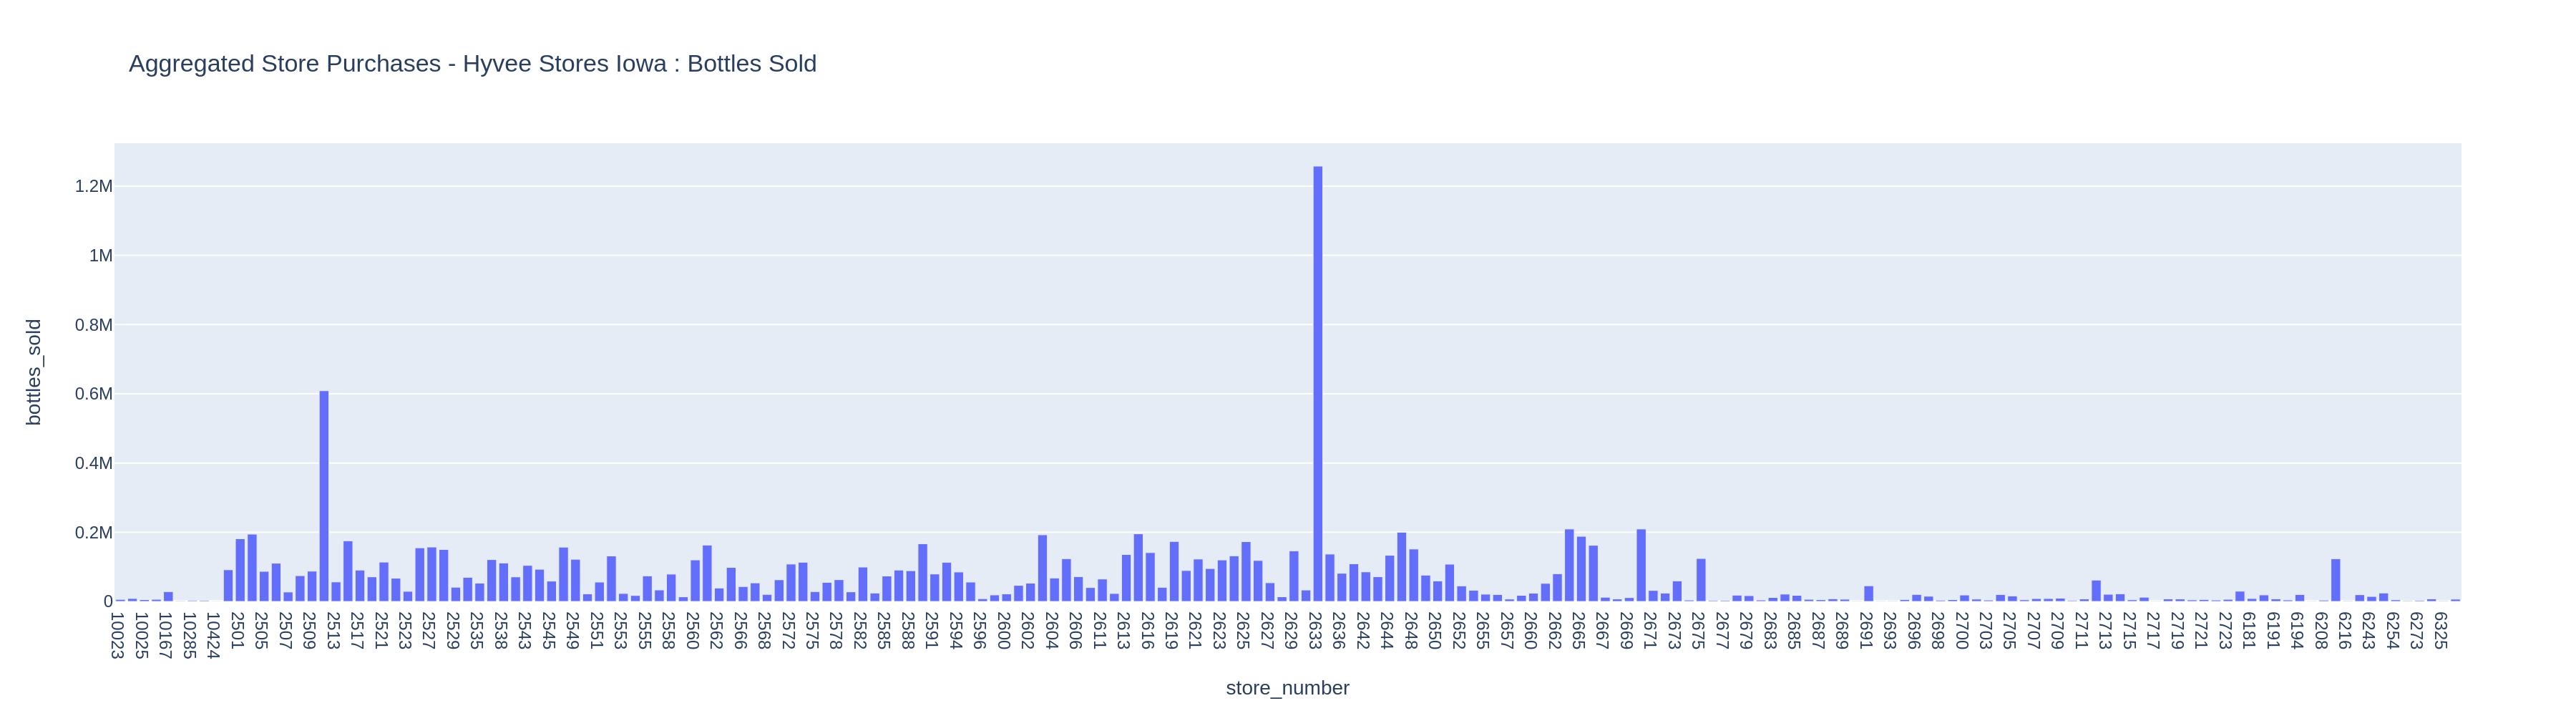

In [45]:
fig = px.bar(store_sales, x="store_number", y="bottles_sold", title="Aggregated Store Purchases - Hyvee Stores Iowa : Bottles Sold")

Image(fig.to_image(format="png", width=1800, scale=2))

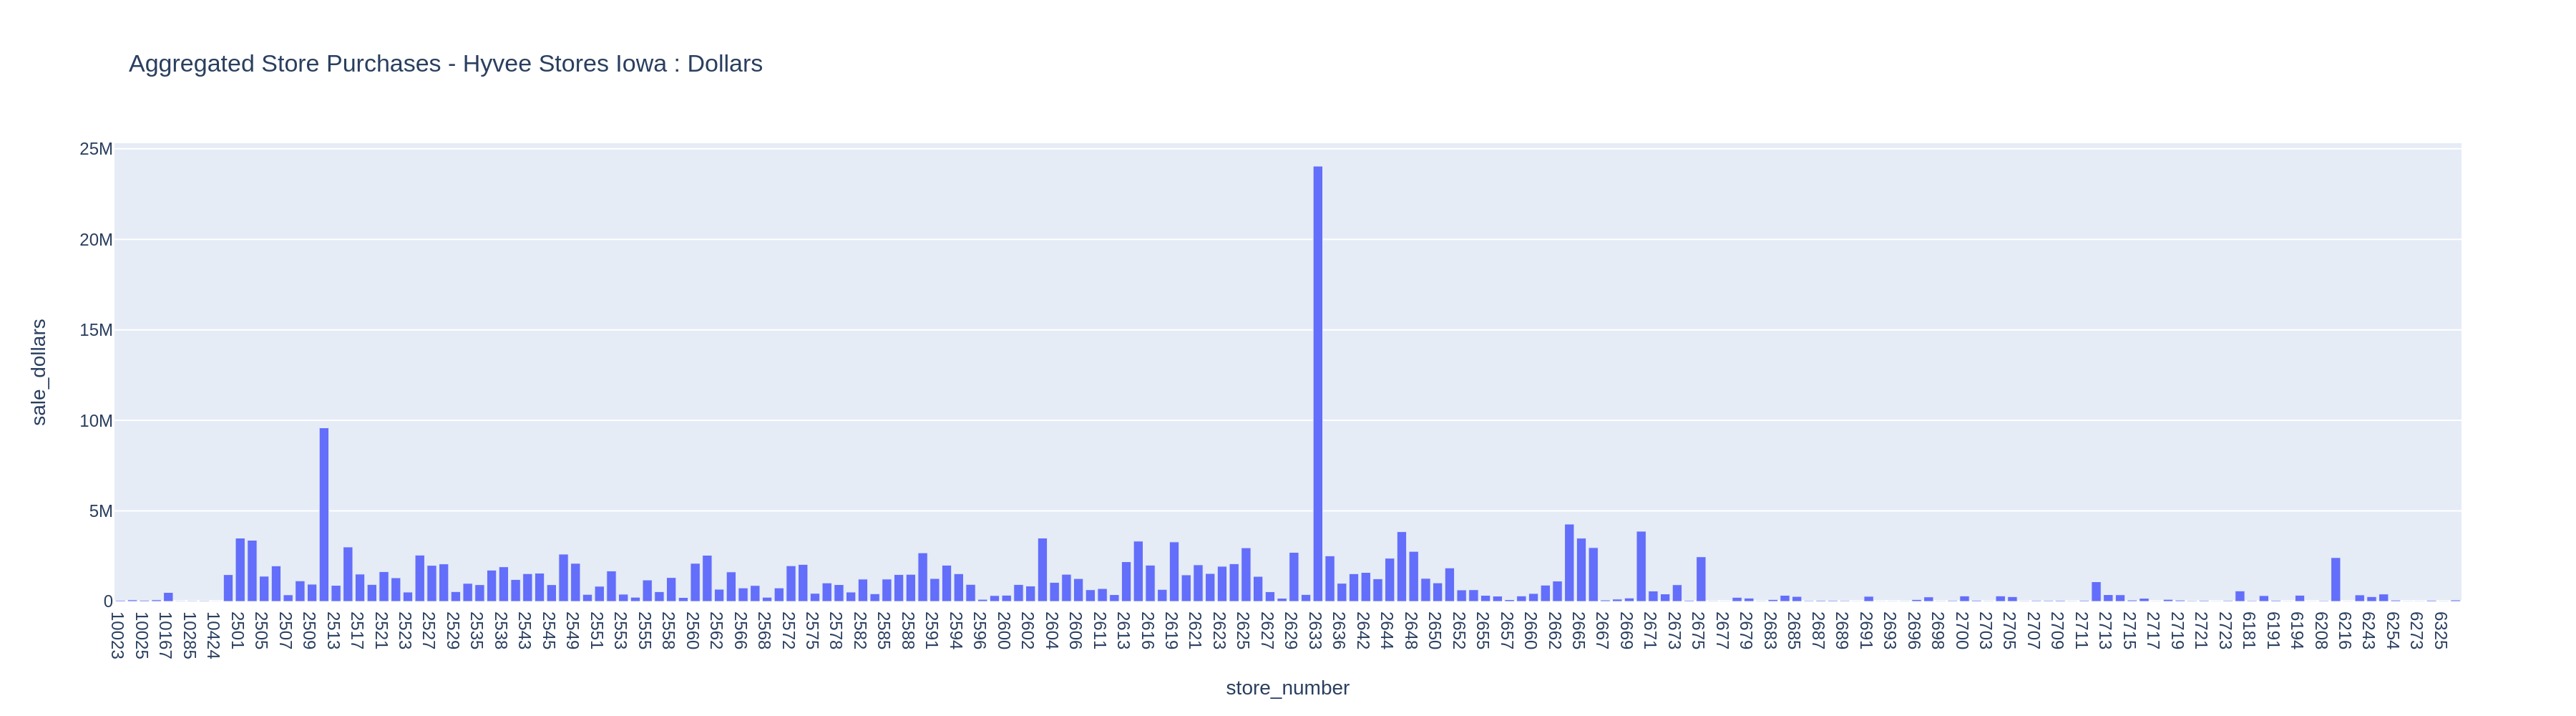

In [46]:
fig = px.bar(store_sales, x="store_number", y="sale_dollars", title="Aggregated Store Purchases - Hyvee Stores Iowa : Dollars")
Image(fig.to_image(format="png", width =1800, scale = 2))

From interactive charts, Store number 2633 has the highest sales, both in terms of bottles bought. We will run our simulation tests on this store.

In [47]:
df_hyvee_2633 = df_hyvee[df_hyvee.store_number == "2633"]

To get more insight into the store, we will examine a few more details.

In [48]:
def avg_sales_df(data):
    avg_sales = data.groupby(["store_name", "item_description", "item_number", "pack"]).agg({"bottles_sold": "sum", "sale_dollars":"sum"}) \
    .reset_index() \
    .sort_values(by="bottles_sold", ascending=False)

    avg_sales.rename(columns = {"sale_dollars": "total_sale_dollars"}, inplace=True)
    avg_sales["dollars_per_bottle"] = round(avg_sales.total_sale_dollars/avg_sales.bottles_sold, 2)
    return avg_sales

avg_sales = avg_sales_df(df_hyvee_2633)
avg_sales

store_name  \
1738  HY-VEE #3 / BDI / DES MOINES   
1745  HY-VEE #3 / BDI / DES MOINES   
340   HY-VEE #3 / BDI / DES MOINES   
784   HY-VEE #3 / BDI / DES MOINES   
989   HY-VEE #3 / BDI / DES MOINES   
...                            ...   
258   HY-VEE #3 / BDI / DES MOINES   
260   HY-VEE #3 / BDI / DES MOINES   
815   HY-VEE #3 / BDI / DES MOINES   
814   HY-VEE #3 / BDI / DES MOINES   
937   HY-VEE #3 / BDI / DES MOINES   

                                item_description item_number  pack  \
1738                        TITOS HANDMADE VODKA       38177    12   
1745                           TORTILLA GOLD DSS       77487    12   
340               CAPTAIN MORGAN ORIGINAL SPICED       43337    12   
784                                 GOTCHA VODKA       37258    12   
989                                  JUAREZ GOLD       89387    12   
...                                          ...         ...   ...   
258   BP JEFFERSONS OCEAN WHEATED BOURBON BARREL       19065     6   
260      BP LAST DROP 1971 BLENDED WHISKY W/50ML      100506     1   
815                HA GLENFIDDICH 23YR GRAND CRU      905896     3   
814                 HA ELMER T LEE SINGLE BARREL      917946    12   
937                                 JAMESON 18YR       15639     3   

      bottles_sold  total_sale_dollars  dollars_per_bottle  
1738        109668          2167039.68               19.76  
1745         60873           447416.55                7.35  
340          44832           857881.68               19.14  
784          40247           211296.75                5.25  
989          34356            439983.0               12.81  
...            ...                 ...                 ...  
258              1               67.46               67.46  
260              1              3000.0              3000.0  
815              1               270.0               270.0  
814              1               32.25               32.25  
937              1              164.99              164.99  

[1875 rows x 7 columns]

The following section assumes that purchases occur at the retail store level, with a maximum of one purchase per day, per vendor. So, if a vendor supplies multiple products, all the product purchases for that day for that store, for that vendor are assumed to have occurred at the same time. However, purchases from different vendors to the same store can occur at different times on the same day. For simplicity, the smallest measure of time used to determine the timestamp is one minute.

In [49]:
dates_per = df_hyvee.groupby(["vendor_number", "store_number","date"]).agg({"pack":"count"})

In [50]:
dates_per = dates_per.reset_index().rename(columns = {"pack": "lines"}).sort_values(by=["lines"], ascending= False)
dates_per.head()


vendor_number store_number        date  lines
66425            260         2593  2024-04-09     78
68383            260         2623  2023-06-13     78
194610           421         2623  2023-06-13     77
194006           421         2616  2023-06-06     74
188302           421         2515  2023-03-09     72

In [51]:
def sim_purchase_times(order_hrs = [8, 18]):
  num_mins = ((order_hrs[1] - order_hrs[0])  * 60)
  txn_time = datetime(1970, 1,1,8)+ timedelta(minutes = np.random.randint(1, num_mins))
  ## this assumes orders for each vendor at each store_number on each order date are submitted at the same time
  return txn_time.strftime("%H:%M")

In [52]:
dates_per["purchase_ts"] = [sim_purchase_times() for i in range(0, len(dates_per))]
dates_per.head()

vendor_number store_number        date  lines purchase_ts
66425            260         2593  2024-04-09     78       16:35
68383            260         2623  2023-06-13     78       17:50
194610           421         2623  2023-06-13     77       08:41
194006           421         2616  2023-06-06     74       09:41
188302           421         2515  2023-03-09     72       08:23

**Joining the Aggregated Purchase Time Data to the Full Hyvee DataFrame**

In [53]:
##checking for nulls in the aggregated dataset
check_null_rows(dates_per)

vendor_number            0
store_number             0
date                     0
lines                    0
purchase_ts              0


In [54]:
initial_rows = len(df_hyvee)

In [55]:
dates_per.drop(columns =["lines"], inplace=True)

In [56]:
# This joins the two DataFrames and check for any missing values
df_hyvee = df_hyvee.merge(dates_per, how="left", on=["vendor_number", "store_number", "date"])
check_null_rows(df_hyvee)

invoice_and_item_number  0
date                     0
store_number             0
store_name               0
city                     0
zip_code                 0
county                   0
category                 0
category_name            0
vendor_number            0
vendor_name              0
item_number              0
item_description         0
pack                     0
bottle_volume_ml         0
state_bottle_cost        0
state_bottle_retail      0
bottles_sold             0
sale_dollars             0
volume_sold_liters       0
volume_sold_gallons      0
purchase_ts              0


In [57]:
## row count validation
initial_rows ==len(df_hyvee)

True

In [58]:
df_hyvee.dtypes

invoice_and_item_number         string[pyarrow]
date                       date32[day][pyarrow]
store_number                    string[pyarrow]
store_name                      string[pyarrow]
city                            string[pyarrow]
zip_code                        string[pyarrow]
county                          string[pyarrow]
category                        string[pyarrow]
category_name                   string[pyarrow]
vendor_number                   string[pyarrow]
vendor_name                     string[pyarrow]
item_number                     string[pyarrow]
item_description                string[pyarrow]
pack                                      Int64
bottle_volume_ml                          Int64
state_bottle_cost                       Float64
state_bottle_retail                     Float64
bottles_sold                              Int64
sale_dollars                            Float64
volume_sold_liters                      Float64
volume_sold_gallons                     Float64
purchase_ts                              object
dtype: object

In [59]:
#Dropping extra rows
if ['level_0', 'index'] in list(df_hyvee.columns):
  df_hyvee.drop(columns = ['level_0', 'index'], inplace=True)

In the next step, the memory usage of the DataFrame is examined to make sure we can still work with Pandas.

In [60]:
columns = [ "date", "purchase_ts","vendor_number", "store_number", "item_number", "bottles_sold", "sale_dollars", "city", "zip_code", "county"]
mem_estimation = sum(df_hyvee[columns].memory_usage(deep=True)) / (1024 * 1024 * 1024)
print("Memory usage : ", round(mem_estimation, 4), 'GB' )

Memory usage :  0.1453 GB


This is well within the available memory on the 12GB CPU RAM machine used for this project. At this point the total memory usage is 3.7 GB.

In [61]:
## convert the date format
comparison_df = df_hyvee.copy()
comparison_df.drop(columns = [c for c in list(comparison_df.columns) if c not in columns], inplace=True)
if comparison_df.date.dtype == object:
  comparison_df["date"] = comparison_df["date"].astype(str).str.replace("\s{0,}[0-9]{2}\:[0-9]{2}\:[0-9]{2}\s{0,}$", '', regex=True)

comparison_df["txn_datetime"] = comparison_df["date"].astype(str).str.replace("\s{0,}[0-9]{2}\:[0-9]{2}\:[0-9]{2}\s{0,}$", '', regex=True)
comparison_df["txn_datetime"] = comparison_df["txn_datetime"].astype(str) + comparison_df["purchase_ts"].astype(str)
comparison_df["txn_datetime"] =  pd.to_datetime(comparison_df["txn_datetime"], format= "%Y-%m-%d%H:%M")
comparison_df.index = comparison_df["txn_datetime"]
comparison_df.drop(columns= "txn_datetime", inplace=True)

To check the results of the simulation times, the follwing section will order the DataFrame by Transaction Timestamp and store_number.

In [62]:
comparison_df.sort_index(ascending= True, inplace=True)
comparison_df.head()

date store_number        city zip_code county  \
txn_datetime                                                               
2023-01-02 08:39:00  2023-01-02         2696  DES MOINES    50315   POLK   
2023-01-02 08:44:00  2023-01-02         2696  DES MOINES    50315   POLK   
2023-01-02 08:53:00  2023-01-02         2699      ANKENY    50023   POLK   
2023-01-02 08:53:00  2023-01-02         2699      ANKENY    50023   POLK   
2023-01-02 08:53:00  2023-01-02         2699      ANKENY    50023   POLK   

                    vendor_number item_number  bottles_sold  sale_dollars  \
txn_datetime                                                                
2023-01-02 08:39:00           260       10804            10          75.0   
2023-01-02 08:44:00           300       36901             6          42.3   
2023-01-02 08:53:00           260       43336             9        122.31   
2023-01-02 08:53:00           260       11296             3         78.72   
2023-01-02 08:53:00           260       10807             3         78.72   

                    purchase_ts  
txn_datetime                     
2023-01-02 08:39:00       08:39  
2023-01-02 08:44:00       08:44  
2023-01-02 08:53:00       08:53  
2023-01-02 08:53:00       08:53  
2023-01-02 08:53:00       08:53

comparison_df[:100, :]

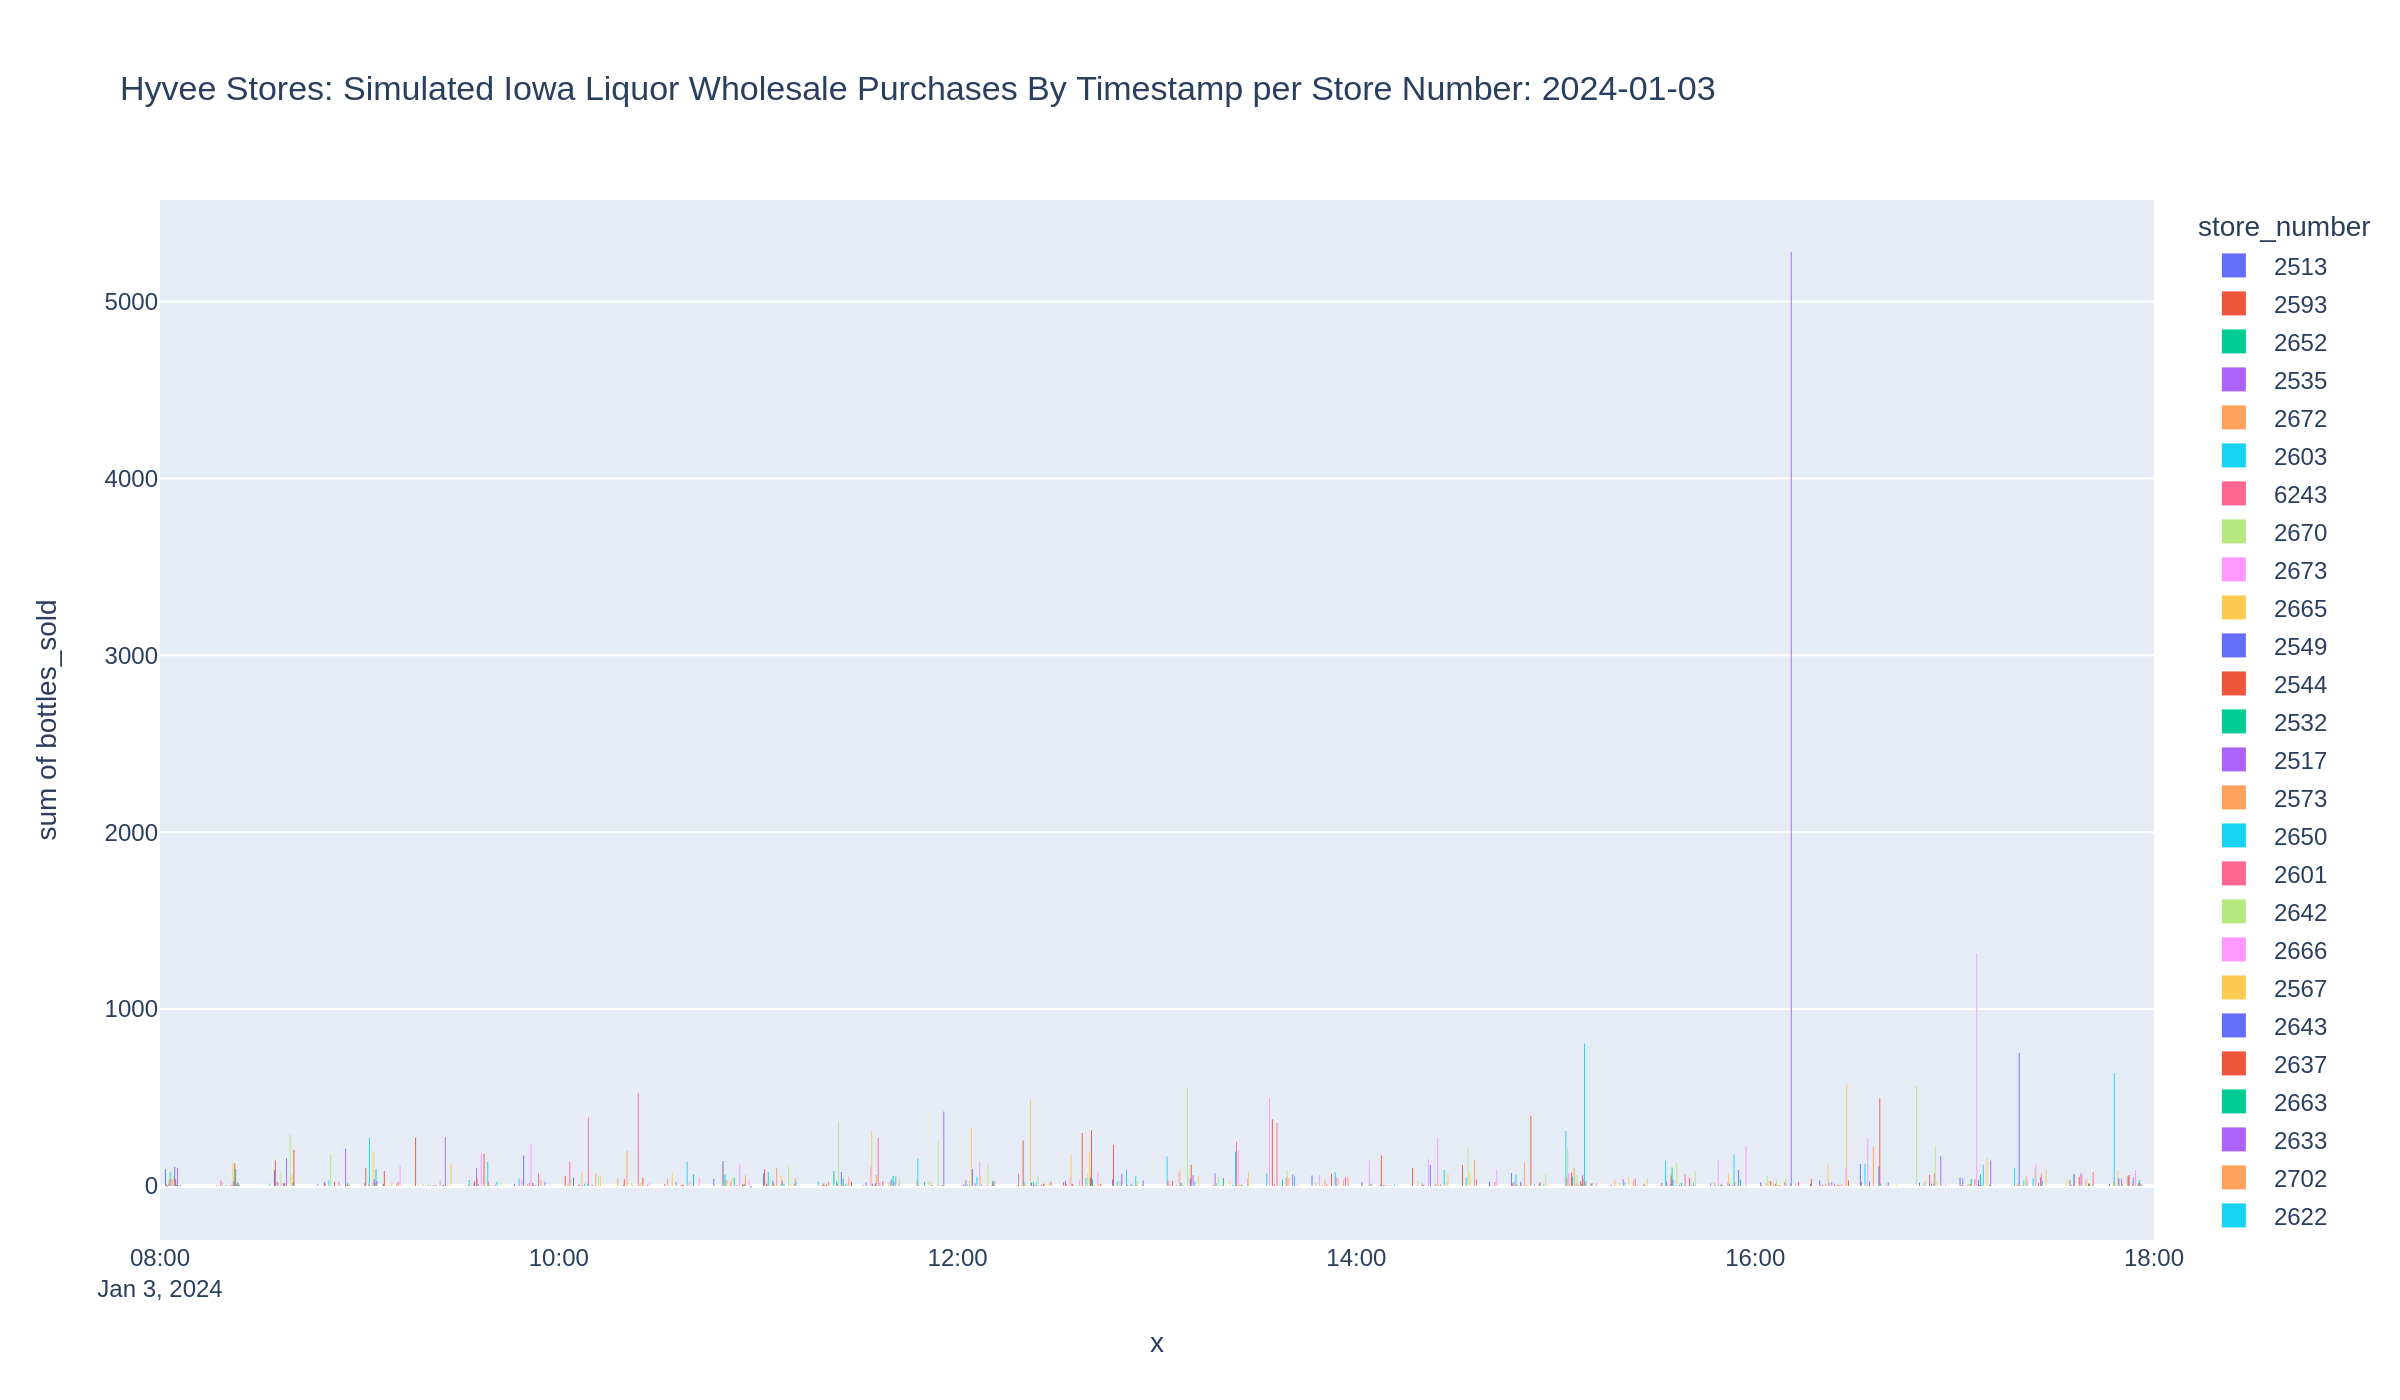

In [63]:
date = '2024-01-03'
filter_date = pd.to_datetime(date, format='%Y-%m-%d')
fig = px.histogram(comparison_df.loc[comparison_df.date == filter_date ],
             x= comparison_df.loc[comparison_df.date == filter_date].reset_index().txn_datetime,
             y="bottles_sold",
             color="store_number",
             barmode="group",
             template=None,
             width   = 1500,
             title = f"Hyvee Stores: Simulated Iowa Liquor Wholesale Purchases By Timestamp per Store Number: {date} "
             )
Image(fig.to_image(format="png", width= 1200, height= 700,scale=2))

# Column Name Update
Because this project assumes that the users are working from the buyer's side, the names of some columns will be adjusted to prevent confusion.

In [64]:
comparison_df.rename( columns = {"bottles_sold": "bottles_purchased","sale_dollars": "purchase_dollars"}, inplace=True)

In [65]:
comparison_df.reset_index(inplace=True)


To help reduce the computation times when constructing the streams, we will give each order a ficticious order number, that is based on teh assumption that each store only submits a single order to each vendor on any given day. The datetime field is converted to Epochs and concatenated as a string to the store_number and vendor_number

In [66]:
comparison_df["po_number"] = (comparison_df.store_number.astype(str) +
                              comparison_df.vendor_number.astype(str) +
                               (comparison_df.txn_datetime - pd.to_datetime('1970-01-01', format="%Y-%m-%d")).dt.total_seconds().astype(str) ).str \
                                .replace('[^0-9A-Za-z]', '', regex=True)

In [67]:
comparison_df.head()

txn_datetime        date store_number        city zip_code county  \
0 2023-01-02 08:39:00  2023-01-02         2696  DES MOINES    50315   POLK   
1 2023-01-02 08:44:00  2023-01-02         2696  DES MOINES    50315   POLK   
2 2023-01-02 08:53:00  2023-01-02         2699      ANKENY    50023   POLK   
3 2023-01-02 08:53:00  2023-01-02         2699      ANKENY    50023   POLK   
4 2023-01-02 08:53:00  2023-01-02         2699      ANKENY    50023   POLK   

  vendor_number item_number  bottles_purchased  purchase_dollars purchase_ts  \
0           260       10804                 10              75.0       08:39   
1           300       36901                  6              42.3       08:44   
2           260       43336                  9            122.31       08:53   
3           260       11296                  3             78.72       08:53   
4           260       10807                  3             78.72       08:53   

            po_number  
0  269626016726487400  
1  269630016726490400  
2  269926016726495800  
3  269926016726495800  
4  269926016726495800

# Streaming Data:

To avoid the complexity of constructing a streaming data pipeline, this section will simply create some simple loop through data to simulate part of the retailer's central buying platform.

In [68]:
filtered_cols = ['txn_datetime','date', 'store_number', 'vendor_number', 'item_number','bottles_purchased','purchase_dollars']

class PrepForStream:
  """
  This class aids in the creation of json files to send to streams
  """

  def __init__(self, in_data,start_date, end_date, columns=filtered_cols, exclude_returns=True):

    self.columns    = columns
    self.in_data    = in_data
    self.pre_df     = None
    self.out_json   = None
    self.start_date = start_date
    self.end_date   = end_date
    self.exclude_returns = exclude_returns


    if not isinstance(start_date,pd._libs.tslibs.timestamps.Timestamp ): start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    if not isinstance(end_date,pd._libs.tslibs.timestamps.Timestamp )  : end_date   = pd.to_datetime(end_date, format='%Y-%m-%d')

    date_filter  = (self.in_data.date >= start_date  ) & \
                   (self.in_data.date <= end_date)

    self.pre_df       = self.in_data.loc[date_filter,columns]

    if self.exclude_returns:
      self.pre_df  = self.pre_df[self.pre_df.bottles_purchased > 0 ]


  def gen_json_obj(self):
    self.pre_df_json   = self.pre_df.to_json(orient="records")


  def gen_json_output(self, store_numbers=None, vendor_numbers =None):
    """
       Send purchase data as JSON, One order Per Day , Per Vendor, Per Store

    """
    if self.pre_df is None:
      self.filter_date_range(self.start_date, self.end_date)

    store_numbers   = store_numbers if   store_numbers is not None  else self.in_data.store_number.unique()
    vendor_numbers  = vendor_numbers if  vendor_numbers is not None else self.in_data.vendor_number.unique()
    pre_filtered_df = self.pre_df.loc[(self.pre_df.store_number.isin(store_numbers)) & (self.pre_df.vendor_number.isin(vendor_numbers))]

    indices = pre_filtered_df.groupby(['txn_datetime', 'store_number', 'vendor_number']).agg({"date":"count"}).index

    self.out_json = [self.gen_json_obj(txn_datetime  = x[0],
                                       store_number  = x[1],
                                       vendor_number = x[2],
                                      )
                      for  x in indices

                     ]

start_stream = PrepForStream(in_data    = comparison_df
                            ,start_date = '2023-01-02',
                             end_date   = '2023-01-31'
                             )


# Analytics

# Delta Coding

This section introduces Delta Encoding as a way to reduce the storage requirements and consequently, the computational requirements of streaming analytics systems by computing aggregates and differences at longer intervals than the rate of incoming streams.



**The Kullback-Leibler Divergence**

The Kullback-Leibler Divergence is a commonly used Divergence metric that can be used to detect differences in probability distributions. Assuming a Corporate Buying department would like daily data captured when the daily distribution of total sku/item purchases differs from a set baseline known distribution, Delta Coding can be used to capture only specific data when the daily distributions of product purchases differ from the baseline. In the example below, the previous year's probability distribution for bottle counts per item_number/sku is used as the baseline.  The implementation of the KL-Divergence is based on one used in SciPy at https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy.special.kl_div


In [69]:
def get_items_count_distr(data,
                          groupby_col    = "item_number",
                          agg_dict       = {"bottles_purchased": "sum"} ,
                          rename_columns = {"bottles_purchased": "bottle_count"},
                          distr_col      = "bottle_count",
                          drop_reindexed = False):
    """
     Function to create a probability distribution for the counts
    """
    items = data.groupby(groupby_col).agg(agg_dict).rename(columns=rename_columns).reset_index()
    items[distr_col] = items.bottle_count/sum(items.bottle_count)
    return items

## For Data Range Filter
start = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
end   = pd.to_datetime('2023-12-31', format='%Y-%m-%d')
date_filter = (comparison_df.date >= start) & (comparison_df.date <= end)

items_pdf_yr_2023 = get_items_count_distr(comparison_df[date_filter])
items_pdf_yr_2023

item_number  bottle_count
0          10006      0.000114
1          10008      0.000606
2          10009      0.000076
3         100104      0.000019
4         100148      0.000024
...          ...           ...
4070      997874      0.000001
4071      999920      0.000001
4072      999927      0.000029
4073      999939      0.000009
4074      999940      0.000014

[4075 rows x 2 columns]

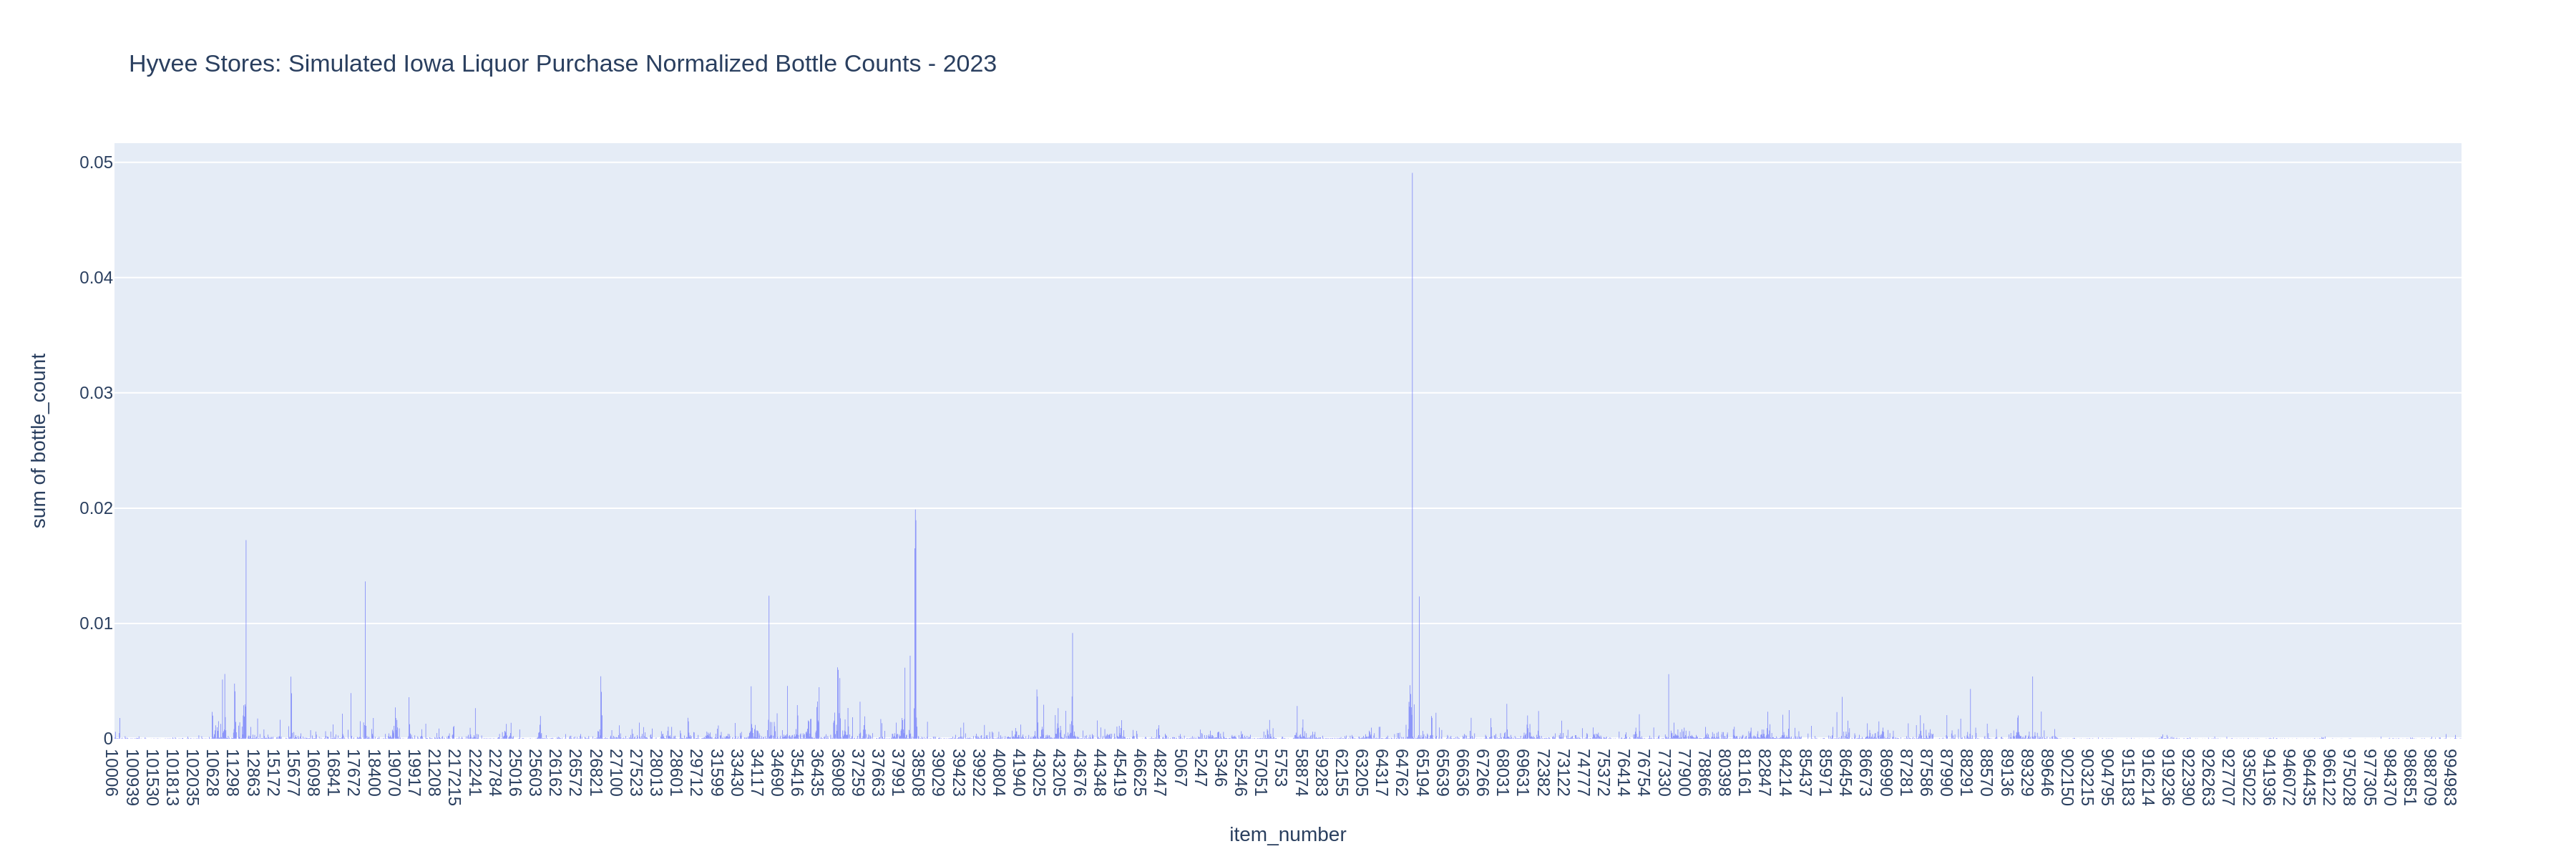

In [70]:
from IPython.display import display
def plot_simple_histogram(data, x ,
                                 y,
                          barmode,
                          template,
                          width,
                          title,
                          height=None,
                          as_image = True,
                          image_format="png",
                          image_width=1800,
                          image_scale=2.0 ):
    fig = px.histogram(data,
                      x= x,
                      y=y,
                      barmode =barmode,
                      template=template,
                      width   = width,
                      height  = height,
                      title =   title
                      )
    if as_image:
      display(Image(fig.to_image(format=image_format, width =image_width, scale = image_scale)))
    else:
      fig.show()


plot_simple_histogram(data   = items_pdf_yr_2023,
                      x      = "item_number",
                      y      ="bottle_count",
                      barmode="group",
                      template=None,
                      width   = 1800,
                      title   = f"Hyvee Stores: Simulated Iowa Liquor Purchase Normalized Bottle Counts - 2023" ,
                      height= 600,
                      as_image = True
)


The next section selects a random date after the  last date used for the baseline distribution, converts the purchases to a distribution, then does a full outer join with the baseline distribution so that all products involved are included in the analysis.

In [71]:
## Random Date in 2024 distribution
np.random.seed(19309)

def get_distrs(data,
               filter_by_date,
               baseline_data= items_pdf_yr_2023,
               feature_col  = "bottle_count",
               join_col     = "item_number"
                      ):
    """
      Function to combine Target Distribution with Baseline in a DataFrame
    """
    if filter_by_date is not None:
      tgt_data = data[data.date == filter_by_date]
    else:
      tgt_data = data
    tgt_data= get_items_count_distr(data = tgt_data)
    ## full outer  join using full item set to get all items from both the orig distr  and new one
    tgt_data = pd.merge(baseline_data[[join_col, feature_col]],tgt_data, how="outer" , on= join_col )
    tgt_data[[ f"{feature_col}_x", f"{feature_col}_y"]]= tgt_data[[f"{feature_col}_x", f"{feature_col}_y"]].fillna(0).astype(float)

    return  tgt_data

def get_random_date( data , end ):
    counter     = 0
    random_date = None
    record_count = (data.loc[max(list(data.index))][0] - end).days
    try_date    = True
    while try_date:
        random_idx = np.random.randint(0, record_count,  1)
        random_dates = data.date[data.date == end + pd.Timedelta(days=random_idx[0])].reset_index(drop=True)
        counter+=1
        if len(random_dates)> 0:
          random_date = random_dates.loc[0]
          try_date = False
        if counter >= 100:
          raise ValueError("Unabale to get date. Please try again.")

    return random_date



random_date = get_random_date(comparison_df, end = end)
combined_distrs = get_distrs(data           = comparison_df,
                             filter_by_date = random_date,
                             baseline_data= items_pdf_yr_2023,
                             feature_col  = "bottle_count",
                             join_col     = "item_number"
                            )

print(f"Target Date : {random_date}")

combined_distrs

Target Date : 2024-06-06


item_number  bottle_count_x  bottle_count_y
0          10006        0.000114        0.000821
1          10008        0.000606        0.000308
2          10009        0.000076        0.000000
3         100104        0.000019        0.000000
4         100148        0.000024        0.000000
...          ...             ...             ...
4120       87143        0.000000        0.000205
4121       88598        0.000000        0.000205
4122      916850        0.000000        0.009036
4123      921689        0.000000        0.000103
4124      928726        0.000000        0.000034

[4125 rows x 3 columns]

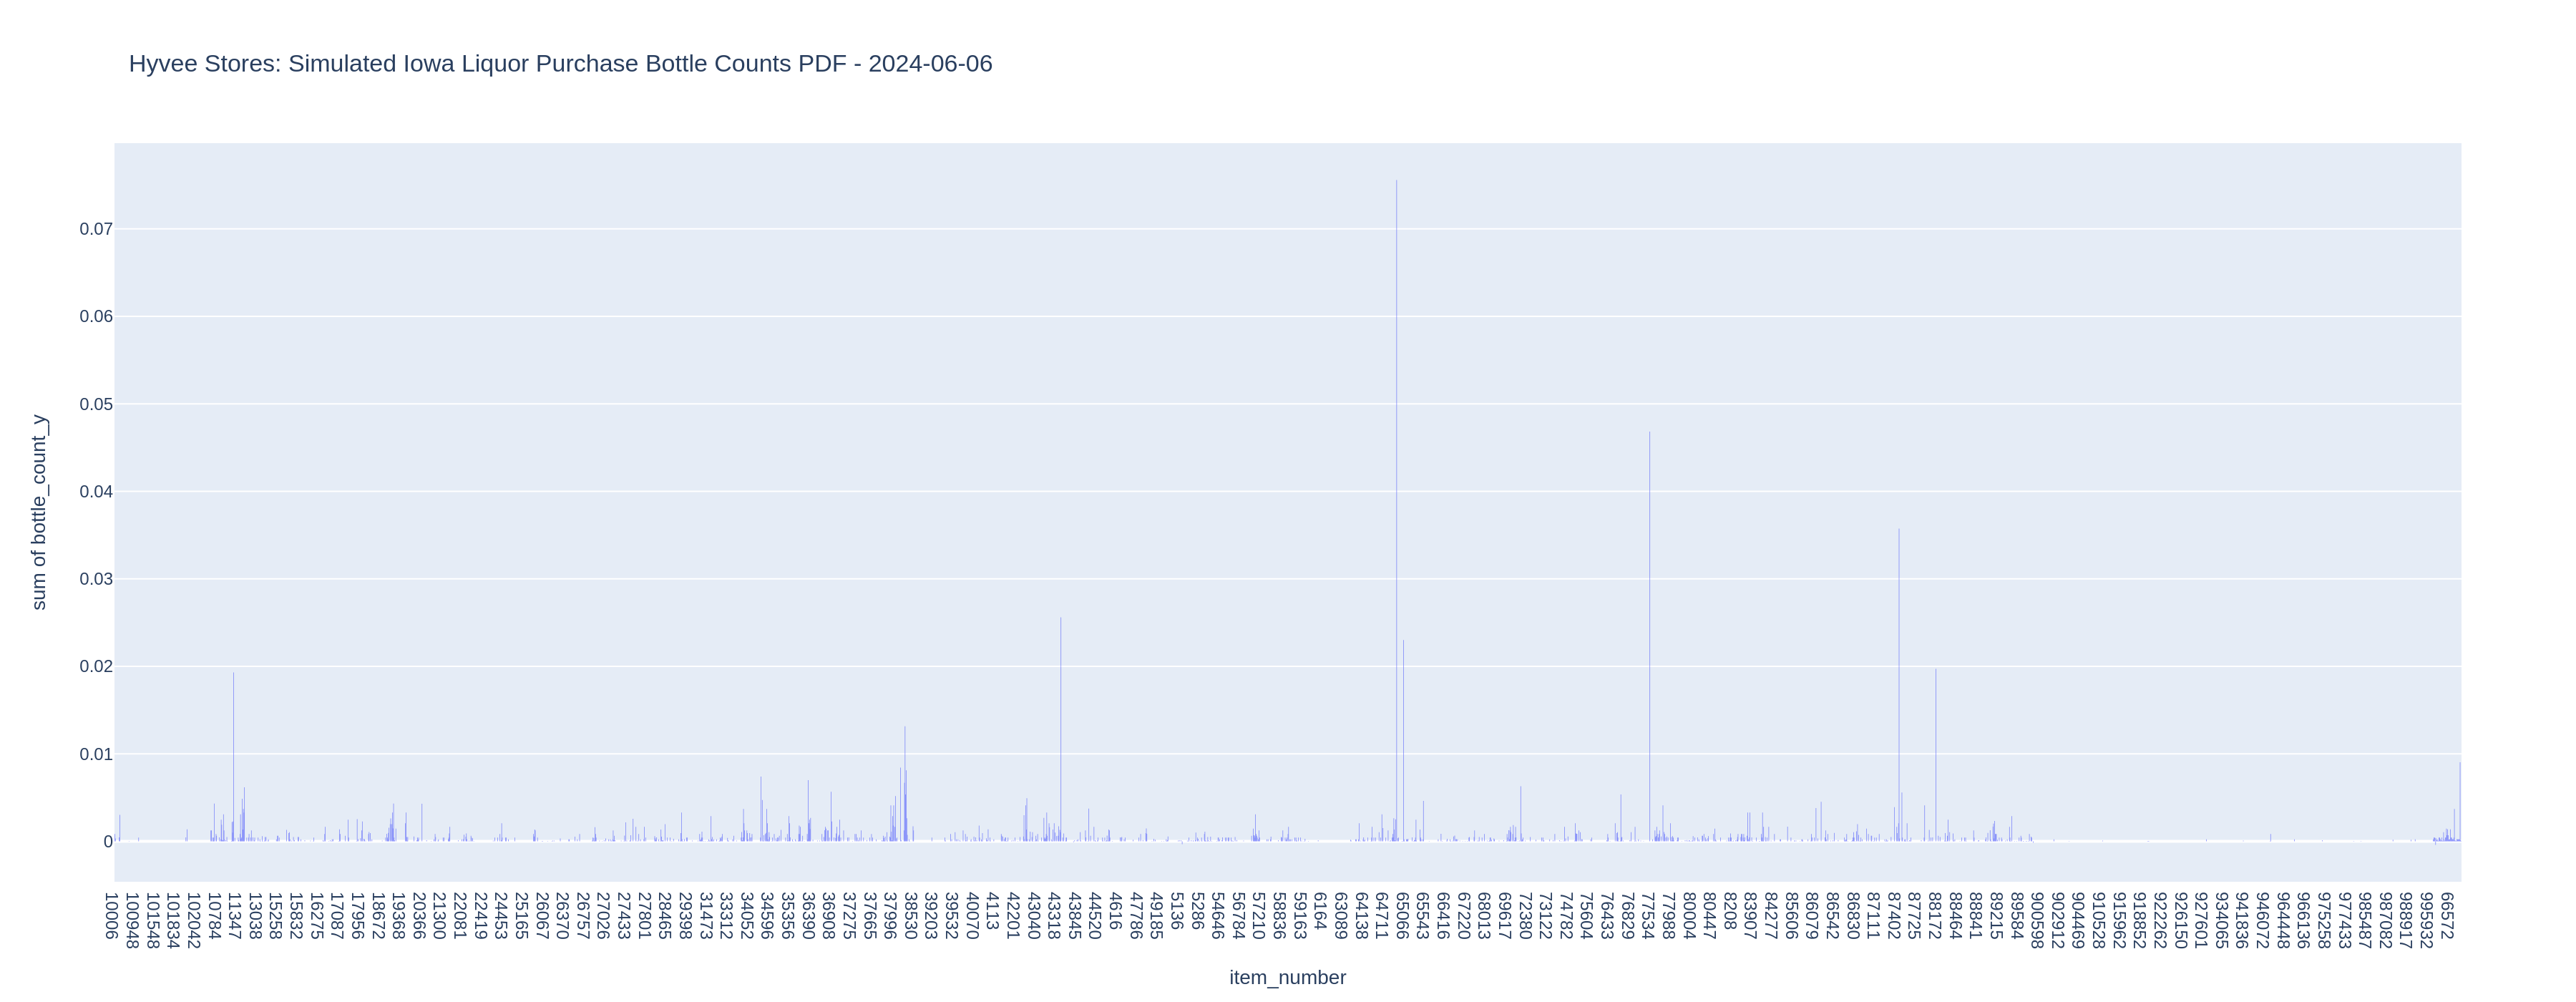

In [72]:
plot_simple_histogram(data   = combined_distrs,
                      x      = "item_number",
                      y      = "bottle_count_y",
                      barmode="group",
                      template =None,
                      width    = 1800,
                      title    = f"Hyvee Stores: Simulated Iowa Liquor Purchase Bottle Counts PDF - {random_date}",
                      height   = 700,
                      as_image = True
)

The function below computes the KL Divergence based on the the Sci-Py Impelementation at https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy.special.kl_div .

In [73]:
def kld_from_df(data, p_column, q_column ):
    """
      Calculate KL Divergence based on KLD(P||Q) = SUM ((P * log(P/Q))- P + Q) where P and Q are probablity distributions.
      This is based on the Implemenation from scipy.special
    """
    ## Set column to hold the inner log values.
    data["kld_inner"] = np.nan

    non_zero_filter = (data[q_column] > 0 ) & (data[p_column] > 0 )
    data.loc[non_zero_filter, "kld_inner"]  =np.log(data[p_column][non_zero_filter]/data[q_column][non_zero_filter] )

    zero_x_filter  =  (data[q_column] >= 0 ) & (data[p_column] == 0 )
    data.loc[zero_x_filter, "kld_inner"] = 0

    y_eq_zero_filter = data[q_column]==0
    data.loc[y_eq_zero_filter, "kld_inner"] = 0

    kld = np.sum((data[p_column] * data["kld_inner"]) - data[p_column] + data[q_column])

    return kld

kld_from_df(combined_distrs,"bottle_count_x", "bottle_count_y" ) ,kld_from_df(combined_distrs,"bottle_count_y", "bottle_count_x" )

(0.2347877854075289, 0.7528522643820352)

In this section, the cumulative sums of the data per product are computed and saved. In doing so, only one data point per item will consume memory. This will also be an efficient process as the computation is a simple addition and hash table search or update for each product SKU/Item.

This will assume that failover protection and disaster recovery are implemented in a distributed system while using Pandas. Dask or Spark can be implemented to accomplish this.



In [74]:
def run_stream_sim(data,
                   filter_by_date,
                   save_freq          =1000,
                   baseline_distr     = items_pdf_yr_2023,
                   kld_thresh         = [0.05, 0.9],
                   output_filepath    =f"./cumulative_sum_stream.csv"):
    """
      Helper function to simulate a stream. This will look though values.
      In real time, data would be passed in when available, but in this implementation the redundancy in processing
      multiple DataFrames is for simulation purposed.
    """
    date_idx          = np.argwhere(data.columns == 'date')[0][0]
    item_number_idx   = np.argwhere(data.columns == 'item_number')[0][0]
    qty_idx           = np.argwhere(data.columns == 'bottles_purchased')[0][0]

    columns =  ["last_row_id", "date" , "item_number", "bottles_purchased"]
    cumulative_sum_df = pd.DataFrame(columns= columns)
    counter = 0
    if filter_by_date is not None: data = data[data.date == filter_by_date]
    klds = []
    for i, row in data.iterrows():
      filter = cumulative_sum_df.item_number == row[item_number_idx]
      if len(cumulative_sum_df[filter] ) > 0 :
        cumulative_sum_df.loc[filter, "bottles_purchased"] = cumulative_sum_df.loc[filter, "bottles_purchased"] + row[qty_idx]
      else:
        cumulative_sum_df = pd.concat([cumulative_sum_df, pd.DataFrame( zip([i],[row[date_idx]], [row[item_number_idx]], [row[qty_idx]]), columns = columns)], axis=0)
        cumulative_sum_df.reset_index(inplace=True, drop=True)
      counter+=1

      ## save cumulative data at specific intervals
      if save_freq is not None:
         if counter%save_freq == 0 and counter > 0  :
          cumulative_sum_df.to_csv(output_filepath, header=True, index=False)


    #final save
    cumulative_sum_df.to_csv(output_filepath, header=True, index=False)

    ## KLD Values at end of period/date
    combed_distrs = get_distrs(cumulative_sum_df,
                               filter_by_date = filter_by_date,
                               baseline_data  = baseline_distr,
                               feature_col    = "bottle_count",
                                join_col       = "item_number"
                               )
    kld1= kld_from_df(combed_distrs,"bottle_count_x", "bottle_count_y" )
    kld2= kld_from_df(combed_distrs,"bottle_count_y", "bottle_count_x" )

    ##If thresholds breached return values
    if (kld1 < kld_thresh[0] or kld1 > kld_thresh[1] or kld2 < kld_thresh[0] or kld2 > kld_thresh[1]):
           klds.append([filter_by_date, kld1,kld2])
    if len(klds) > 0 :
      return klds
    return

#lower and upper KL Divergence threshold values

thresh = [0.05, 0.9]
data = comparison_df
start_seed =52346
klds = []
for i in range(start_seed, start_seed+11):
    np.random.seed(i)
    random_date= get_random_date(data, end)
    print(random_date)
    kld_out = run_stream_sim(data, kld_thresh=thresh, filter_by_date = random_date)
    if kld_out is not None:
        klds.append(kld_out)
print("Dates With Purchases Breaching Thesholds:")
klds

2024-04-02
2024-03-25
2024-04-19
2024-02-15
2024-02-18
2024-07-23
2024-02-22
2024-02-22
2024-04-23
2024-07-16
2024-07-24
Dates With Purchases Breaching Thesholds:


[[[datetime.date(2024, 2, 18), -0.11971788084024397, 1.3806044443554613]]]

From the randomly selected dates, only one date was outside the selected threshold. Changing the threshold might result more dates selected.

This illustrates how Delta Coding can be used to report only the necessary data based on a threshold. The next section will attempt to find optimal thresholds using previous data. In this case, a DataFrame will be used to find KL Divergences for each given date between Jan-01 -2024 to June-30th-2024. The results will then be evaluated using data from July-2024.

In [75]:
filter = (comparison_df.date > end) &   (comparison_df.date < pd.to_datetime('2024-07-01', format="%Y-%m-%d"))
daily_item_df = comparison_df[["date", "item_number", "bottles_purchased"]][filter].groupby(["item_number","date"]).agg({"bottles_purchased" :"sum"}).sort_values(by="date").reset_index()
daily_item_df.head(3)

item_number        date  bottles_purchased
0       10805  2024-01-01                  1
1       11296  2024-01-01                  1
2       11776  2024-01-01                 12

In [76]:
klds_df      = pd.Series(daily_item_df.date.unique())
klds_df      = pd.DataFrame(klds_df, columns = ["date"])
klds_df.head(3)

date
0  2024-01-01
1  2024-01-02
2  2024-01-03

In [77]:
def get_daily_kld(full_data, baseline_distr, filter_by_date):
    data_for_date = full_data[full_data["date"] ==filter_by_date]
    combed_distrs = get_distrs(data_for_date,
                                filter_by_date = filter_by_date,
                                baseline_data  = baseline_distr,
                                feature_col    = "bottle_count",
                                join_col       = "item_number"
                                )
    kld1= kld_from_df(combed_distrs,"bottle_count_x", "bottle_count_y" )
    kld2= kld_from_df(combed_distrs,"bottle_count_y", "bottle_count_x" )
    return [kld1,kld2]

klds_df[["kl_divergence1", "kl_divergence2"]] = [get_daily_kld(comparison_df, items_pdf_yr_2023, filter_by_date=d) for d in klds_df.date]

In [78]:
#Standardization
klds_df[["kl_divergence1", "kl_divergence2"]].std().to_numpy()
klds_df["kl_divergence1_scaled"] = (klds_df["kl_divergence1"] - klds_df["kl_divergence1"].mean())/klds_df["kl_divergence1"].std()
klds_df["kl_divergence2_scaled"] = (klds_df["kl_divergence2"] - klds_df["kl_divergence2"].mean())/klds_df["kl_divergence2"].std()

To generate some thresholds, the known KL-Divergence data is standardized, and thresholds are set such that only outliers are reported. The thresholds are set towards the extremities of the standardized data.
Visualizations will help find the best thresholds.



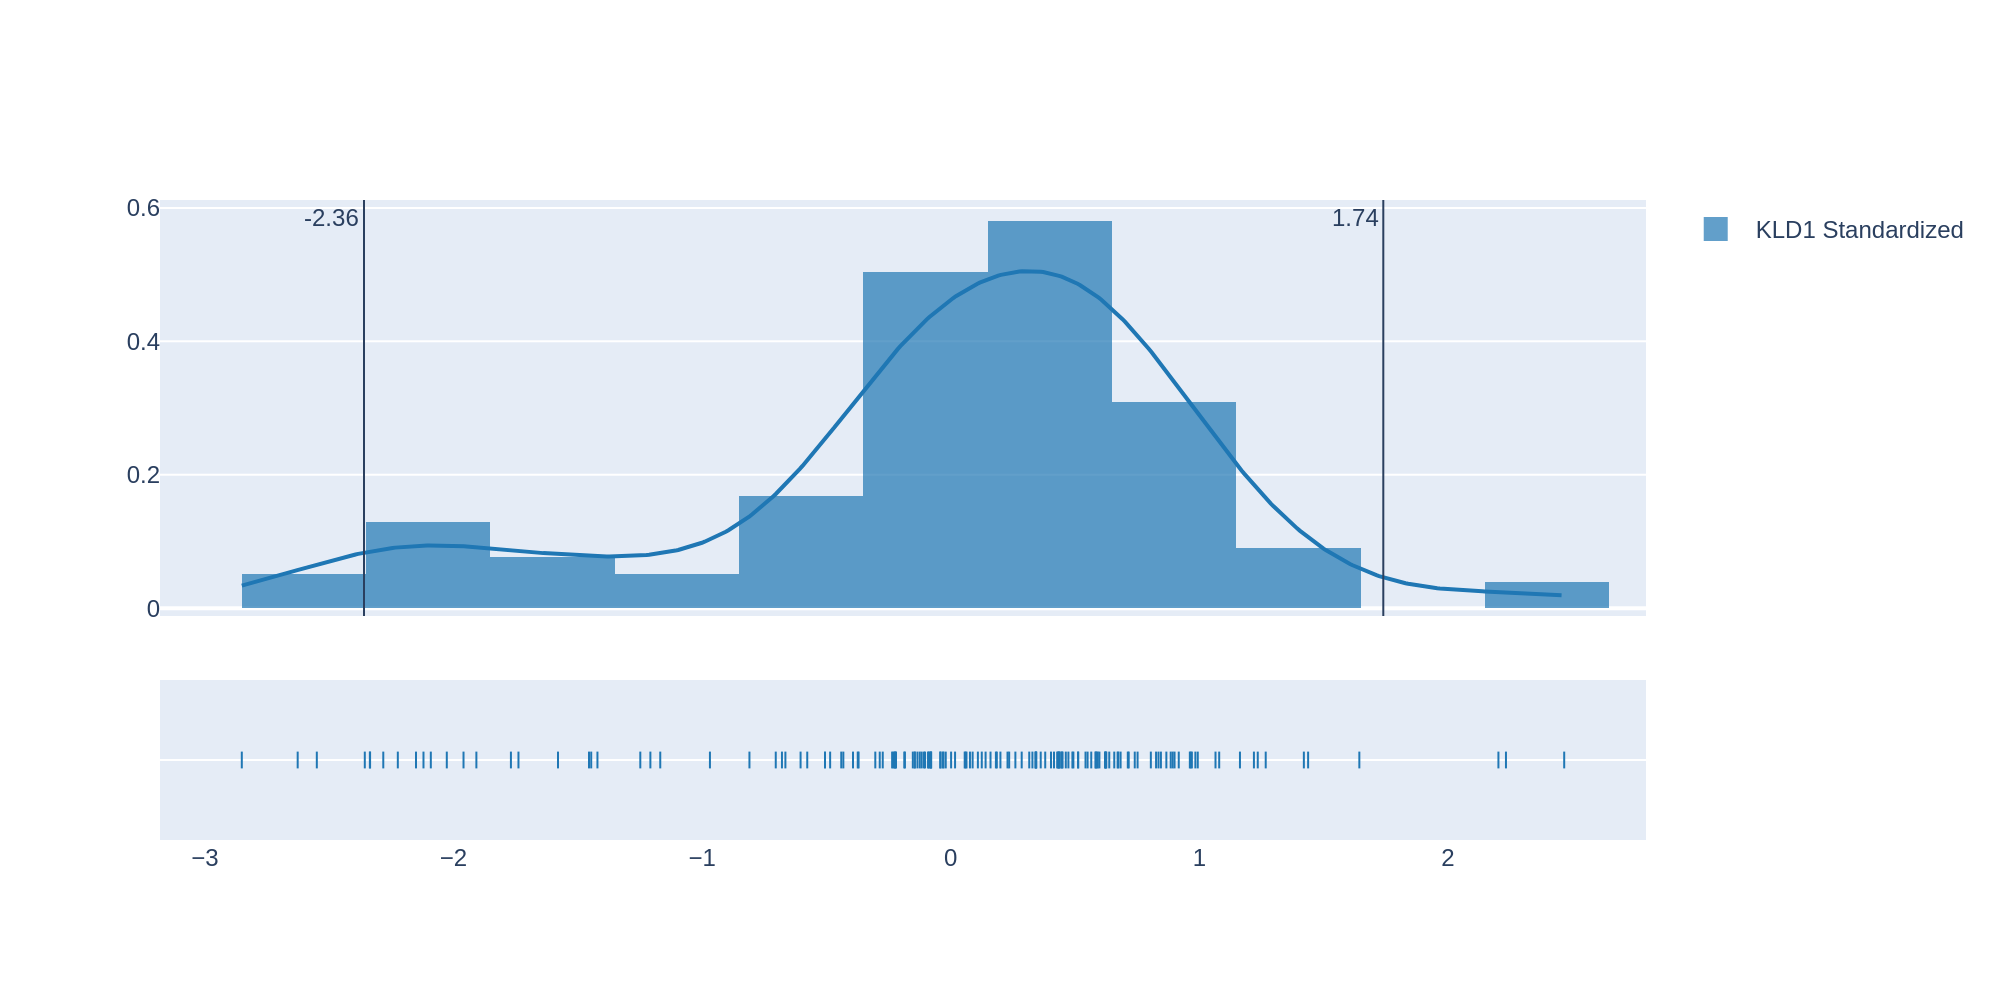

In [79]:
import plotly.figure_factory as ff
import numpy as np
np.random.seed(1)

hist_data = [klds_df["kl_divergence1_scaled"]]
group_labels = ['KLD1 Standardized'] # name of the dataset


def pyplot_distplot(hist_data, group_labels, v_lines= None, as_image=True,bin_size=0.5, width=1000, scale=2.0):
    """
      Outputs a distribution plot with markers as vertical lines

    """
    fig = ff.create_distplot(hist_data, group_labels, bin_size=bin_size)

    for score in v_lines:
        fig.add_vline(x=score,
                      annotation_text=score, annotation_position="top left",
                      line_width=1)

    if not as_image:
      fig.show()

    else:

      return Image(fig.to_image(format="png", width = width, scale = scale))

v_lines = [1.74, -2.36]
pyplot_distplot(hist_data, group_labels,  v_lines= v_lines, as_image=True)

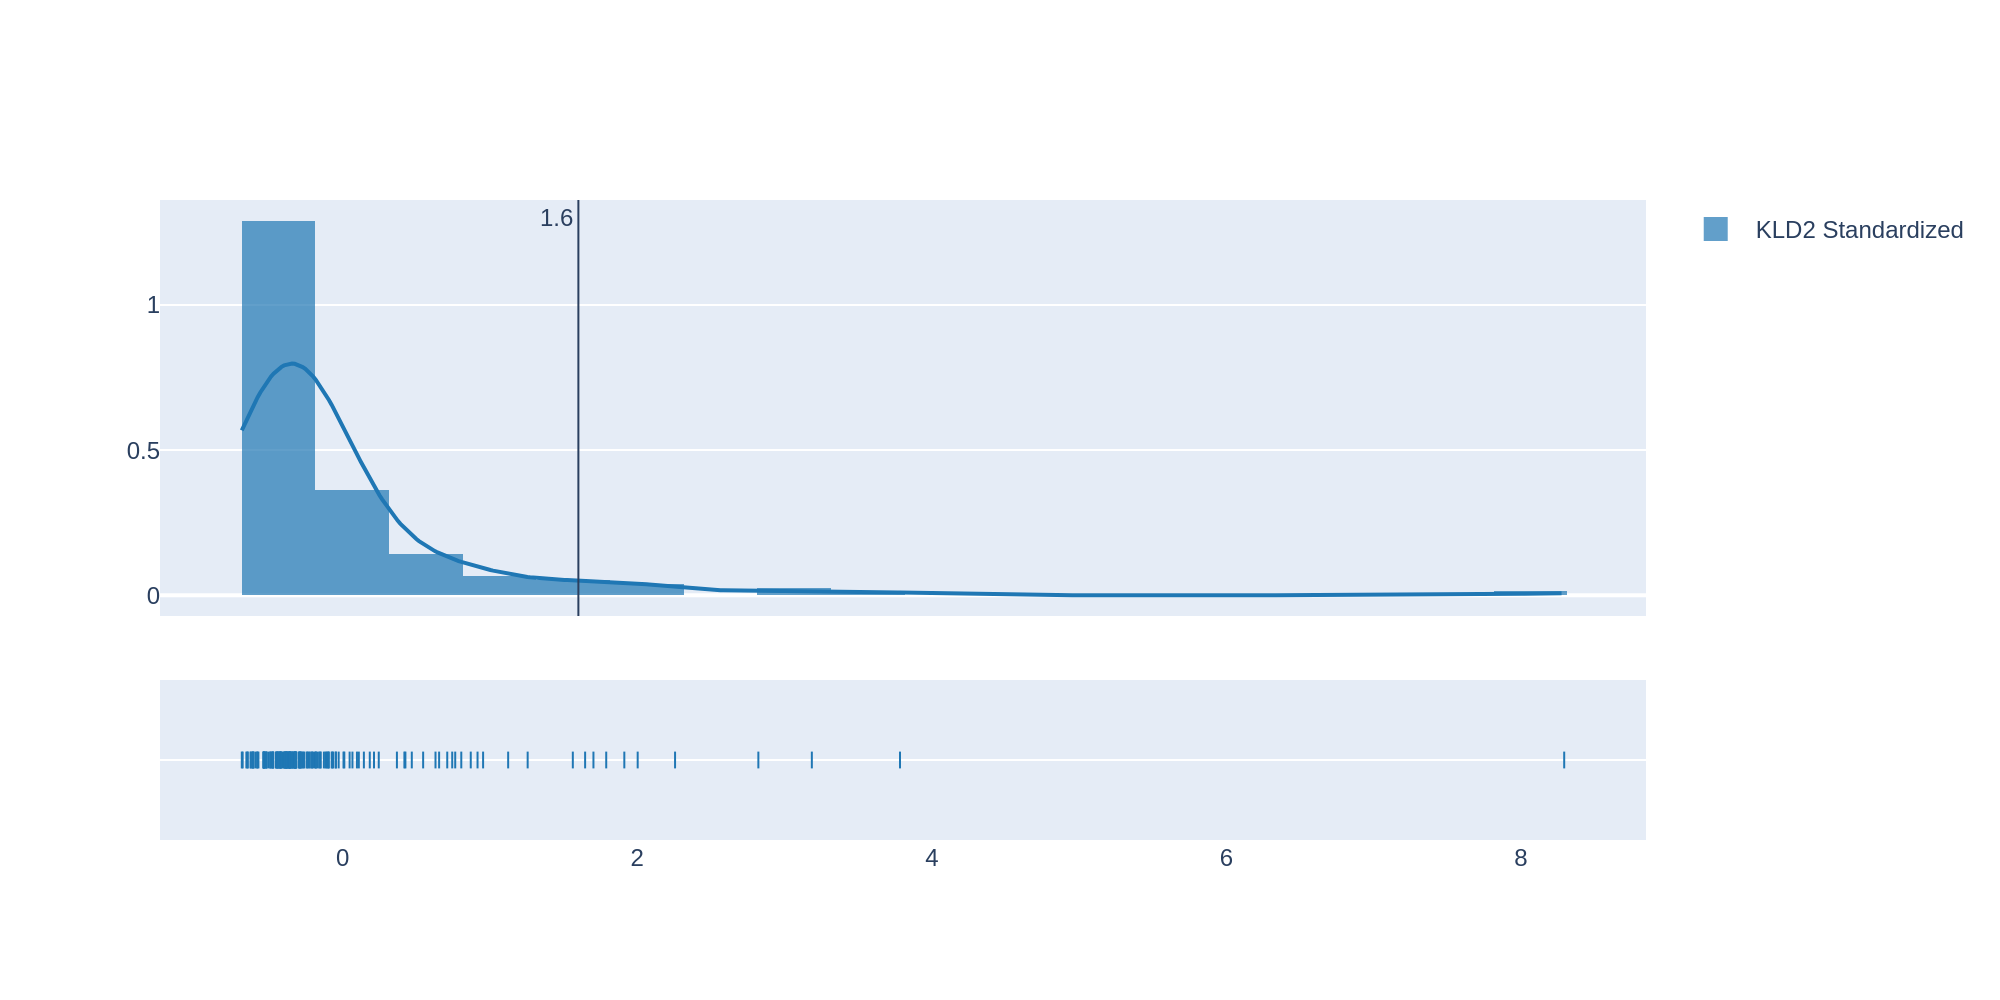

In [80]:
hist_data = [klds_df["kl_divergence2_scaled"]]
group_labels = ['KLD2 Standardized'] # name of the dataset
v_lines = [1.6]
pyplot_distplot(hist_data, group_labels,  v_lines= v_lines, as_image=True)

The vertical lines show the outliers for the first KL-Divergence (KLD1) Line starting around 1.74 and -2.36 for the standardized values. The same can be seen for the KL-Divergence (KLD2) around 1.6. These standardized values will be used to  set the thresholds for the actual KL Divergence values.



In [81]:
kld1_thresh ={"lower" : klds_df.kl_divergence1[klds_df["kl_divergence1_scaled"] <= -2.36 ].max(), "upper": klds_df.kl_divergence1[klds_df["kl_divergence1_scaled"] >= 1.74 ].min()}

kld2_thresh ={"lower":None, "upper" :klds_df.kl_divergence2[klds_df["kl_divergence2_scaled"] >1.6 ].min() }

print(kld1_thresh, kld2_thresh)


{'lower': -0.19124183207998996, 'upper': 0.38481594333739505} {'lower': None, 'upper': 1.645240420736231}


While we can run the streaming simulation here, we will just use the data for July 2024 to see which would get reported if the data was getting streamed.

In [82]:
df_July2024 = comparison_df["date"][ comparison_df.date >= pd.to_datetime('2024-07-01', format="%Y-%m-%d")].unique()
df_July2024 = pd.DataFrame(pd.Series(df_July2024) ,columns = ["date"])
df_July2024[["kl_divergence1", "kl_divergence2"]] = [get_daily_kld(comparison_df, items_pdf_yr_2023, filter_by_date=d) for d in df_July2024["date"]]

df_July2024.tail(3)

date  kl_divergence1  kl_divergence2
26  2024-07-29        0.193665        0.818758
27  2024-07-30        0.230905        0.813413
28  2024-07-31        0.145448        0.537023

In [83]:
filter1 = (df_July2024.kl_divergence1 < kld1_thresh.get("lower") ) | (df_July2024.kl_divergence1 >kld1_thresh.get("upper"))
filter2 = (df_July2024.kl_divergence2 < kld2_thresh.get("lower") ) | (df_July2024.kl_divergence2 > kld2_thresh.get("upper"))

df_July2024[filter1 | filter2]

date  kl_divergence1  kl_divergence2
6   2024-07-07        0.127999        1.719531
16  2024-07-18        0.444686        1.117852
25  2024-07-28       -0.188729        2.422415

It appears three days in July-2024 had product purchase distributions outside the norm. A chart of  one of these could provide more insight.

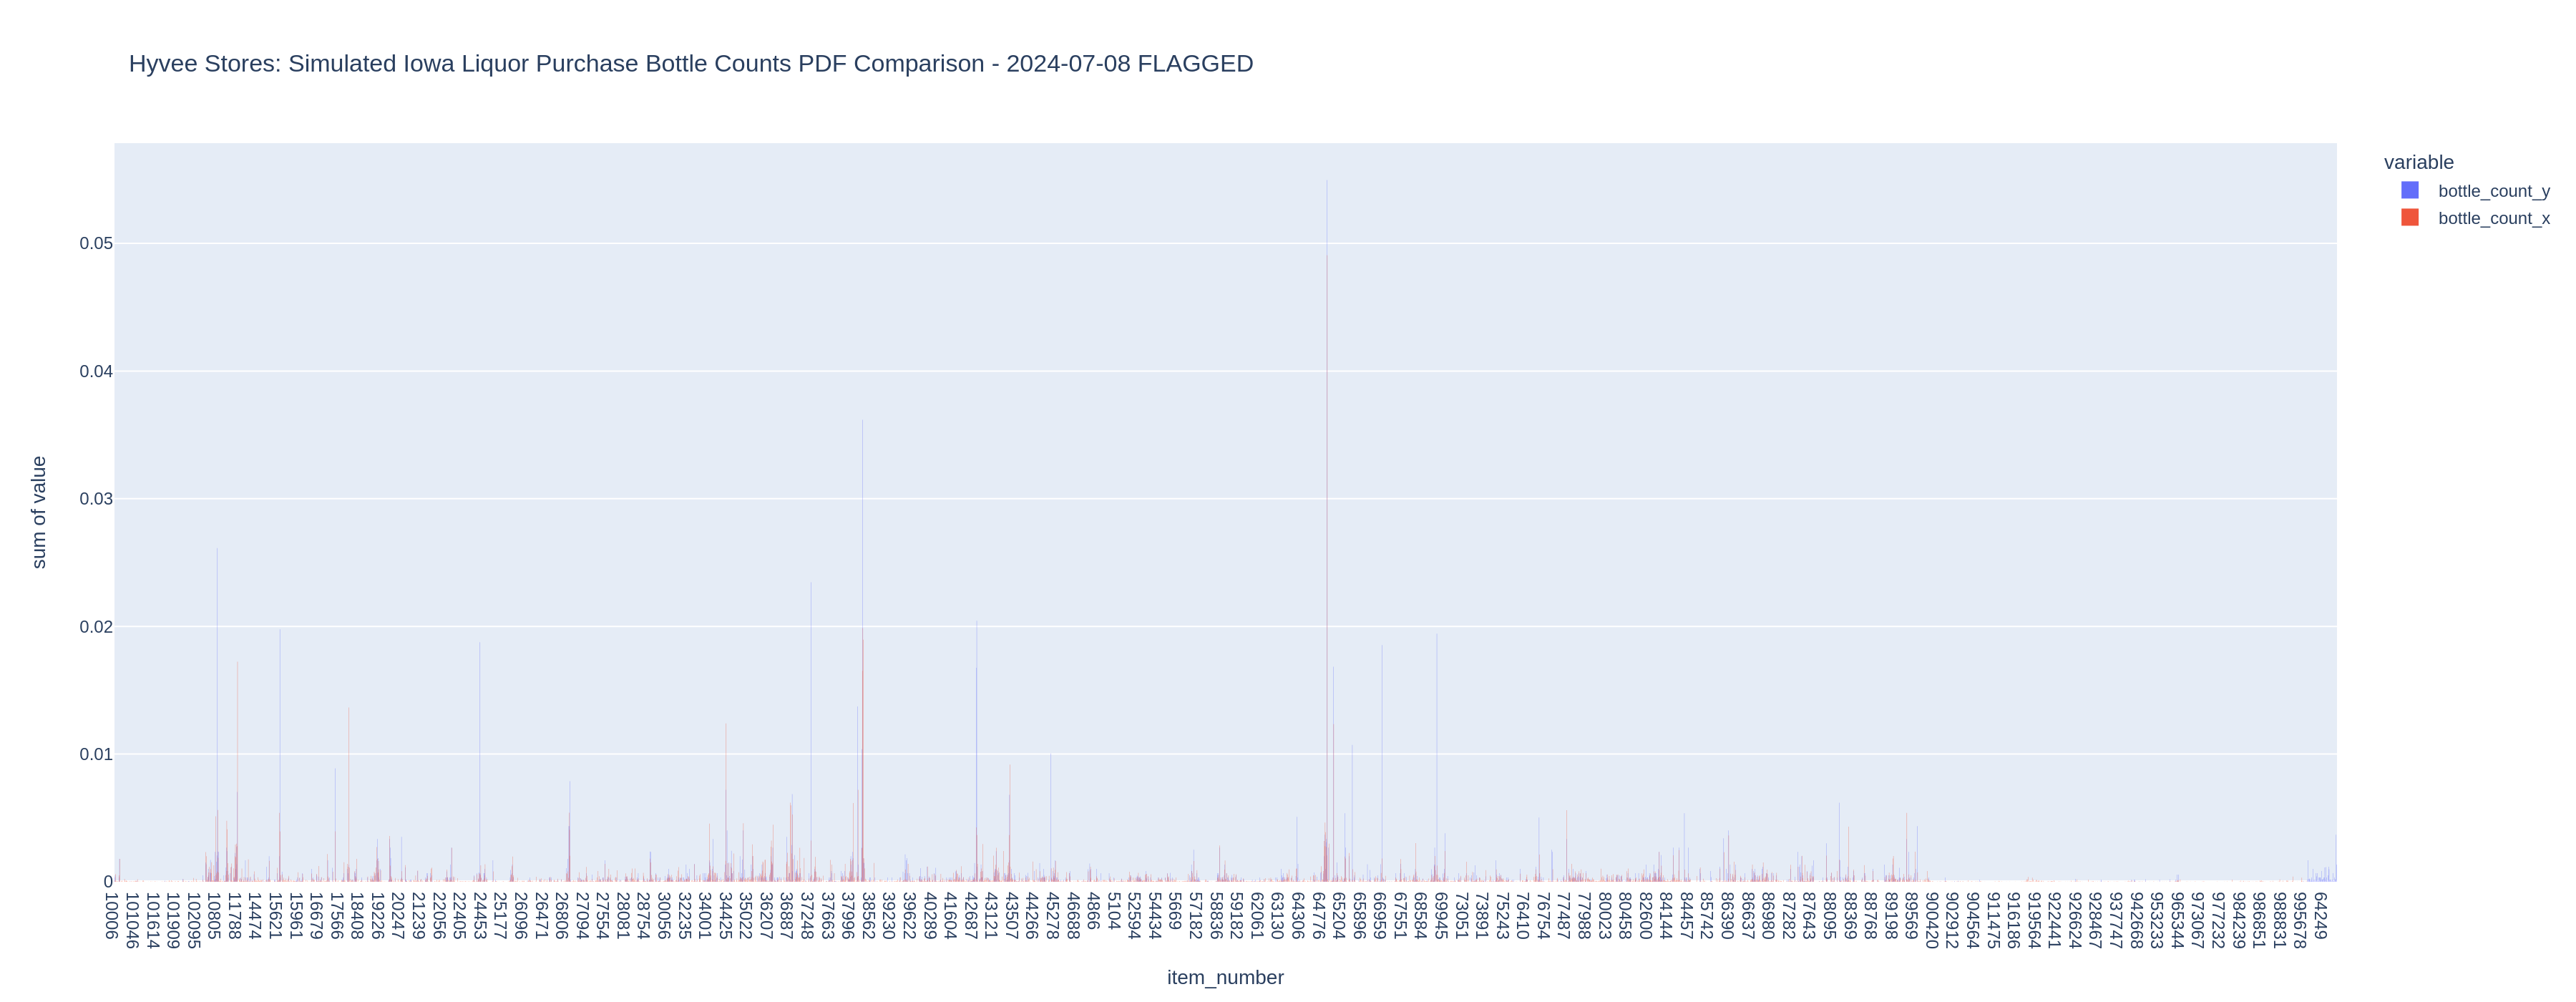

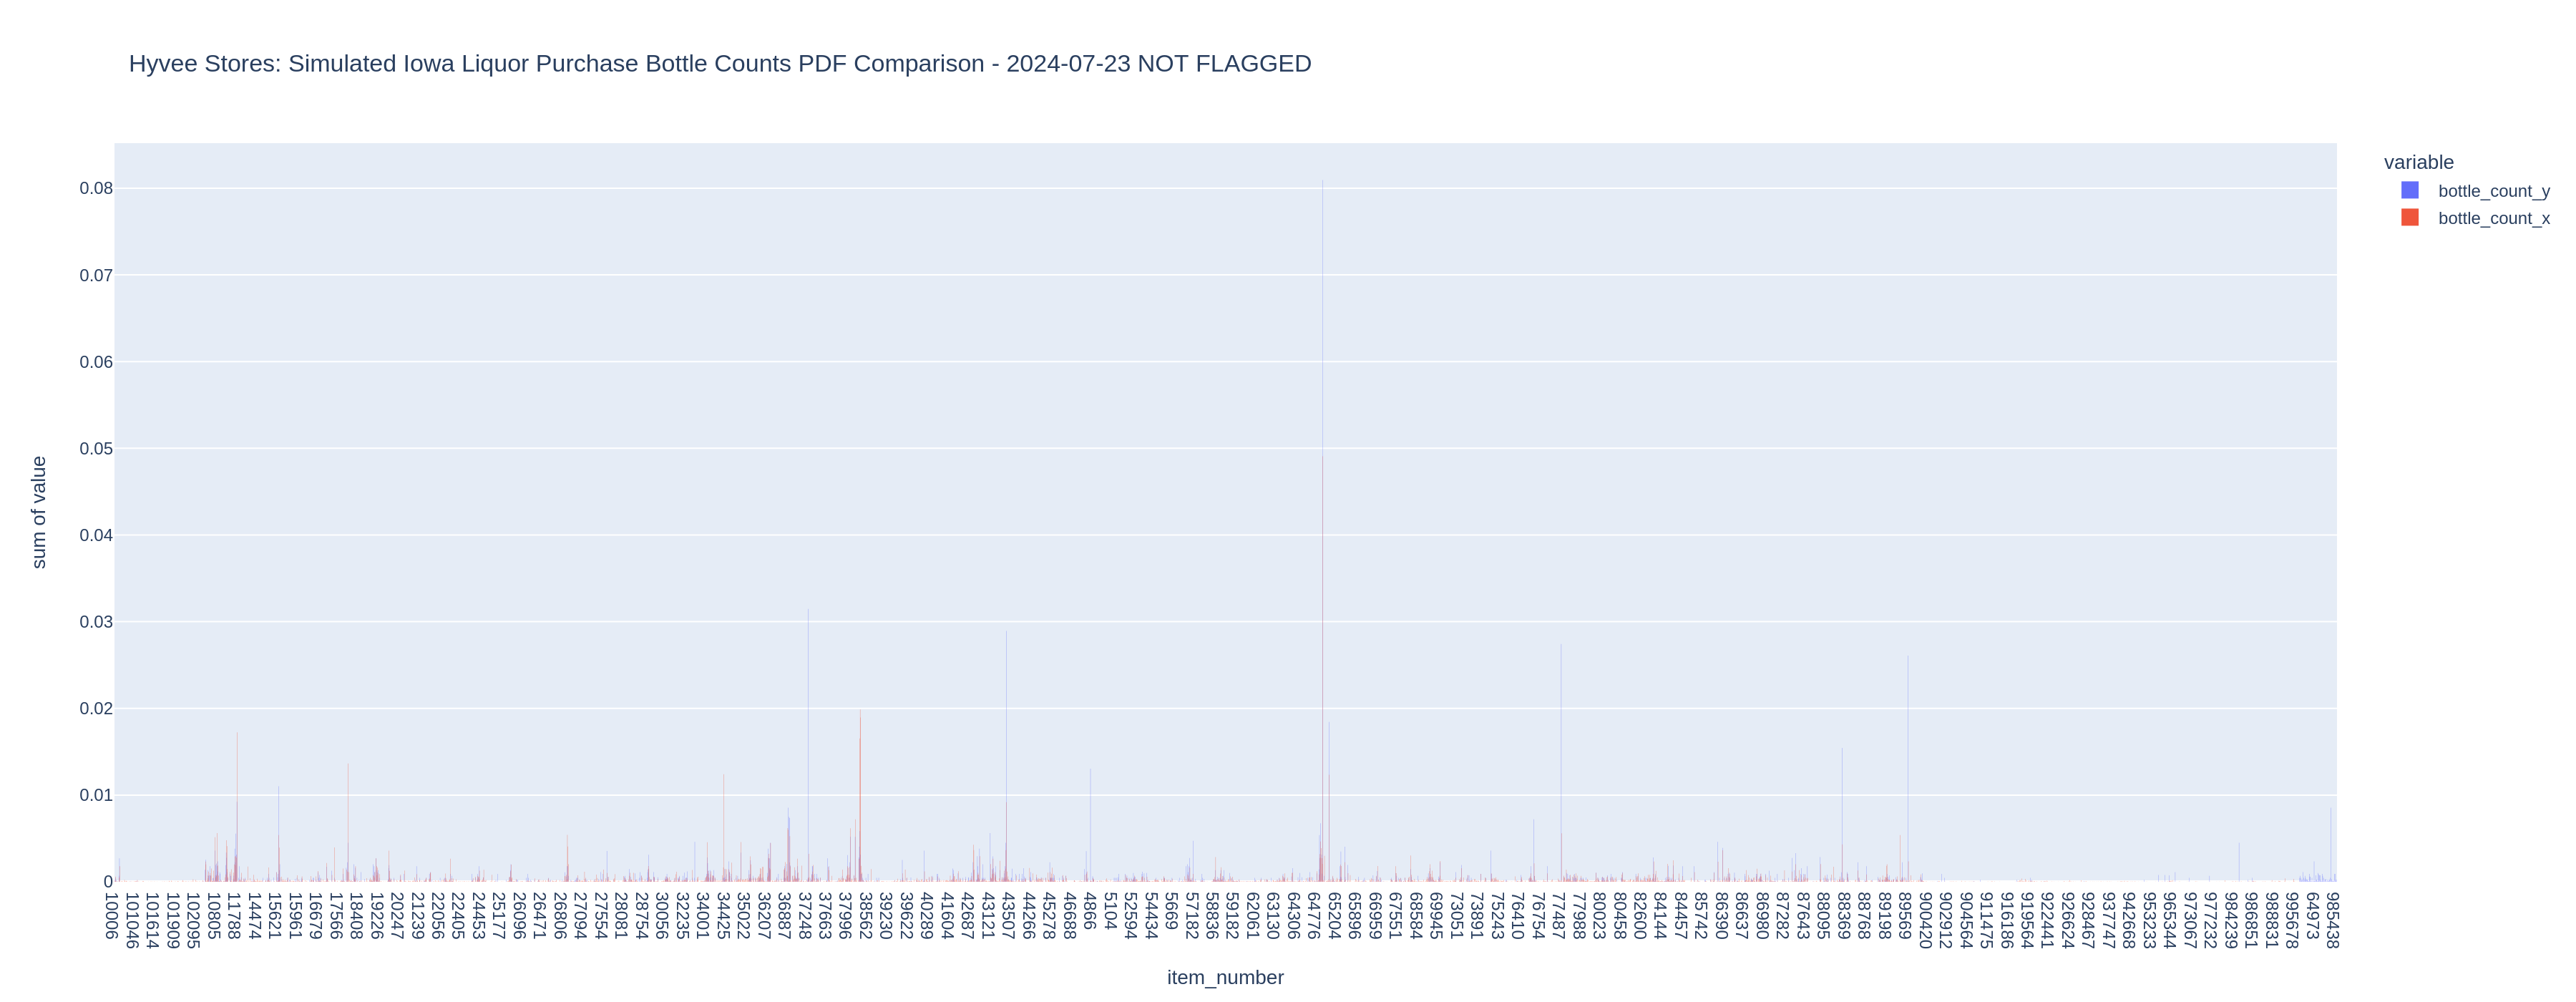

In [84]:
date_val = df_July2024.loc[7][0]

combined_distrs = get_distrs(data           = comparison_df,
                             filter_by_date = date_val,
                             baseline_data  = items_pdf_yr_2023,
                             feature_col    = "bottle_count",
                             join_col       = "item_number"
                            )

plot_simple_histogram(data   = combined_distrs,
                      x      = "item_number",
                      y      = ["bottle_count_y", "bottle_count_x"],
                      barmode="group",
                      template =None,
                      width    = 1800,
                      title    = f"Hyvee Stores: Simulated Iowa Liquor Purchase Bottle Counts PDF Comparison - {date_val} FLAGGED",
                      height   = 700,
                      as_image = True
)

##
date_val = df_July2024.loc[21][0]
combined_distrs = get_distrs(data           = comparison_df,
                             filter_by_date = date_val,
                             baseline_data  = items_pdf_yr_2023,
                             feature_col    = "bottle_count",
                             join_col       = "item_number"
                            )
plot_simple_histogram(data   = combined_distrs,
                      x      = "item_number",
                      y      = ["bottle_count_y", "bottle_count_x"],
                      barmode="group",
                      template =None,
                      width    = 1800,
                      title    = f"Hyvee Stores: Simulated Iowa Liquor Purchase Bottle Counts PDF Comparison - {date_val} NOT FLAGGED",
                      height   =700,
                      as_image = True
)

**Conclusions**

The charts above show one of the three flagged dates (top chart) and a date that was not flagged for comparison. Each chart compares the baseline distribution(bottle_count_x) to the distribution for the target date (bottle_count_y). Some subtle differences are noticeable, perhaps some peaks that are larger than expected in the middle of the "FLAGGED" chart. This could indicate some unexpected buying activity that may need some review. The same system could be used in a real time streaming platform such that the flagged dates are saved. The thresholds can also be adjusted accordingly such that they reflect desired severity levels for reporting.



#Windowing Functions:

Windowing functions are another way to smooth streaming data. By specifying a window and stride parameter, data can be aggregated from streams in a memory and computationally efficient way. The Class below includes some Windowing Functions with options for further compression with Delta Coding, such that data is saved and processed only when certain events occur.
The windowing parameters in this implementation can be based on both time and number of events.


In [85]:
#Inherits the PrepForStream Class for general Data Processing
class StreamingAnalytics(PrepForStream):
  def __init__(self, in_data,start_date, end_date, columns=filtered_cols):
    """
    Class SteamingAnalytics inherits PrepFor Streams
    """

    super().__init__(in_data,start_date, end_date, columns)

    self.delta_params     = None
    self.use_delta_coding = False

  def set_delta_coding(self, use_delta_coding):
      """
       Switch for delta coding
      """
      self.use_delta_coding = use_delta_coding


  def set_delta_params(self , delta_params:list[dict]):
      """
      This function sets the delta coding params attribute
      Params:
          - columns        :   list[str]        - the list of columns with values to be filtered
          - threshold      :   list[int, float] - the value of the delta threshold
          - thresh_operator:   list[str]        - the operator >,<,>=,<=
          - filter_stats   :   list[str]        - mean
      """

      ## check shapes of inputs
      if not (  len(delta_params[0]) == 4):
        raise ValueError("Each entry must have the same number of values.")

      self.delta_params = delta_params


  def window_stats(self,
                   window_size,
                   stride,
                   columns,
                   period_type = "time",
                   time_unit   = "min"):
      """
      This is a windowing function to for smoothing a stream of data.
      """
      if not time_unit in ['min', 'hr' 'day'] and period_type == "time":
        raise ValueError("Please use min, hr, or day for time_unit.")

      counts = None
      if period_type == 'time':
          ## start at the very begining of the day
          start = self.pre_df.txn_datetime.min()
          end   = start +  pd.Timedelta(window_size, time_unit)

          last_date      =  self.pre_df.txn_datetime.max().date()
          time_diff_mins = (self.pre_df.txn_datetime.max() - self.pre_df.txn_datetime.min())/pd.Timedelta(minutes=1)

          if time_unit   == 'min':
            time_diff_len   = time_diff_mins
          elif time_unit == 'hr':
            time_diff_len = time_diff_mins/60
          else:
            time_diff_len = time_diff_mins/(60 * 24)

          counts = (time_diff_len/stride ) if time_diff_len%stride == 0 else (int(time_diff_len/stride )) + 1
      else:

          start = 0
          end = window_size

          counts = (len(self.pre_df)/stride ) if len(self.pre_df)%stride == 0 else (int(len(self.pre_df)/stride )) + 1

      means_arr = None


      for i in range(counts):


        if period_type == 'time':

            time_filter = (self.pre_df.txn_datetime >= start) & (self.pre_df.txn_datetime <= end)
            mean = self.pre_df.loc[time_filter, columns].mean()

        else:

            mean = self.pre_df.loc[start:end-1, columns].mean()

        mean = mean.fillna(0)
        ## add the timeframe
        if self.use_delta_coding:
          for param in self.delta_params:

             if param["filter_stat"] == "mean":
                pass_mean = False

                if param['thresh_op'] == '>' :

                  pass_mean = True if mean.loc[param['column']] > param['threshold'] else False

                if param['thresh_op'] == '<'  :

                  pass_mean = True if mean.loc[param['column']] < param['threshold'] else False

                if param['thresh_op'] == '>=' :

                  pass_mean = True if mean.loc[param['column']] >= param['threshold'] else False

                if param['thresh_op'] == '<='  :

                  pass_mean = True if mean.loc[param['column']] <= param['threshold'] else False

                if not pass_mean: mean = None

        if mean is not None:
            mean = np.insert(mean.to_numpy().reshape([1,len(columns)]) , 0 , end.strftime('%s') ,  axis= 1)
            mean = np.insert(mean , 0 , start.strftime('%s') ,  axis= 1)



        ## append the new aggs
        if means_arr is not None:
            means_arr = np.append(means_arr, mean, axis=0)  if mean is not None else means_arr
        else:
            means_arr = mean if mean is not None else means_arr


        ## set new start and end times
        start = start  + pd.Timedelta(stride, time_unit)       if period_type == 'time' else start + stride
        end   = start  + pd.Timedelta(window_size, time_unit)  if period_type == 'time' else start  + window_size

      ## output as DataFrames
      df_columns = ["start", "end"] + columns if period_type != "time" else ["start_epoch", "end_epoch"] + columns


      means_out = pd.DataFrame(means_arr, columns =  df_columns)

      means_out[columns]=means_out[columns].fillna(0)


      del means_arr

      return means_out

streamer = StreamingAnalytics(in_data    = comparison_df
                             ,start_date = '2024-01-01',
                              end_date   = '2024-01-31'
)



In [86]:
## Check for values less than zero. In this case they are nor necessary for this analysis
streamer.pre_df[streamer.pre_df.purchase_dollars <0]

Empty DataFrame
Columns: [txn_datetime, date, store_number, vendor_number, item_number, bottles_purchased, purchase_dollars]
Index: []

In [87]:
streamer.pre_df.tail()

txn_datetime        date store_number vendor_number item_number  \
769194 2024-01-31 17:59:00  2024-01-31         2521           434       45278   
769195 2024-01-31 17:59:00  2024-01-31         2521           434       41846   
769196 2024-01-31 17:59:00  2024-01-31         2521           434       36305   
769197 2024-01-31 17:59:00  2024-01-31         2521           434       45248   
769198 2024-01-31 17:59:00  2024-01-31         2521           434       18201   

        bottles_purchased  purchase_dollars  
769194                  6              72.0  
769195                 12             162.0  
769196                 12              63.0  
769197                  6              72.0  
769198                  6             121.5

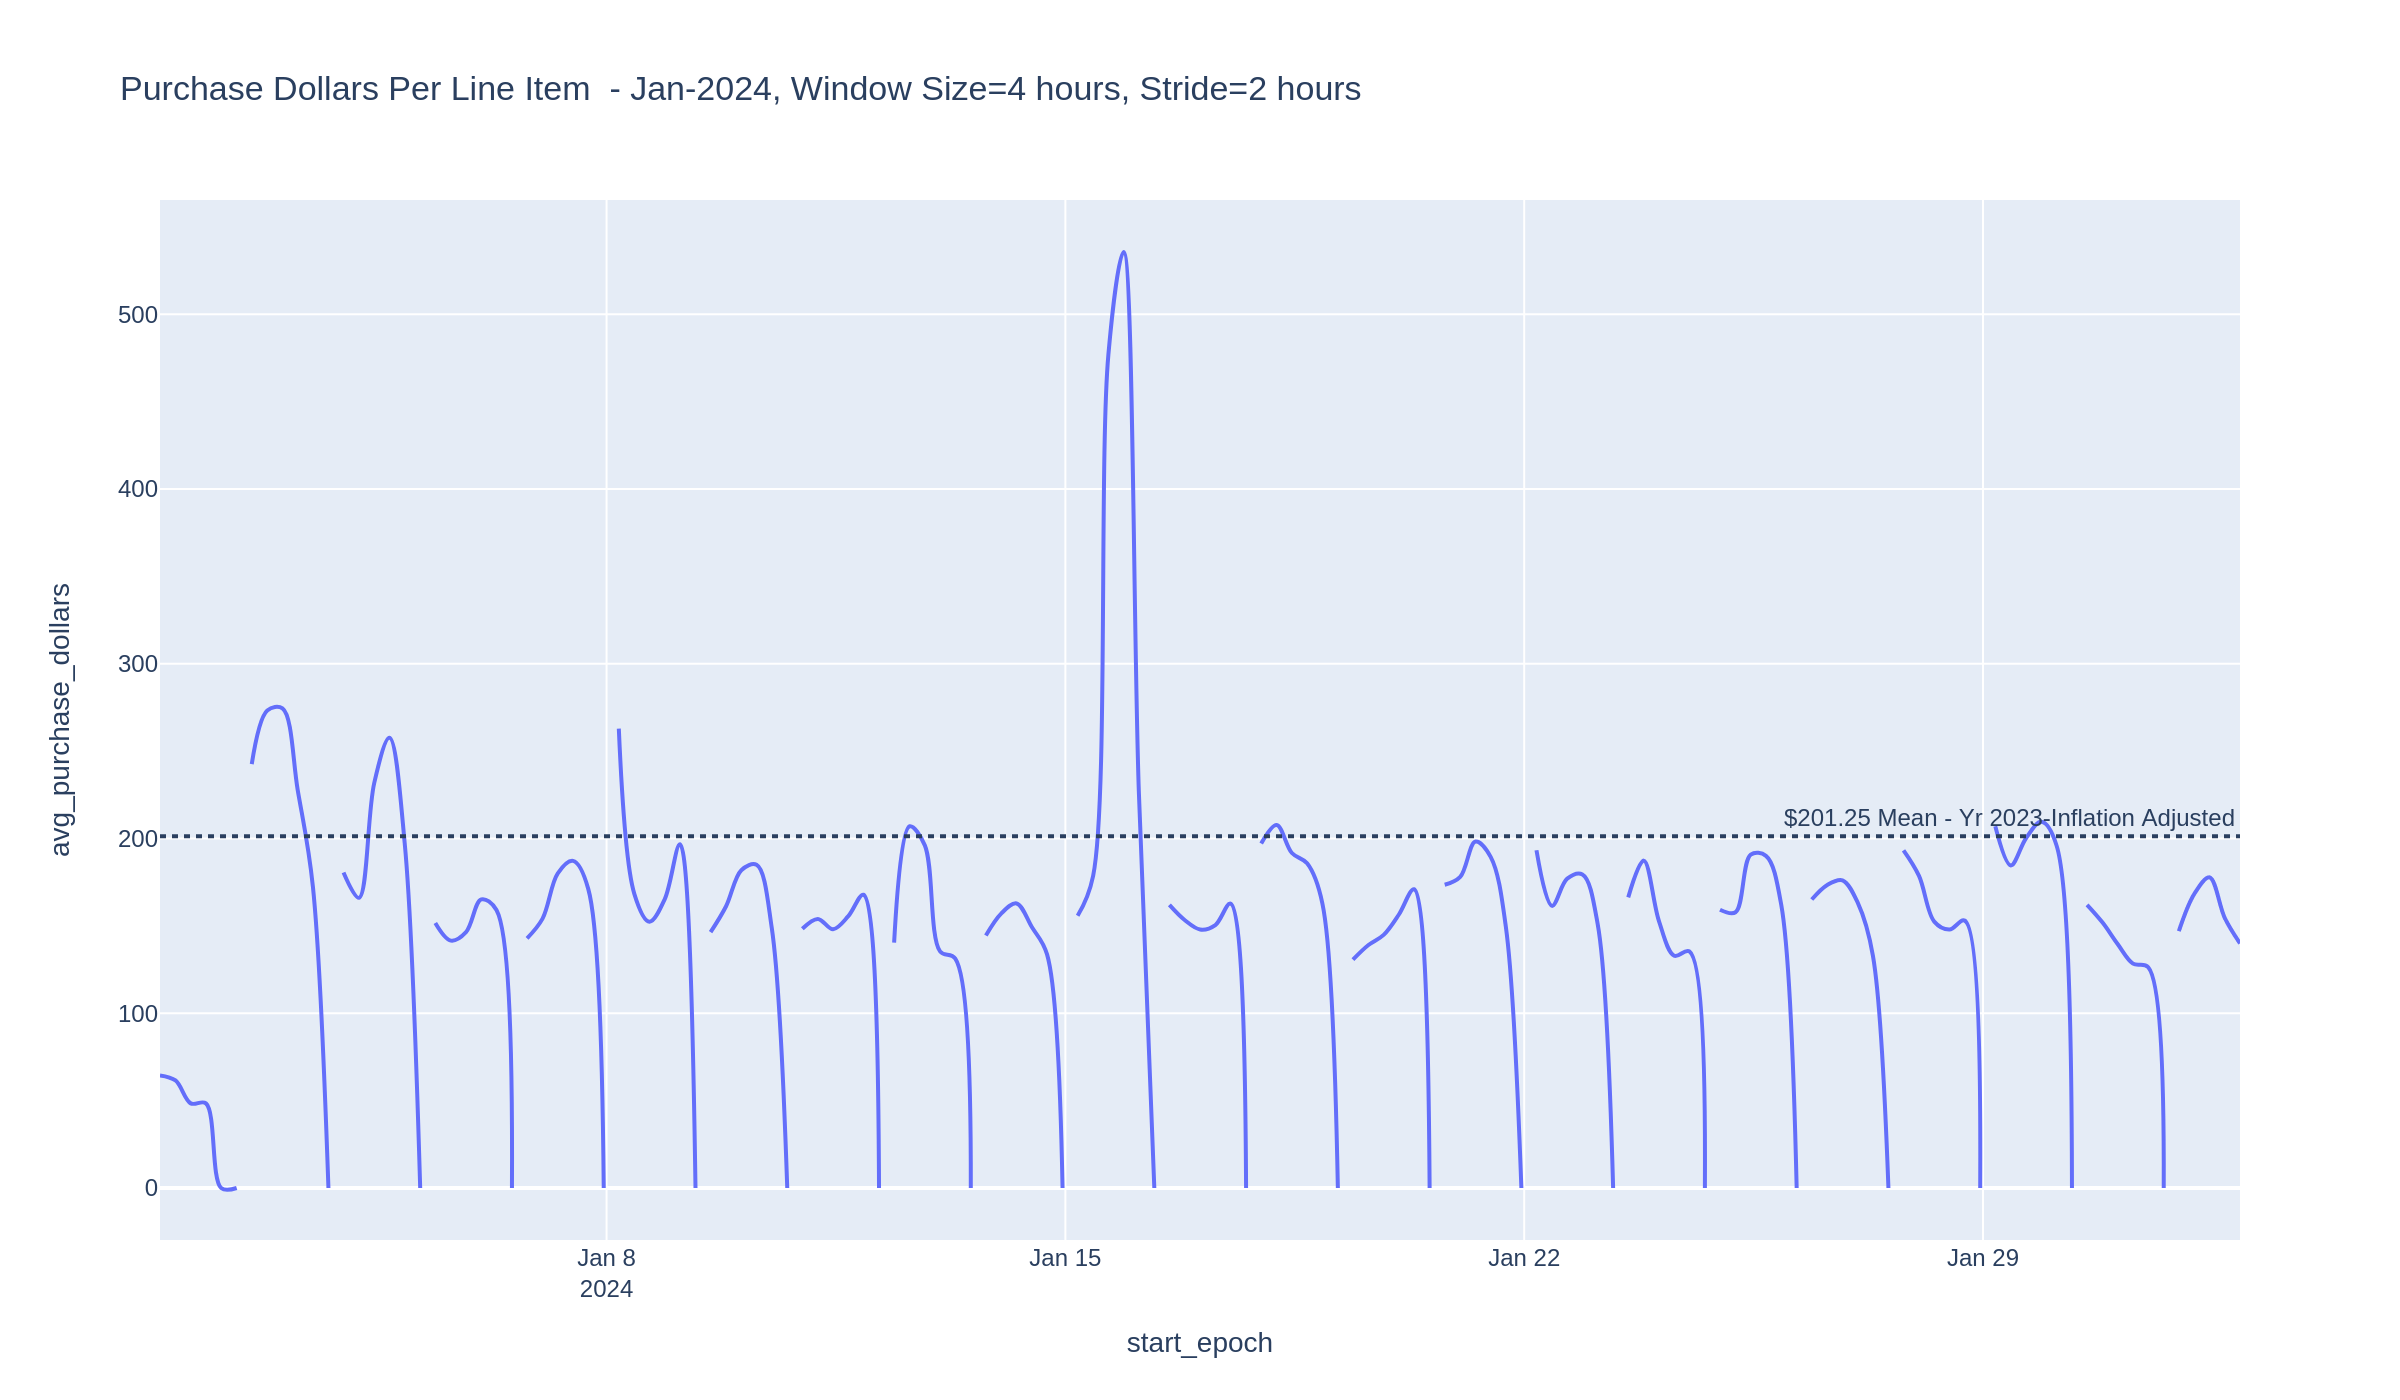

In [88]:
inflation_adj = 0.031
mean_yr_2023 = comparison_df.purchase_dollars.mean() + (comparison_df.purchase_dollars.mean() * inflation_adj)

means   = streamer.window_stats(stride      = 2*60,
                                window_size = 4*60,
                                period_type  ="time",
                                columns= ["bottles_purchased", "purchase_dollars"]
                               )

means["start_epoch"] = pd.to_datetime(means["start_epoch"], unit="s")
means["end_epoch"]   = pd.to_datetime(means["end_epoch"]  , unit="s")
means.rename(columns = {"bottles_purchased" : "avg_bottles_purchased", "purchase_dollars" : "avg_purchase_dollars"}, inplace=True)
fig= px.line(means, x="start_epoch",
                    y="avg_purchase_dollars",
                    line_shape='spline',
                    title='Purchase Dollars Per Line Item  - Jan-2024, Window Size=4 hours, Stride=2 hours')
fig.update_xaxes(
        rangebreaks=[
            dict(bounds=["sat", "mon"]),
            dict(bounds=[19, 7], pattern="hour"), #hide non-business hours

        ]
    )

fig.add_hline(y= mean_yr_2023, line_dash="dot",
              annotation_text=f"${round(mean_yr_2023, 2)} Mean - Yr 2023-Inflation Adjusted",
              annotation_position="top right")

Image(fig.to_image(format="png", width= 1200, height= 700,scale=2))


The Windowing Function Above is compared to the previous year's inflation adjusted average. This can be used as an indication of an anomaly in any of the 4 hour periods. A few of the 4 hour periods exceed that threshold. The next section uses delta encoding to collect only the 4 hour windows with averages that exceed the threshold.

**Window Function with Delta Encoding:**

The following implemetation only reports data when the mean of the window exceeds a set threshold. This could be useful if teams only needs updates when buying activity for any window/rolling period exceeds or dips below set Threshold .

In [89]:
#Enable Delta Encoding
delta_thresh = mean_yr_2023 + (0.2 *mean_yr_2023)
delta_params = [{"filter_stat" :"mean",
                 "column" :"purchase_dollars",
                 "thresh_op" :">" ,
                 "threshold" : delta_thresh }
               ]

streamer = StreamingAnalytics(in_data    = comparison_df
                             ,start_date = '2024-01-01',
                              end_date   = '2024-01-31'
)

streamer.set_delta_coding(use_delta_coding =True)
streamer.set_delta_params(delta_params)

means_w_delta  = streamer.window_stats(stride = 2*60,
                                    window_size = 4*60,
                                    period_type="time",
                                   columns= ["bottles_purchased", "purchase_dollars"]
                               )
means_w_delta.head(30)

start_epoch   end_epoch  bottles_purchased  purchase_dollars
0  1704184620  1704199020          14.334465        242.544304
1  1704191820  1704206220          14.546610        273.235331
2  1704199020  1704213420          14.843718        274.401246
3  1704292620  1704307020          15.245455        257.632530
4  1704695820  1704710220          20.337001        311.355034
5  1704703020  1704717420          16.630222        262.867218
6  1705322220  1705336620          26.930683        476.789990
7  1705329420  1705343820          30.735849        535.601380
8  1705984620  1705999020          17.529412        262.944853

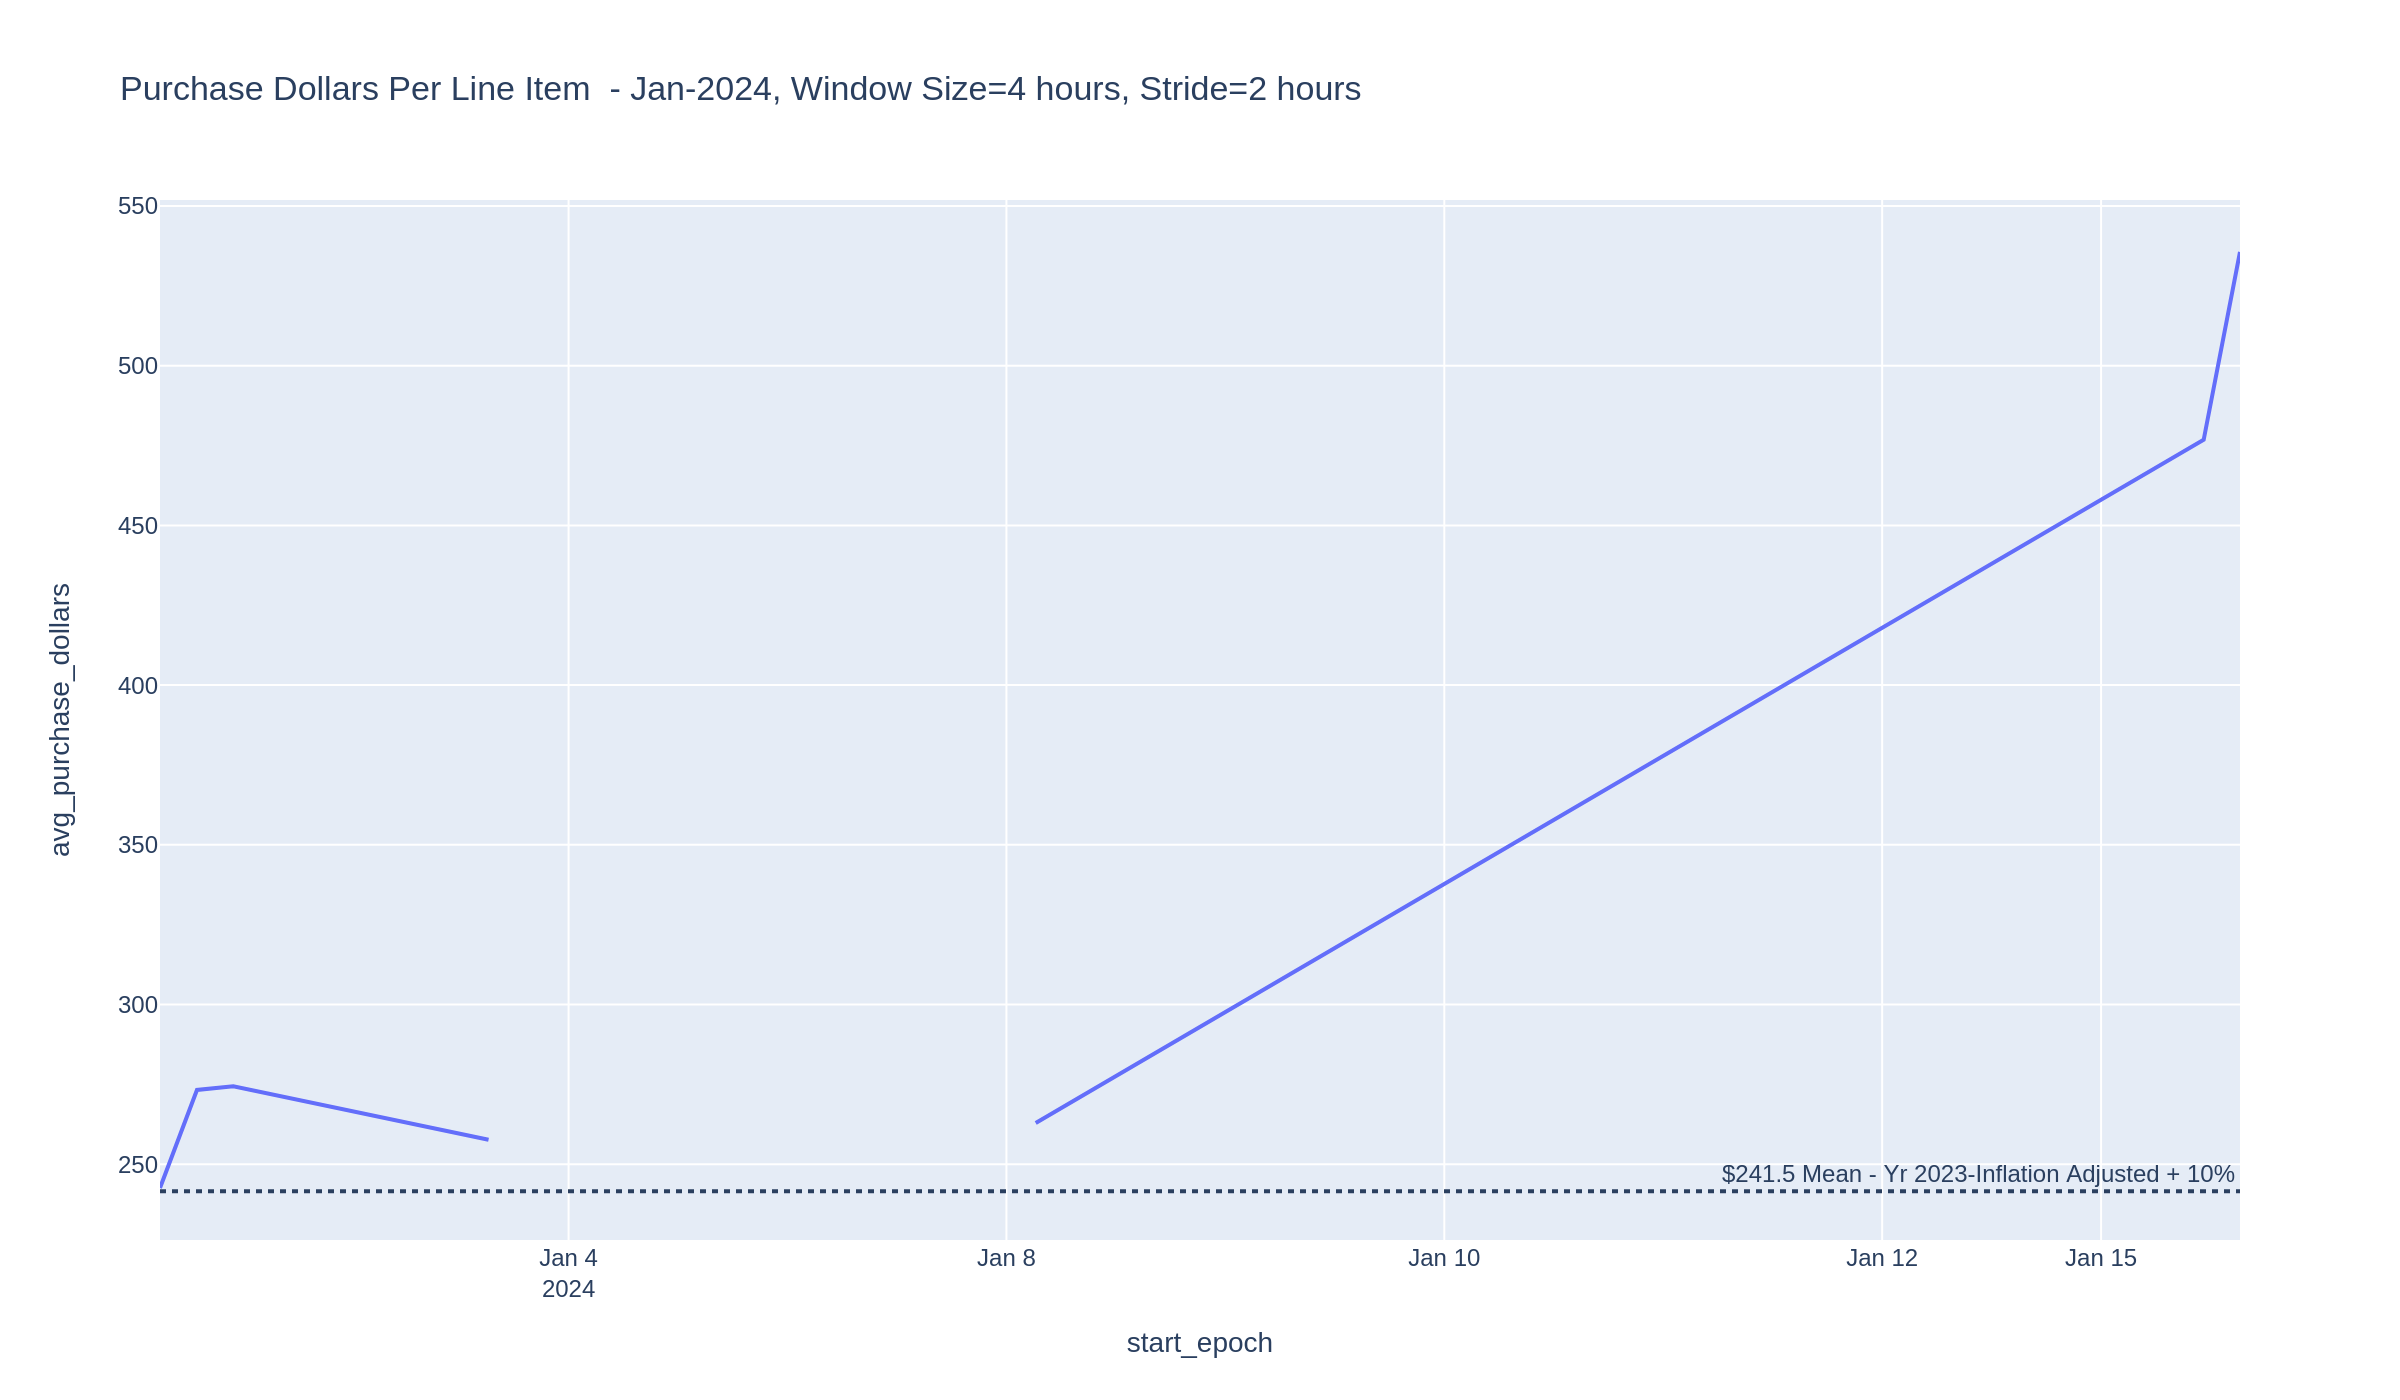

In [90]:
np.random.seed(1)
means_w_delta   = streamer.window_stats(stride      = 2*60,
                                        window_size = 4*60,
                                        period_type  ="time",
                                        columns= ["bottles_purchased", "purchase_dollars"]
                               )

means_w_delta["start_epoch"] = pd.to_datetime(means_w_delta["start_epoch"], unit="s")
means_w_delta["end_epoch"]   = pd.to_datetime(means_w_delta["end_epoch"]  , unit="s")
means_w_delta.rename(columns = {"bottles_purchased" : "avg_bottles_purchased", "purchase_dollars" : "avg_purchase_dollars"}, inplace=True)
fig= px.line(means_w_delta, x="start_epoch",
                    y="avg_purchase_dollars",
                    title='Purchase Dollars Per Line Item  - Jan-2024, Window Size=4 hours, Stride=2 hours')
fig.update_xaxes(
        rangebreaks=[
            dict(bounds=["sat", "mon"]),
            dict(bounds=[19, 7], pattern="hour"), #hide non-business hours

        ]
    )

fig.add_hline(y= delta_thresh, line_dash="dot",
              annotation_text=f"${round(delta_thresh, 2)} Mean - Yr 2023-Inflation Adjusted + 10%",
              annotation_position="top right")
Image(fig.to_image(format="png", width= 1200, height= 700,scale=2))

With Delta Encoding, there are much fewer periods reported, as shown by the smoother curve in the chart, resulting in less memory and computation of from data processing and reporting, in addition to meeting the requirement for reporting based on the specified criteria. This can be a fast way to identify increased resource needs at the affected parts of the organization, allowing leaders to respond faster.



# Exponential Smoothing and Forecasting

This section utilizes the Statsmodels package to model Exponential Smoothing using various methods and hyperparameters.  

In [91]:
## initialize the streamer package for the target date range
streamer = StreamingAnalytics(in_data    = comparison_df
                             ,start_date = '2023-01-02',
                              end_date   = '2024-12-31'
)

**Reporting Intervals**

To run analysis on the data, this assumes that aggregates are calculated on a fixed interval. The streaming aggregates are applied at hourly and daily intervals.  Additionally, the function below can be used for daily and minutely intervals. However, this analysis will focus on hourly aggregations.

In [92]:
cols_list = ["txn_datetime","date", "store_number", "vendor_number", "bottles_purchased", "purchase_dollars"]
aggs_dict = {"bottles_purchased": "sum", "purchase_dollars" :"sum"}

def groupby_timeframe( data,by, cols, aggs_dict):
  """
   Function to group data by timeframe
   Params:
      data      - DataFrame of the target
      by        - date columns for aggregation
      columns   - the subset of columns to get from the the supplied data
      aggs_dict - Dictionary of aggegrates for the .agg portion of the .groupby expression
  """
  by = by.lower().strip()
  ord_totals = None

  if  by in ["date", "day", "daily"] :

    date_col = "date"
    ord_totals  = data[cols].groupby([date_col]).agg(aggs_dict)

  if by in ["hr","hour", "hourly", "1hr" ]:

    date_col = "hr"
    cols.append(date_col)

    if  "hr" in data.columns: data.drop(columns="hr")
    data["hr"]    = pd.to_datetime(data.txn_datetime.dt.strftime('%Y%m%d%H'), format='%Y%m%d%H')

    ord_totals  = data[cols].groupby([date_col]).agg(aggs_dict)

  if by in ["min", "minute", "1min", "minutely"] :
    date_col = "min"
    cols.append(date_col)

    if  "min" in data.columns: data.drop(columns="min")

    data["min"]   = pd.to_datetime(data.txn_datetime.dt.strftime('%Y%m%d%H%M') , format='%Y%m%d%H%M')
    ord_totals  = data[cols].groupby(["min"]).agg(aggs_dict)

  ord_totals.reset_index( inplace=True)

  return date_col, ord_totals


In [93]:
date_col, order_totals = groupby_timeframe(streamer.pre_df, "hr", cols_list, aggs_dict)
order_totals.head()

hr  bottles_purchased  purchase_dollars
0 2023-01-02 08:00:00                 43            487.05
1 2023-01-02 09:00:00                 81            1323.3
2 2023-01-02 10:00:00                116           2244.69
3 2023-01-02 11:00:00                 29            767.88
4 2023-01-02 12:00:00                133           1789.47

The next two functions below assign dates in the future to forecast data. This is mainly done to keep the charts date axis in line with expected business hours.

In [94]:

x = order_totals[date_col]

def get_fcast_times(x, fcast_periods, date_col, num_day_hrs = 10):

    raw_fcast_times = pd.Series([(x.loc[len(x)-1] +pd.Timedelta(hours=a)) for a in range(1,fcast_periods+1)])


    ## handle_current_date by removing adding any of the current_day_forevast values
    times_same_day = raw_fcast_times[ (raw_fcast_times.dt.strftime("%Y%m%d")== x.loc[len(x)-1].strftime("%Y%m%d")) & \
                                       (raw_fcast_times.dt.strftime("%H").astype(int) <=17)]

    ##remove handled periods
    if len(times_same_day) > 0 :
      raw_fcast_times  = raw_fcast_times[~(raw_fcast_times.isin(times_same_day))]
      raw_fcast_times.reset_index(drop=True, inplace=True)


    num_fcast_days = len(raw_fcast_times)/num_day_hrs if len(raw_fcast_times)%num_day_hrs ==0 else round(len(raw_fcast_times)//num_day_hrs) + 1
    num_fcast_days = int(num_fcast_days)

    new_dates = [pd.to_datetime(x.loc[len(x)-1].strftime('%Y%m%d'), format= '%Y%m%d') +  pd.Timedelta(days=d)  for d in range(1,num_fcast_days+1)]
    new_raw = raw_fcast_times


    for idx, new_date in enumerate(new_dates):
          start =  idx * num_day_hrs

          if (idx + 1) == len(new_dates) and len(new_raw)%num_day_hrs > 0 :
              end = start + (len(new_raw)%num_day_hrs) -1
              num_day_hrs = (len(new_raw)%num_day_hrs)

          else:
            end   =  start + (num_day_hrs-1)

          new_raw.loc[start:end] = [new_date + pd.Timedelta( hours= 8 + h ) for h in range(0,num_day_hrs)]


    if len(times_same_day) > 0:
      x_out = pd.concat([times_same_day, new_raw], ignore_index=True)
    else:
      x_out = new_raw
    return x_out



fcast_dates = get_fcast_times(x, fcast_periods =100  , date_col = "hr", num_day_hrs = 10)

This function offsets hourly timestamps originally set on weekends to Mondays or Tuesdays, while offsetting the result of of the dates so every timestamp is unique.

In [95]:
def remove_weekends(fcast_dates):

    filter = (fcast_dates.dt.day_name().isin(["Saturday", "Sunday"]))
    target_dates= fcast_dates[filter]
    counter = 0

    while len(target_dates) > 0 :

        new_dates  = target_dates + pd.Timedelta(days=2)
        orig_weekdays_offset = len(new_dates.dt.day_name().unique())


        # Move Saturday to Monday if only Saturday
        if orig_weekdays_offset ==1:

          if new_dates.dt.day_name().unique() == 'Saturday':
            target_dates_offset = 2
          else:
            target_dates_offset = 1
        else:
          target_dates_offset = orig_weekdays_offset

        fcast_dates.loc[fcast_dates >= new_dates.min() ] = fcast_dates.loc[fcast_dates >= new_dates.min() ] + pd.Timedelta(days=orig_weekdays_offset)
        fcast_dates.loc[target_dates.index] = fcast_dates.loc[target_dates.index] + pd.Timedelta(days=target_dates_offset)
        target_dates= fcast_dates[fcast_dates.dt.day_name().isin(["Saturday", "Sunday"])]

        counter+=1
        if counter >100:
          raise ValueError("Too many weekend date offset iterations. Consider Reducing the length of the forecast")
          break


    return fcast_dates

fcast_dates = remove_weekends(fcast_dates)

In [96]:
print(f"Highest Number of rows per datetime (uniqueness check): {fcast_dates.value_counts().max()}")

Highest Number of rows per datetime (uniqueness check): 1


In [97]:
# Check the dates
fcast_dates.head(10)

0   2024-08-01 08:00:00
1   2024-08-01 09:00:00
2   2024-08-01 10:00:00
3   2024-08-01 11:00:00
4   2024-08-01 12:00:00
5   2024-08-01 13:00:00
6   2024-08-01 14:00:00
7   2024-08-01 15:00:00
8   2024-08-01 16:00:00
9   2024-08-01 17:00:00
dtype: datetime64[ns]

**Simple Exponential Smoothing**

This section uses the Simple Exponential Smoothing function from the StatsModels package. This is a first order implementation that takes ${Alpha}$, the Decay Constant as a parameter. The idea behind exponential smoothing is that past values become less important the further back are from present time.
The smaller the value of ${Alpha}$ or the ${smoothing-level}$, the larger the smoothing effect. A hyperparameter search will be used to determine the best outcome for this data.
The idea is to use the last two week's data, or last 100 hours to forecast data for the next 1 to 5 days.  In this case, both bottles_purchased and purchase_dollars can  be used,  but this method can be used for any numeric data .
Since we are assuming only the use of the last 100 data points to 1000 data points at a time, this also works well for streaming analytics because of the relatively low memory and computational requirements.
To evaluate the models, the Root Mean Squared Error will be used. The StasModels classes in this implementation provide the Sum of Squared Errors value. However, a simple custom function will be used here to calculate the Root Mean Squared Error since that outcome is more aligned with the original units of the data, and therefore easier to interpret.

See https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html for reference.



In [98]:
# This returns the Root Mean Squared Error of the Smoothing Algorithm
def get_rmse(sse, n ):
  return (sse/n)**0.5


**Initial Hyper-Parameter Search**

Initially, all possible hyperparameters will be combined. Depending on the efficiency of the process, random selection might be used to sample the combinations, otherwise all combinations of parameters will be used.



In [99]:
def get_simpleexp_sm(  data,
                       smoothing_params = [],
                       fcast_periods=5,
                       optimized=False ):

    fits   = [ SimpleExpSmoothing(data,
                                  initialization_method=p[0]) \
               .fit( smoothing_level= p[1], optimized= optimized) for p in smoothing_params
             ]

    fcasts   = [fit.forecast(fcast_periods) for fit in fits]

    fit_rmse = [get_rmse(fit.sse, len(fit.fittedvalues)) for fit in fits ]

    return fits, fcasts , fit_rmse


**Plots of Best and Worst Outcomes with Simple/First Order Exponential Smoothing**

In [100]:
def plot_smoothing_lines(x, y,
                         fitted_obj,
                         forecast_obj,
                         title,
                         show_forecast=True,
                         as_image=True,
                         image_width  = 1800,
                         image_format = "png",
                         image_scale  = 2.0):
    # Create traces
    fig = go.Figure(  layout=go.Layout(
                                      title=go.layout.Title(text=title)
                                        )
                   )

    alpha = fitted_obj.params["smoothing_level"]
    beta  = fitted_obj.params["smoothing_trend"]

    smoothed_name =  f'alpha={alpha} , \n beta={beta}'



    fig.add_trace(go.Scatter(x=x, y=y,
                        mode='lines+markers',
                        name='Original Series'))

    fig.add_trace(go.Scatter(x=x, y=fitted_obj.fittedvalues,
                        mode='lines',
                        name=f'{smoothed_name}'))

    if show_forecast:
        fcast_dates = get_fcast_times(x, len(forecast_obj), "hr",10)
        fcast_dates = remove_weekends(fcast_dates)
        fig.add_trace(go.Scatter(x=fcast_dates,
                                y=forecast_obj,
                                mode='lines+markers',
                                name=f'Forecast'))

    fig.update_xaxes(
        rangebreaks=[
            dict(bounds=["sat", "mon"]),
            dict(bounds=[23, 7], pattern="hour"), #hide hours

        ]
    )

    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))

    if as_image:
      img = Image(fig.to_image(format=image_format, width = image_width, scale = image_scale))
      return img
    else:
      fig.show()


This function will display the best and worst performing plots based on rmse for the selected Criteria.

In [101]:
from IPython.display import display

def show_best_worst(x, y, fits, fcasts, smoothing_params, rmse, title_prefix='', best_only = False):

    print("Min RMSE: " ,np.min(rmse))
    print("Max RMSE: ", np.max(rmse))

    best_idx = np.argmin(rmse)
    worst_idx = np.argmax(rmse)

    print(f"Best Params :  {smoothing_params[best_idx]}, idx={best_idx}")
    print(f"Worst Params: {smoothing_params[worst_idx]}, idx={worst_idx}")

    display(plot_smoothing_lines(x, y, fits[best_idx], fcasts[best_idx], title   = f"{title_prefix} Best- RMSE"))
    if not best_only:
      display(plot_smoothing_lines(x, y, fits[worst_idx],fcasts[worst_idx], title = f"{title_prefix} Worst- RMSE"))

    return best_idx, worst_idx

For simplicity, this will assume that every business day is always 10 hours, excluding weekends. The data is further limited so analysis can be done for the last 100 hours, which equates to 2-week intervals.

In [102]:
import itertools
np.random.seed(265)
smoothing_alphas = np.random.uniform(0.1,0.9, 20)
smoothing_alphas
init_methods     = ["estimated", "heuristic"]
params           = [init_methods, smoothing_alphas]
smoothing_params = list(itertools.product(*params))
print(f"Number of Combinations {len(list(smoothing_params))}" )

Number of Combinations 40


In [103]:
limit = 150
y                   = order_totals.purchase_dollars.loc[0:limit-1].tolist()
x                   = order_totals.hr.loc[0:limit-1]

fits,fcasts, fit_rmse = get_simpleexp_sm( data = y,
                                          smoothing_params= smoothing_params,
                                          fcast_periods=10,
                                          optimized    =False

                )



Min RMSE:  19326.66708449149
Max RMSE:  22623.63233547938
Best Params :  ('estimated', 0.5175382677788276), idx=0
Worst Params: ('estimated', 0.11600532668286637), idx=3


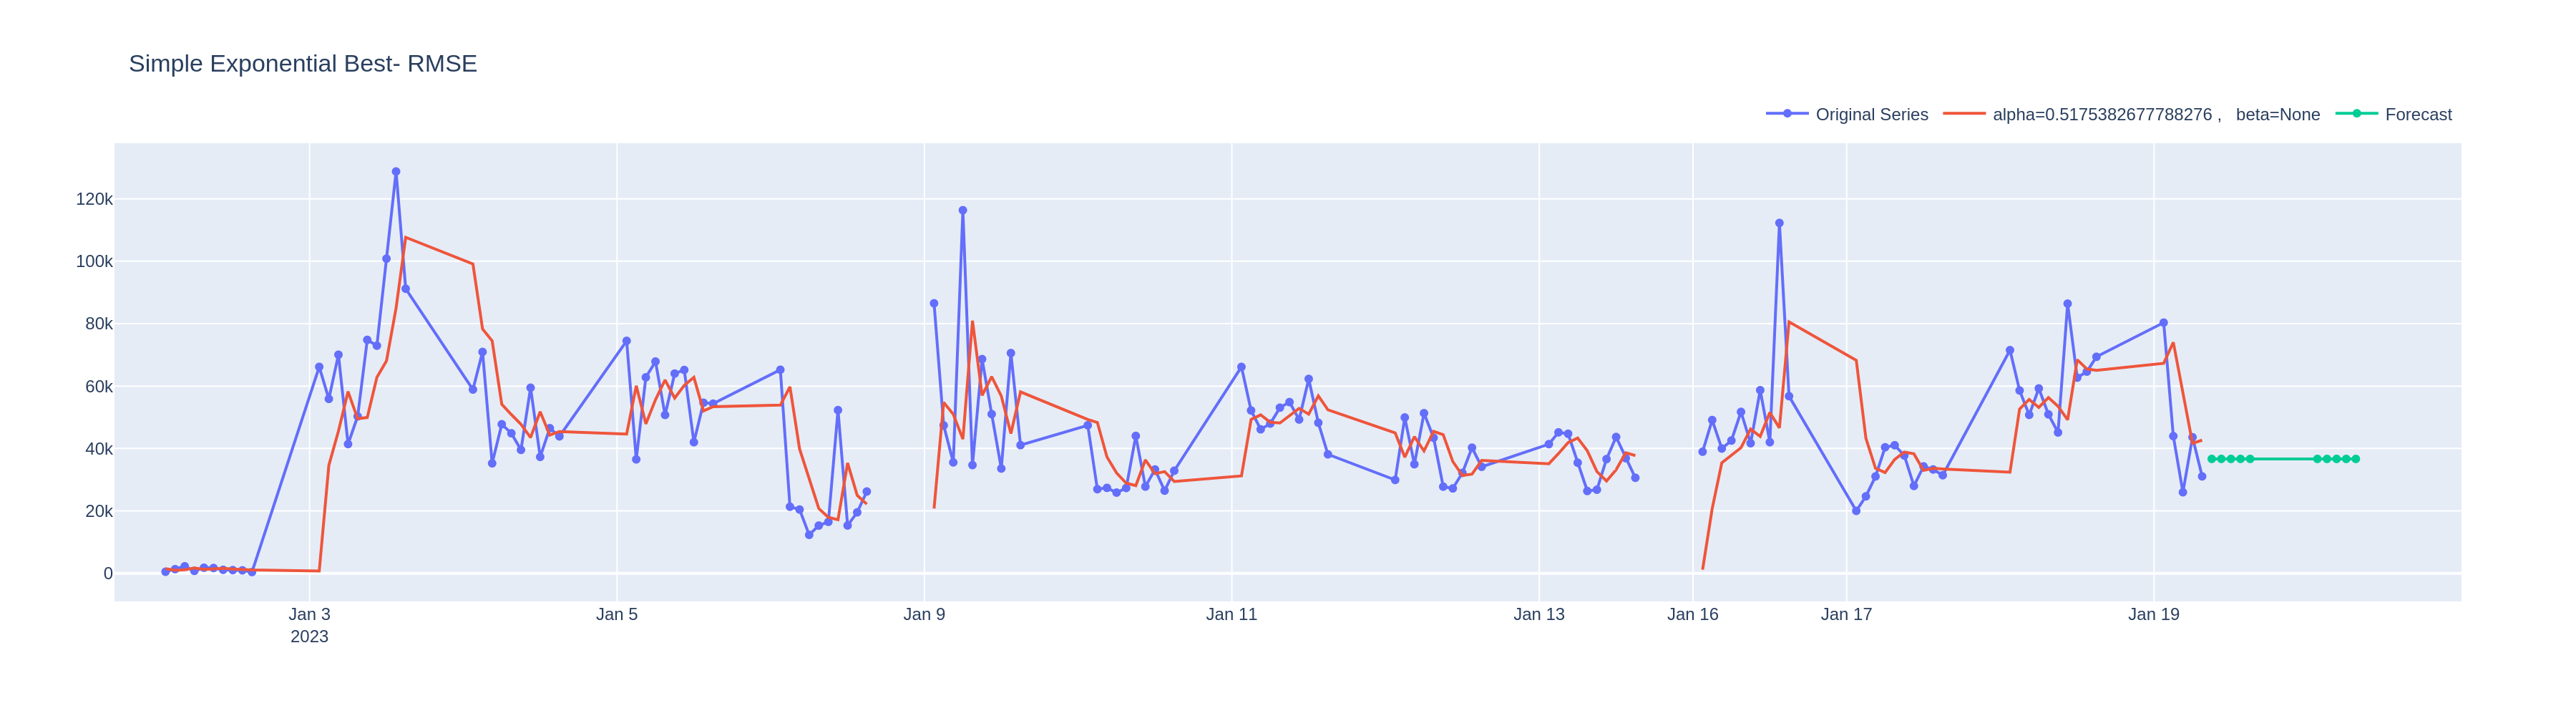

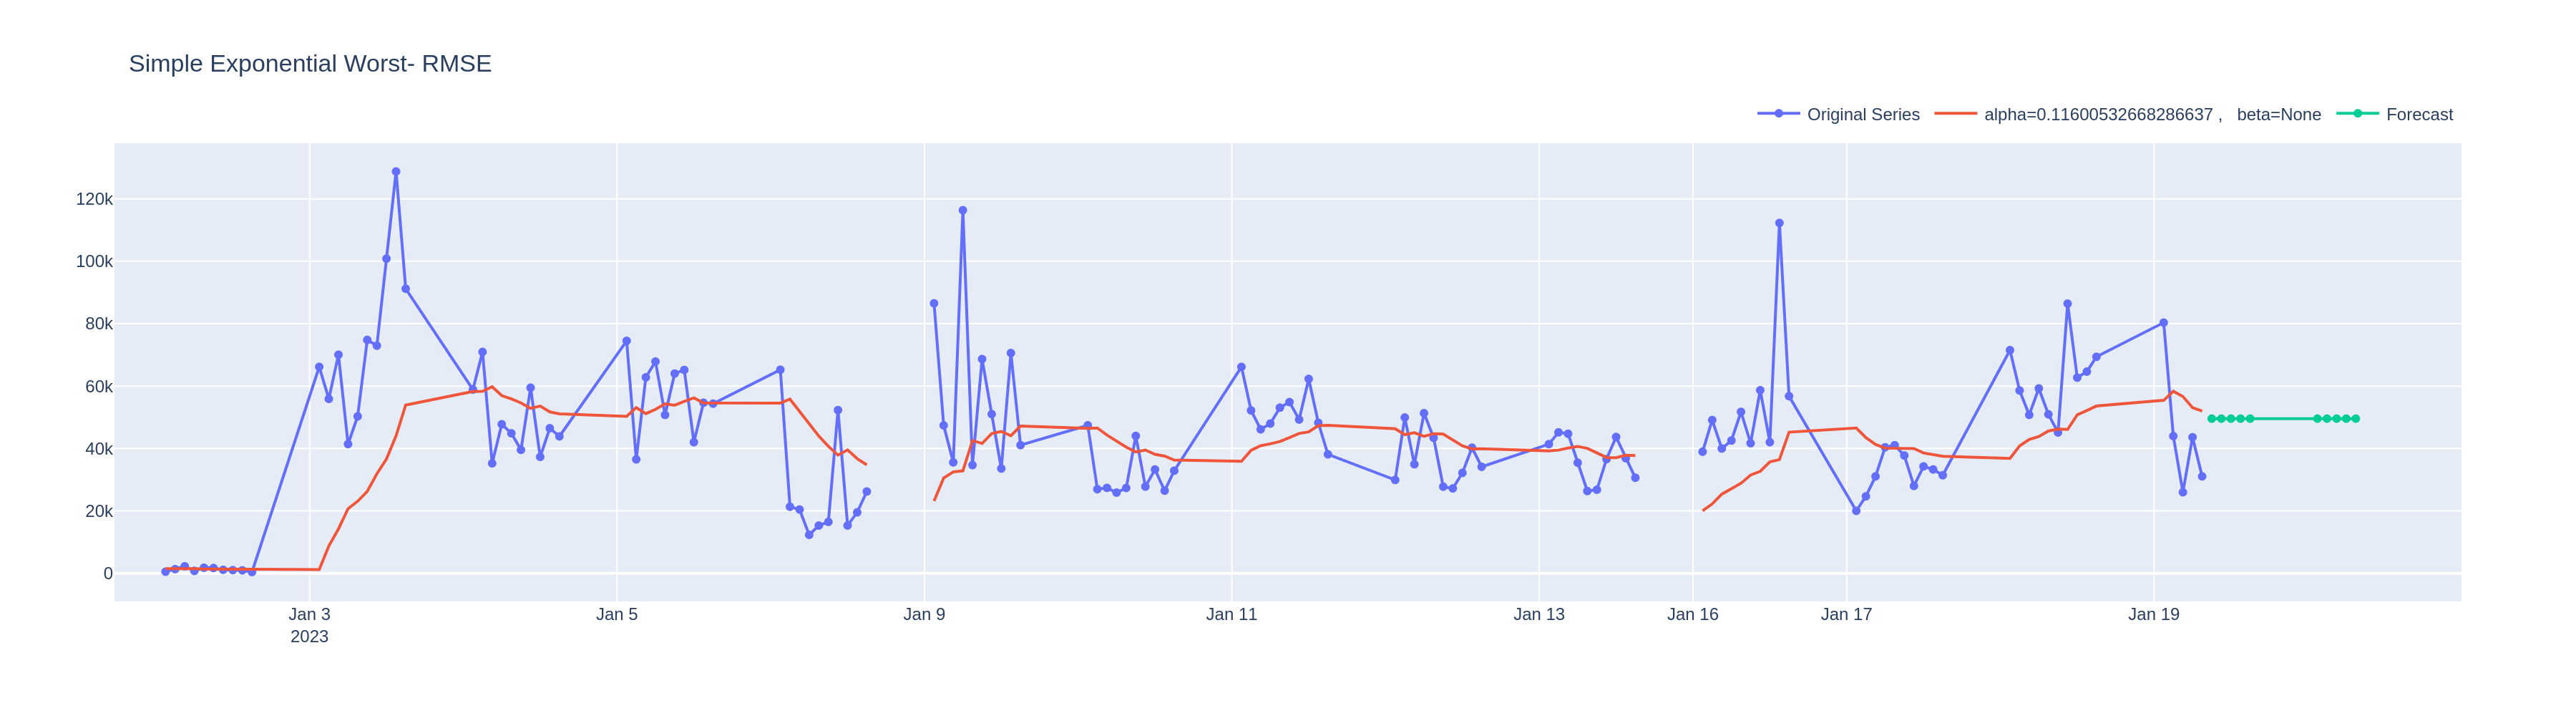

(0, 3)

In [104]:
title_prefix = "Simple Exponential"

show_best_worst(x,y,  fits, fcasts,smoothing_params,fit_rmse,  "Simple Exponential" )

It is very obvious from the charts that as expected, the lower RMSE result is a better fit in this case. However, also as exepced, the forecast is not really useful. It is just a flat line with no variation for the 10 forcasted hours.

The next section will repeat the process, however, this time a trend or ${beta}$ parameter will be added such that the forecast will have a slope.

**Second Order Exponential Smoothing/ Holt's Method**

It is obvious from the charts that as expected, the lower RMSE result is a better fit in this case. However, also as expected, the forecast is not useful. It is just a flat line with no variation for the 10 forecast periods.

The next section will repeat the process, however, this time a trend or ${beta}$ parameter will be added such that the forecast will have a slope.


In [105]:
np.random.seed(4465897)
smoothing_betas = np.random.uniform(0.1, 0.9, 20)
init_methods     = ["estimated", "heuristic"]
exponential      = [True, False]
optimized        = [False]
params           = [exponential, init_methods, smoothing_alphas, smoothing_betas, optimized]
smoothing_params = list(itertools.product(*params))
print(f"Number of Combinations {len(list(smoothing_params))}" )

smoothing_params[0]

Number of Combinations 1600


(True, 'estimated', 0.5175382677788276, 0.2666279779751084, False)

In [106]:
def get_doubleexp_sm( data,
                       smoothing_params=[],
                       fcast_periods=10,

                      ):

    fits   = [ Holt(data,
                      exponential   =p[0],
                      initialization_method=p[1]) \
               .fit( smoothing_level = p[2],
                     smoothing_trend = p[3] ,
                     optimized       = p[4]) for p in smoothing_params
             ]

    fcasts = [fit.forecast(fcast_periods) for fit in fits]

    fit_rmse = [ get_rmse(fit.sse, len(fit.fittedvalues)) for fit in fits]

    return fits, fcasts, fit_rmse


holt_fits,holt_fcasts, holt_fit_rmse = get_doubleexp_sm( data = y,
                                         smoothing_params = smoothing_params ,
                                         fcast_periods=10
                                       )



Min RMSE:  20710.63015349396
Max RMSE:  471450418070.10004
Best Params :  (False, 'estimated', 0.4779329842682727, 0.25286049126848315, False), idx=1055
Worst Params: (True, 'estimated', 0.11600532668286637, 0.4082413322633396, False), idx=63


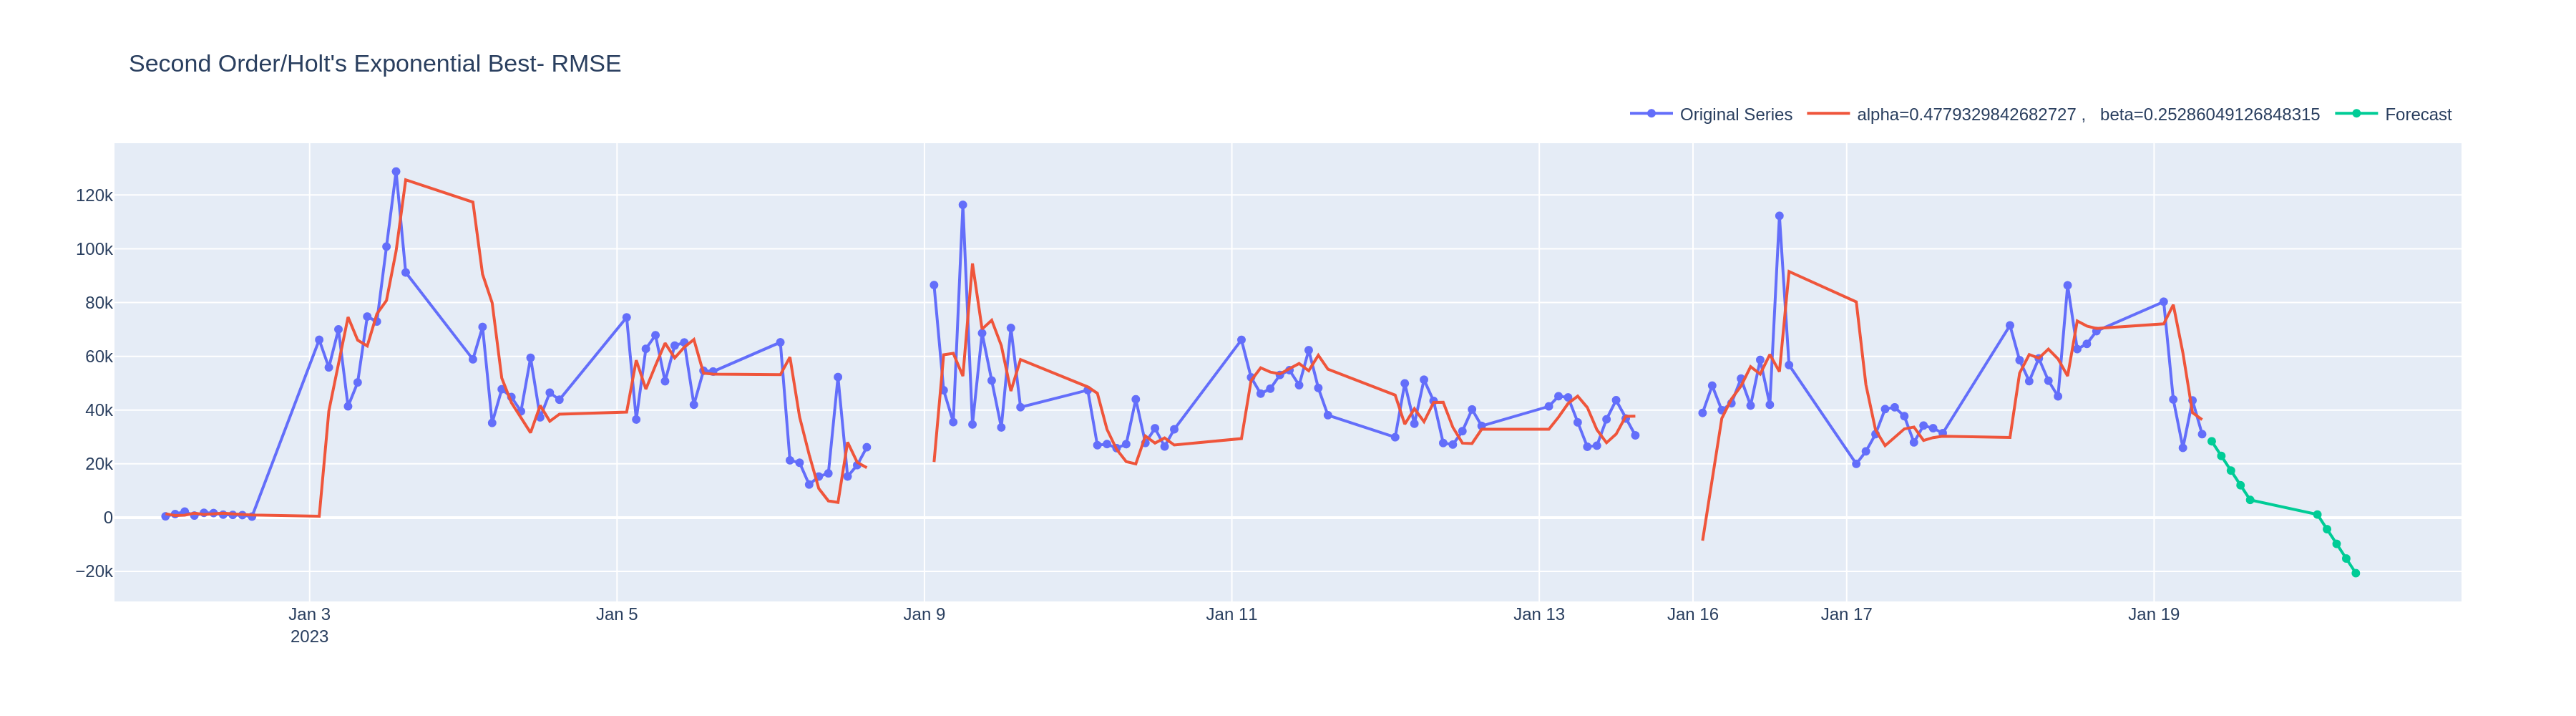

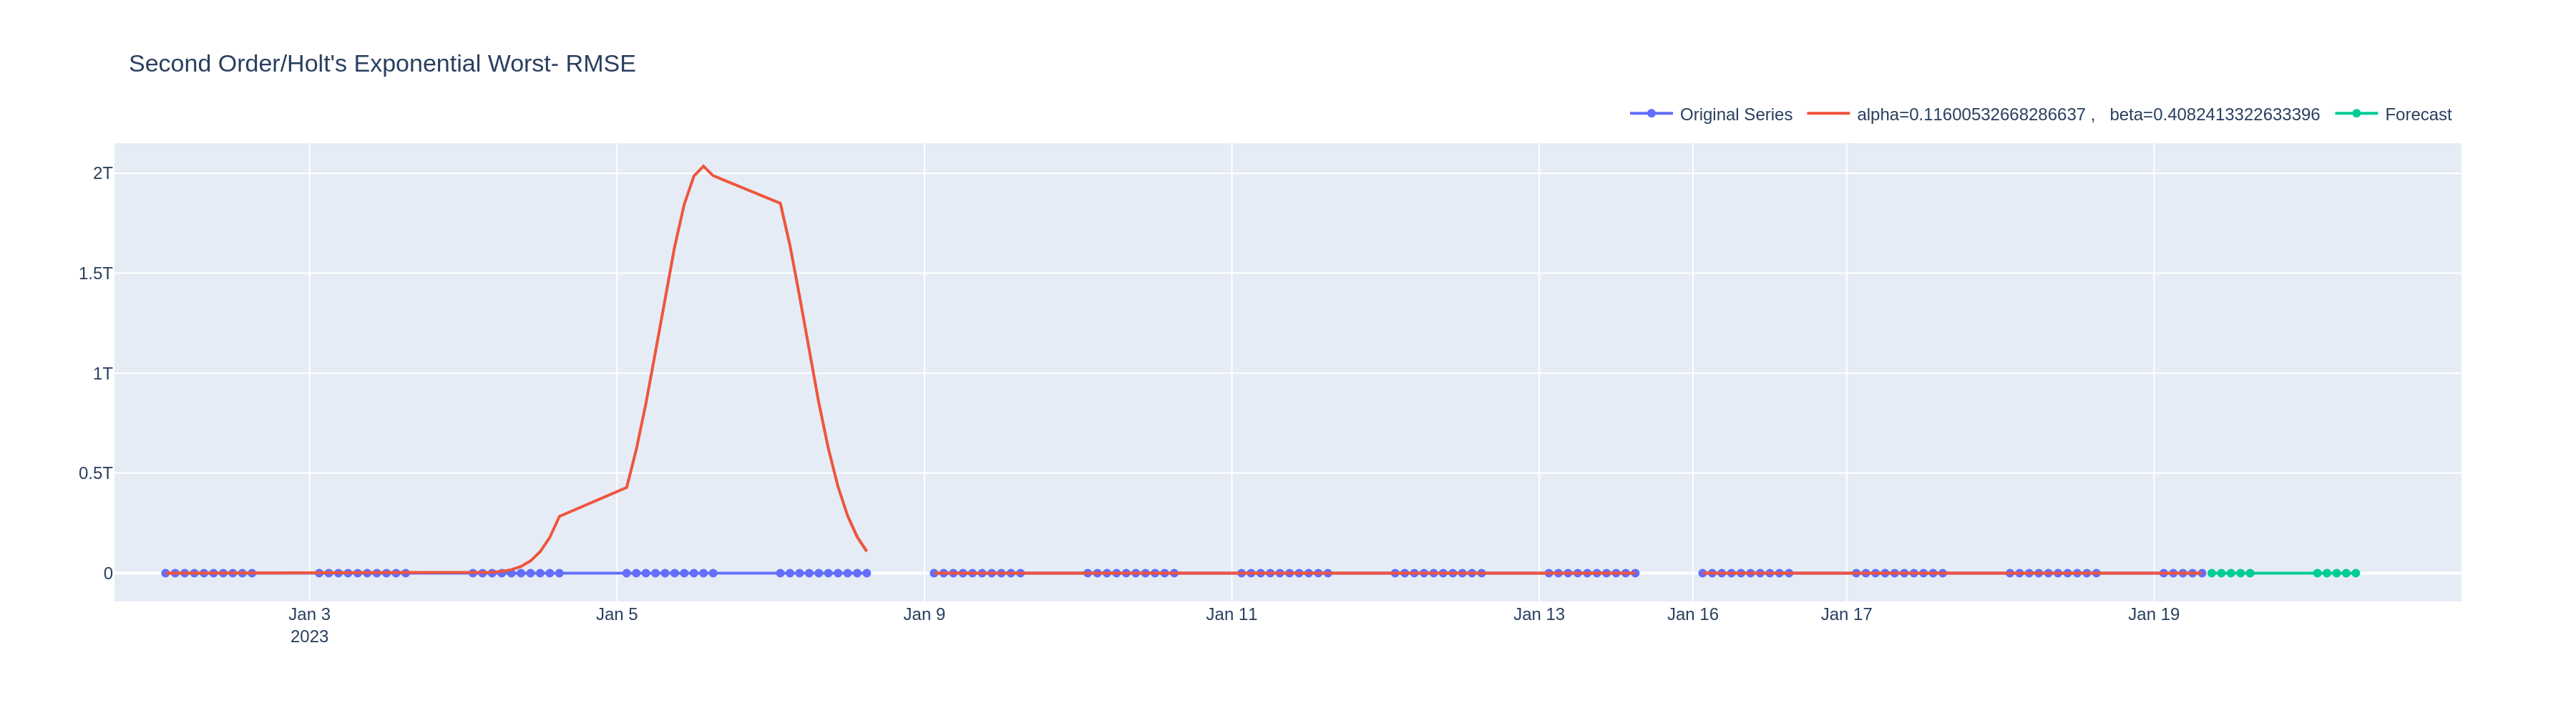

(1055, 63)

In [107]:
show_best_worst(x,y,  holt_fits, holt_fcasts,smoothing_params,holt_fit_rmse,  "Second Order/Holt's Exponential" )

The worst RMSE case is degenerative, further illustrating that RMSE is a good evaluation metric in this case. Next, the case with the RMSE in the middle of the series will be used.

In [108]:

print("Values at midpoints or sorted array: ")
print(f"First Value sorted: {sorted(holt_fit_rmse)[int(len(holt_fit_rmse)/2) - 1]}")
print(f"Second Value sorted: {sorted(holt_fit_rmse)[int(len(holt_fit_rmse)/2)]}")
median_idx = np.argwhere(holt_fit_rmse == sorted(holt_fit_rmse)[int(len(holt_fit_rmse)/2) - 1])[0][0]
median_idx

Values at midpoints or sorted array: 
First Value sorted: 32141.780498406166
Second Value sorted: 2330202.935216178


870

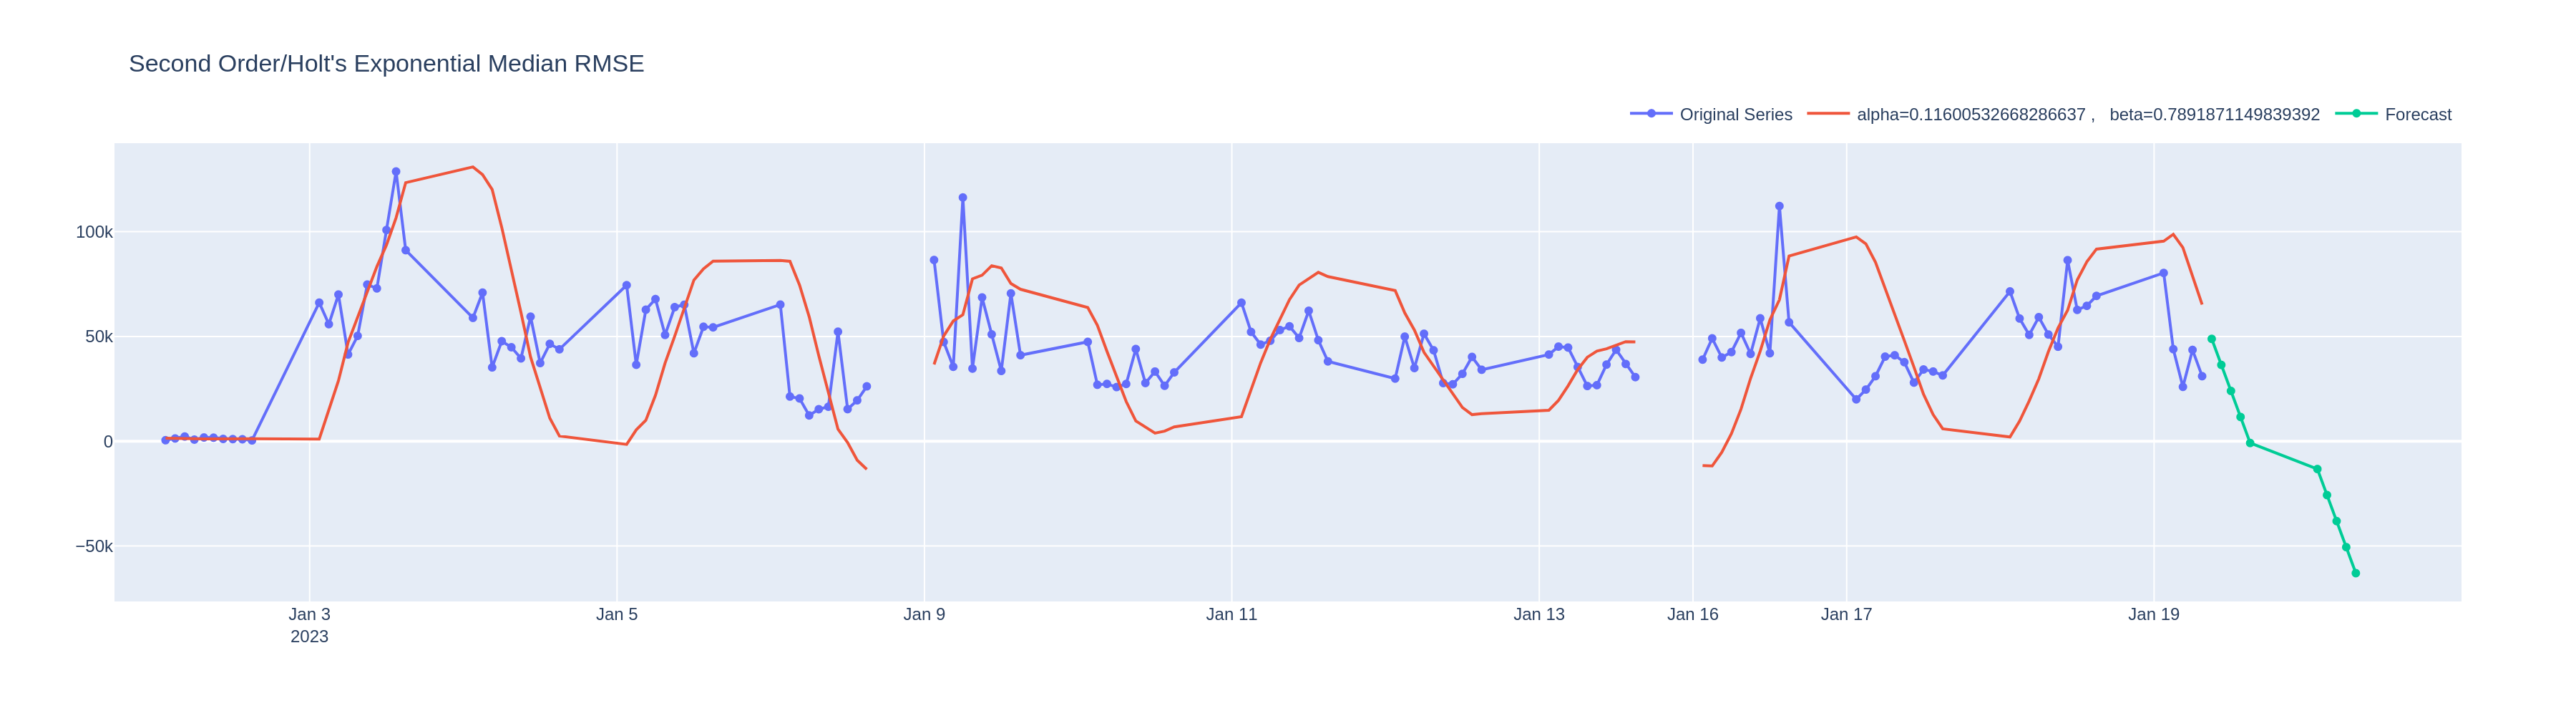

In [109]:
plot_smoothing_lines(x, y, holt_fits[median_idx], holt_fcasts[median_idx], title = "Second Order/Holt's Exponential Median RMSE")

It is obvious from the smoothing that in January 2023, there is more buying activity at the beginning of the week, followed by dips in the middle of the week, followed by an trend  and another dip towards the end of the week. We will examine whether this trend persists throughout the analysis period later. However, for forecasting, in this case, we will conclude that the Best RMSE value is  the most reasonable choice for providing a forecast.

**Baseline Holt Winters**

The baseline assumes that the trend and seasonality are not consistent, thereby making use of the multiplicative instead of the additive method, which generally works better for consistent trends. Adjustments will be made in further analysis to determine if better fits can be attained using longer series and different parameters, including the use of  a damped trend parameter. The damped trend has the effect of damping the forecast trajectory, which in general, provides more accurate forecasts.



Baseline RMSE: 19951.08534732745


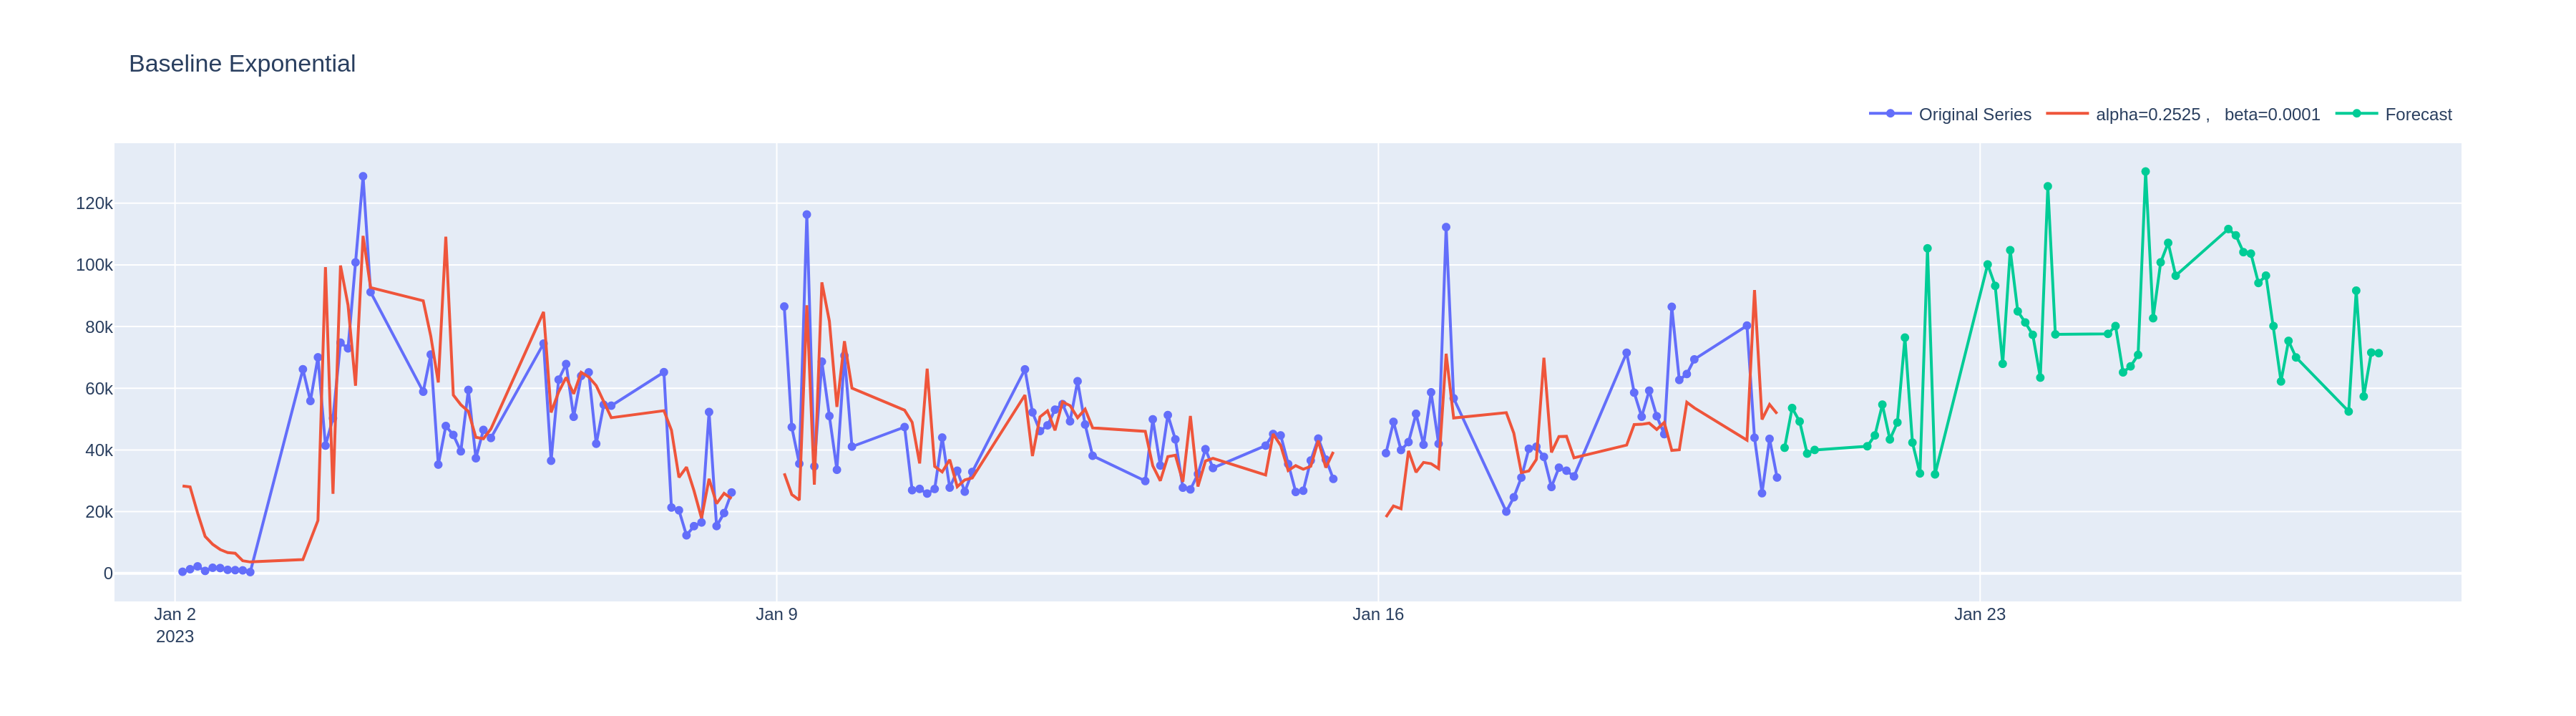

In [110]:
np.random.seed(89074)
baseline_expo_fit = ExponentialSmoothing(y, trend="mul", seasonal="mul", seasonal_periods=50).fit()
baseline_expo_fcast = baseline_expo_fit.forecast(50)

print(f"Baseline RMSE: {get_rmse(baseline_expo_fit.sse, len(baseline_expo_fit.fittedvalues))}")

plot_smoothing_lines(x, y, baseline_expo_fit, baseline_expo_fcast, title = "Baseline Exponential")

The first and second order forecasts have thus far not provided any useful insight, although useful in understanding the weekly buying patterns. The Holt-Winters method has now yielded the most plausible forecast. From this point on, Exponential Smoothing Analysis , will be the main focus, with an emphasis on  Third Order/Holt-Winters Method an forecasts.



**Hyper-Parameter Search**

In addition to the other parameters explained, the box_cox transformation converts the input data to the best bit that resembles a normal distribution. While not necessary here, it could yield better results. This implementation of Holt-Winter's algorithms attempts to find the best alpha, beta and phi (the damping parameter) based on straightforward parameters, without the need to explicitly specify the numerical values.



In [111]:
seed = 729800
np.random.seed(seed)

init_methods          = ["estimated", "heuristic"]
trend                 = [ "add", "mul"]
seasonal              = [ "mul"]
damped_trend          = [True, False]
box_cox               = [True, False]
params           = [
                    trend,
                    seasonal,
                    damped_trend,
                    init_methods,
                    box_cox ]
smoothing_params = list(itertools.product(*params))
print(f"Number of Combinations {len(list(smoothing_params))}" )

Number of Combinations 16


Min RMSE:  19722.770645853943
Max RMSE:  24949.543050267246
Best Params :  ('add', 'mul', True, 'heuristic', False), idx=3
Worst Params: ('add', 'mul', True, 'estimated', False), idx=1


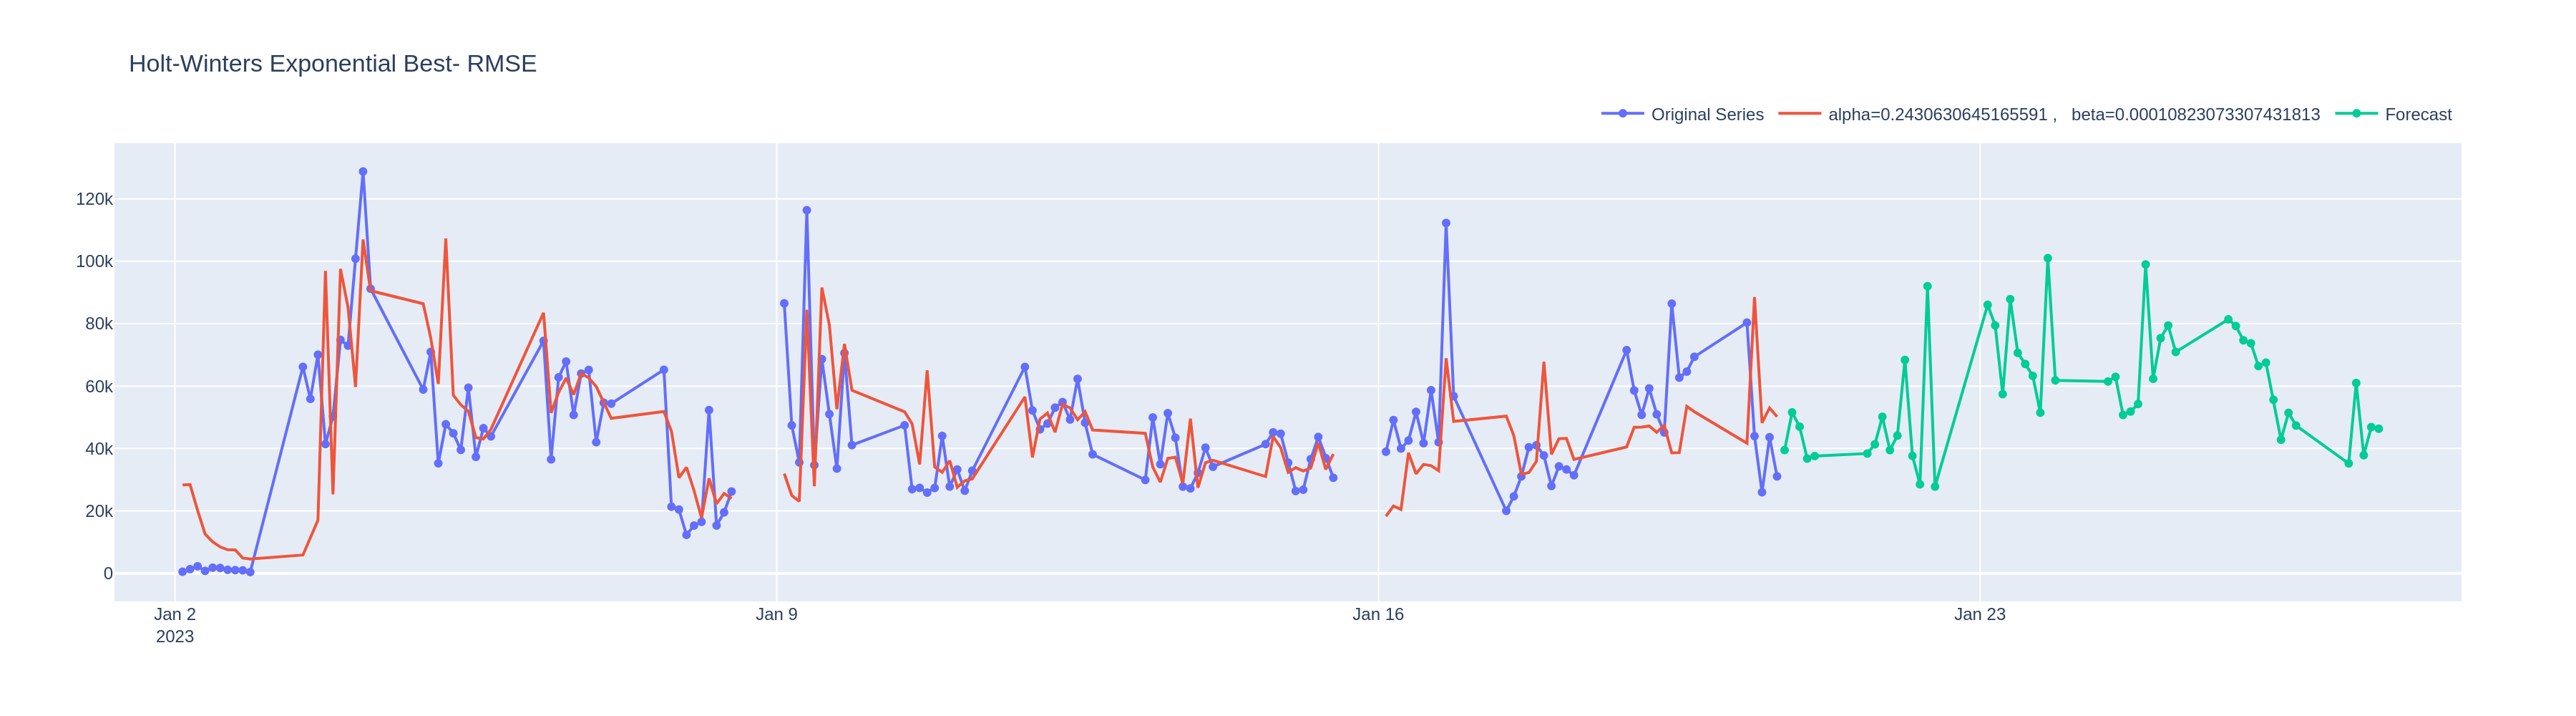

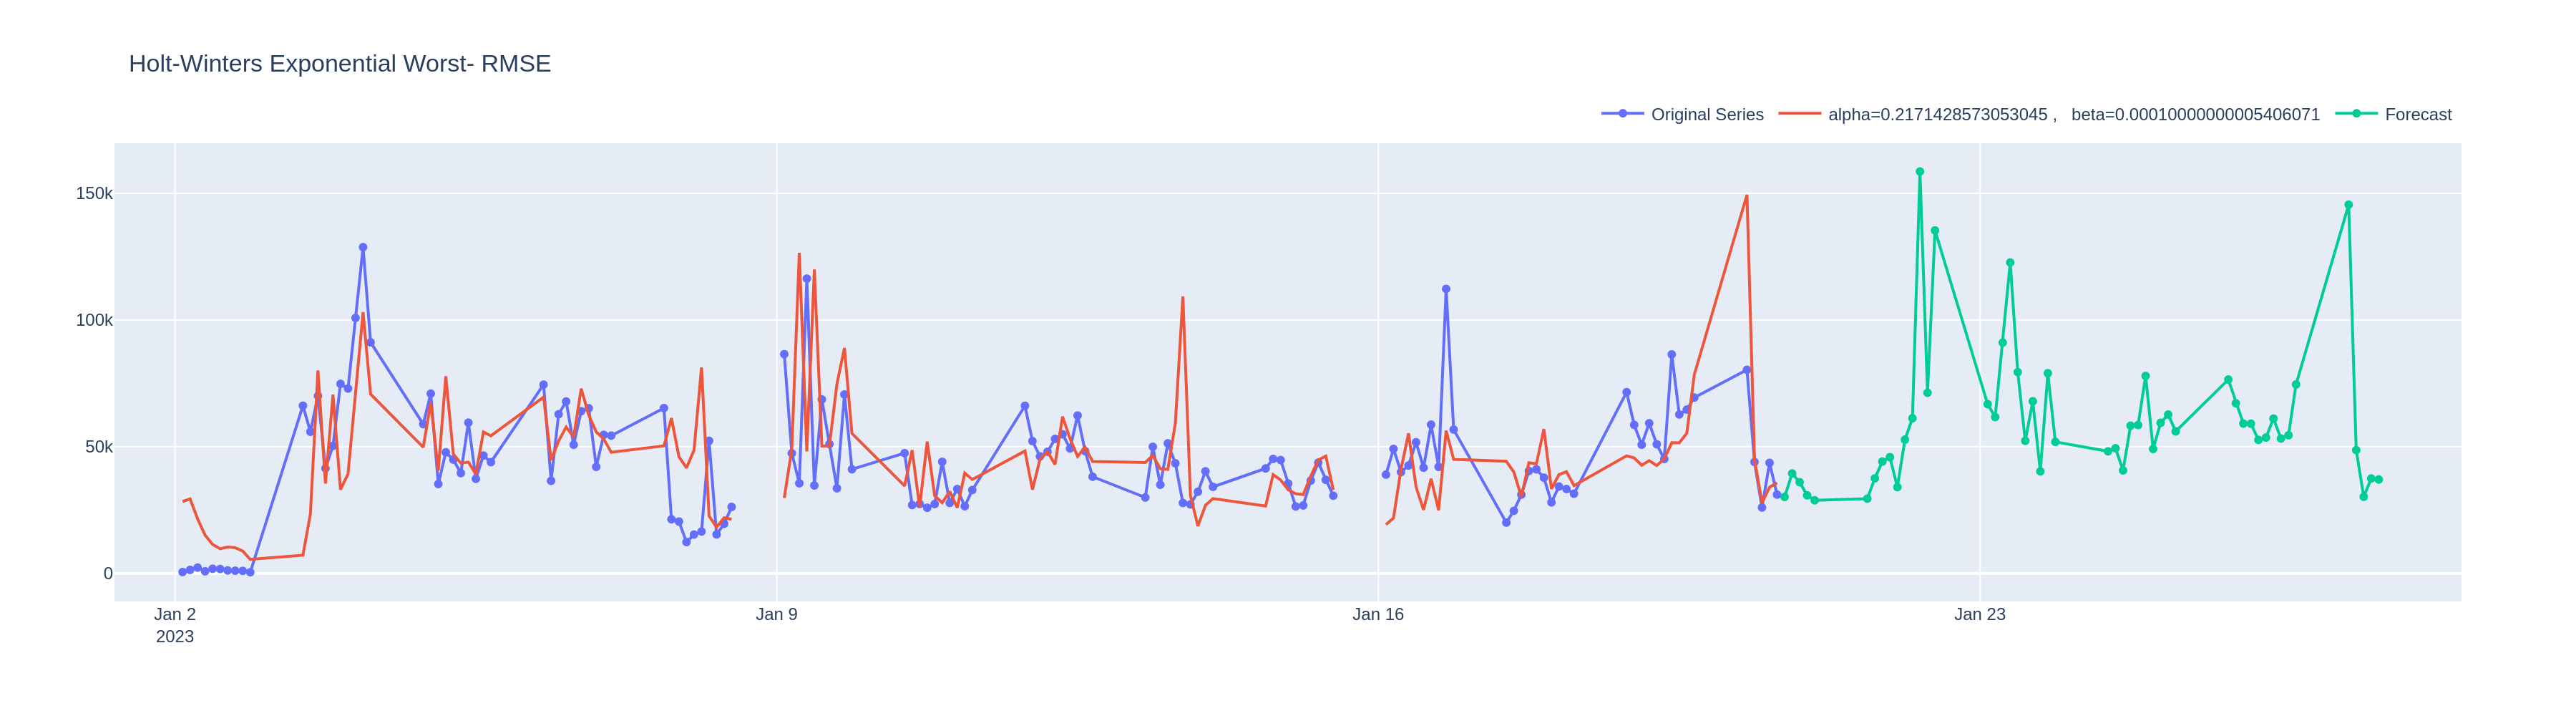

In [112]:
np.random.seed(seed)

def get_holt_winters_sm( data,
                         smoothing_params=[],
                         fcast_periods   =10,
                         seasonal_periods = 50

                      ):

    fits   = [ ExponentialSmoothing(data,
                                    trend       =p[0],
                                    seasonal    =p[1],
                                    damped_trend=p[2],
                                    seasonal_periods= seasonal_periods,
                                    initialization_method = p[3],
                                    use_boxcox    =p[4]
                                    ).fit()
                  for p in smoothing_params
             ]

    fcasts = [fit.forecast(fcast_periods) for fit in fits]

    fit_rmse = [ get_rmse(fit.sse, len(fit.fittedvalues)) for fit in fits]

    return fits, fcasts, fit_rmse


hw_fits,hw_fcasts, hw_fit_rmse = get_holt_winters_sm( data = y,
                                         smoothing_params = smoothing_params ,
                                         fcast_periods   =50,
                                         seasonal_periods=50

                                       )


best_idx, worst_idx =show_best_worst(x,y,  hw_fits, hw_fcasts,smoothing_params,hw_fit_rmse,  "Holt-Winters Exponential" )

The two charts above raise the question of which fit and forecast is better. The next section will compare known data to the forecasts.

In [113]:
## A custom SSE function to compare to compare forecast data to real
def custom_sse( yhat, y ):
  return np.sum(np.power(np.subtract(yhat, y), 2))

In [114]:
order_totals.head()

hr  bottles_purchased  purchase_dollars
0 2023-01-02 08:00:00                 43            487.05
1 2023-01-02 09:00:00                 81            1323.3
2 2023-01-02 10:00:00                116           2244.69
3 2023-01-02 11:00:00                 29            767.88
4 2023-01-02 12:00:00                133           1789.47

From the Printout Above the indices in question are 1 and 12. The next section will match up actual hourly data timestamps with forecasts instead of the artificial timestamps used previously. This will ensure that the forecast data points can match exactly with data points for the comparisons.



In [115]:

np.random.seed(seed)
def forecast_min_rmse(x, next_series, fcasts, data_len, idxs, date_col= "hr", numeric_col="purchase_dollars"):
    "Function that saves values only when the new value is less than any other"
    output   = []
    last_min = np.inf

    for idx in idxs:
        sse = custom_sse(fcasts[idx], next_series.tolist())
        if sse < last_min :
          output = []
          output.append({idx: get_rmse(sse, data_len)})
          last_min = sse
    return output


idxs = [best_idx,worst_idx]
data_len = hw_fcasts[1].size
last_ts = x.loc[len(x)-1]
next_series = order_totals.loc[order_totals[date_col] > last_ts, "purchase_dollars"][0: data_len ]
next_x      = order_totals.loc[order_totals[date_col] > last_ts, "hr"][0: data_len ]
forecast_min_rmse(x, next_series, hw_fcasts, data_len, idxs)

[{3: 26230.98434518136}]

In [116]:
##Running for all forecasts
idxs = [r for r in range(0,len(hw_fcasts))]
best = forecast_min_rmse(x, next_series, hw_fcasts, data_len, idxs)
best

[{0: 22805.09237678903}]

In this case the best forecast based on the RMSE of the input data and the smoothed series, resulted in a worse outcome when compared to other forecasts. Plotting will give more insight.

In [117]:
def plot_forecast_lines(x, y, forecast_objs, title, as_image = True, image_format="png", image_width=1800, image_scale=2.0):
    # Create traces
    fig = go.Figure(  layout=go.Layout(
                                      title=go.layout.Title(text=title)
                                        )
                   )



    fig.add_trace(go.Scatter(x=x, y=y,
                        mode='lines+markers',
                        name='Original Series'))

    for forecast_obj in forecast_objs:
        fig.add_trace(go.Scatter(x=x, y=forecast_obj,
                            mode='lines',
                            name='Forecast'))



    fig.update_xaxes(
        rangebreaks=[
            dict(bounds=["sat", "mon"]),
            dict(bounds=[22, 7], pattern="hour"), #hide hours

        ]
    )

    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))

    if as_image:
      img = Image(fig.to_image(format=image_format, width = image_width, scale = image_scale))
      return img
    else:
      fig.show()


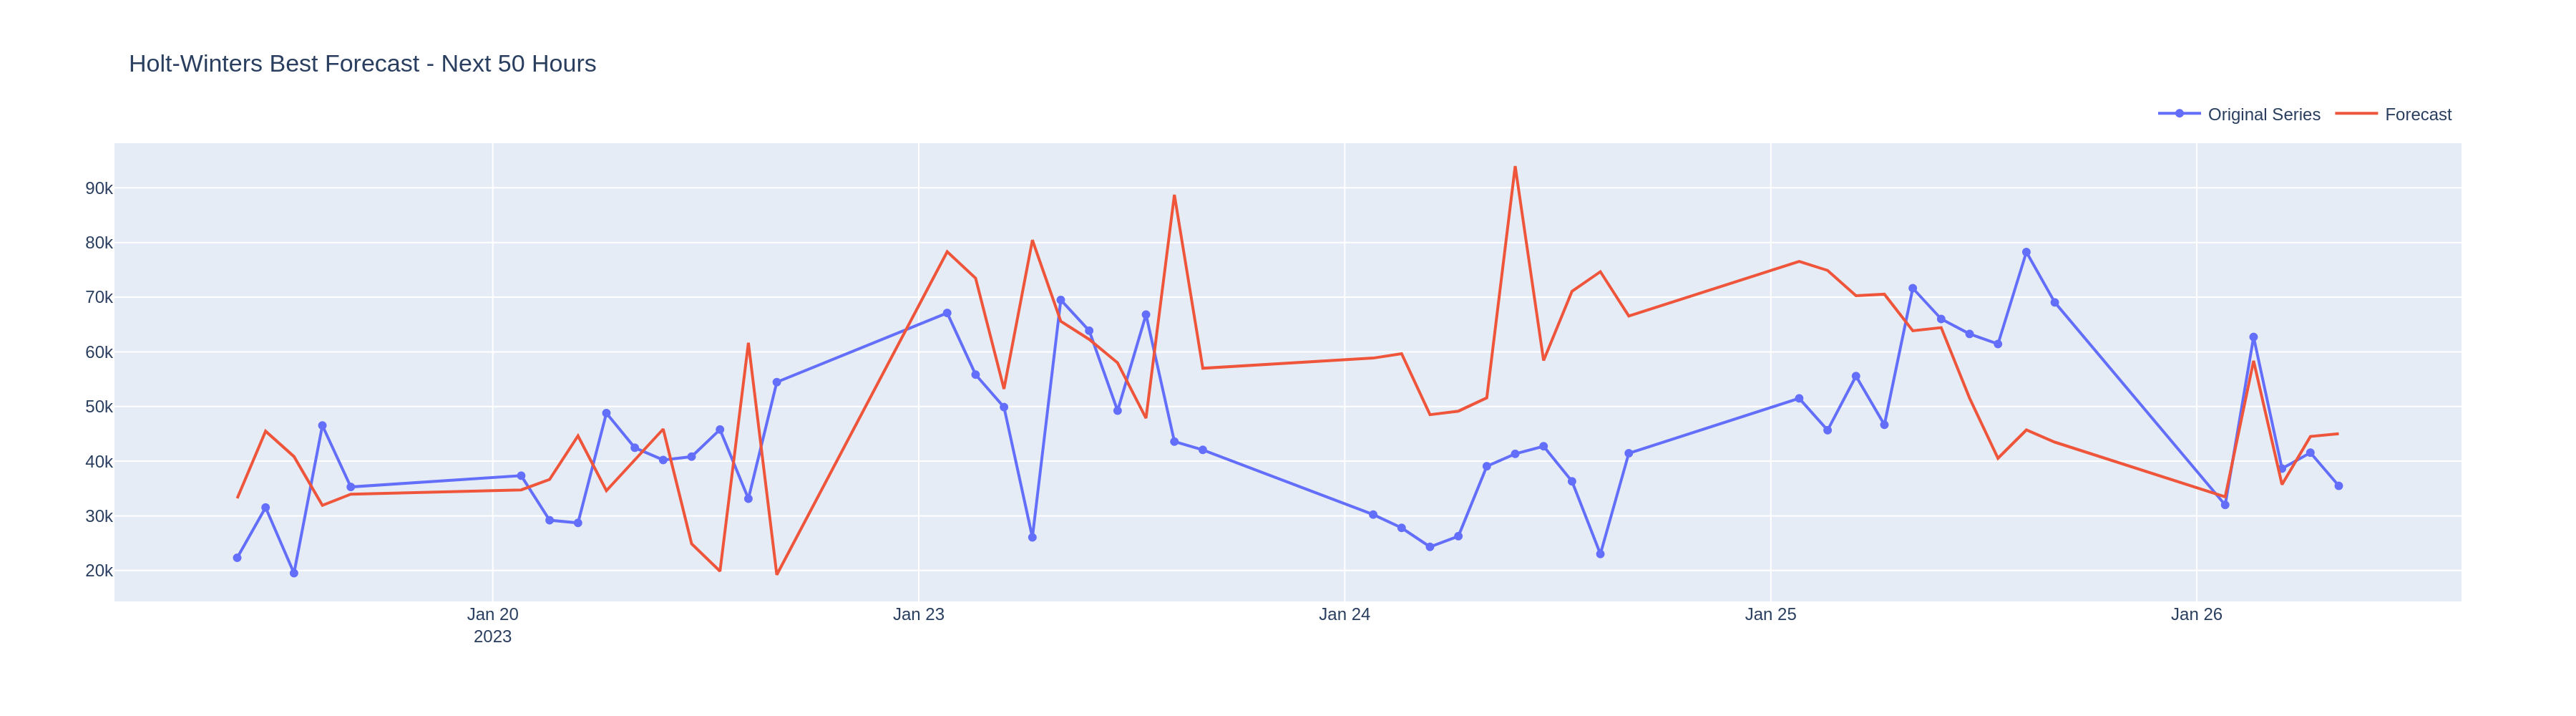

In [118]:
np.random.seed(seed)
best_index =  list(best[0].keys())[0]
plot_forecast_lines(x = next_x, y=next_series, forecast_objs= [hw_fcasts[best_index]], title = f"Holt-Winters Best Forecast - Next {data_len} Hours")

**Experimentation with Input Data Lengths**

The comparison chart shows that the forecast could be a plausible indicator of future peaks and troughs. In the next section, analysis will be conducted to determine if changing the lengths of the input and forecast data will result in a better forecast.

In [119]:

order_totals.head()

hr  bottles_purchased  purchase_dollars
0 2023-01-02 08:00:00                 43            487.05
1 2023-01-02 09:00:00                 81            1323.3
2 2023-01-02 10:00:00                116           2244.69
3 2023-01-02 11:00:00                 29            767.88
4 2023-01-02 12:00:00                133           1789.47

In [120]:
order_totals.tail()

hr  bottles_purchased  purchase_dollars
4616 2024-07-31 13:00:00               3020          51282.53
4617 2024-07-31 14:00:00               2205          37813.83
4618 2024-07-31 15:00:00               2130          36436.34
4619 2024-07-31 16:00:00               4850          66951.05
4620 2024-07-31 17:00:00               3440          67319.51

This provides a more flexible dataset to experiment with. In the next section, the length of the input data will be lengthened while using the same 50 -hour forecast, using the parameters that gave the best fit and forecast thus far.

In [121]:
##Roughly 3 month limit
np.random.seed(seed)
limit = 3 * 4 * 50
y                   = order_totals.purchase_dollars.loc[0:limit-1].tolist()
x                   = order_totals.hr.loc[0:limit-1]

forecast_eval_smoothing_params =  [smoothing_params[best_index]]
print(forecast_eval_smoothing_params)
hw_fits,hw_fcasts_600, hw_fit_rmse = get_holt_winters_sm( data = y,
                                                      smoothing_params = forecast_eval_smoothing_params ,
                                                      fcast_periods   =50,
                                                      seasonal_periods=50

                                                    )

[('add', 'mul', True, 'estimated', True)]


There is only one forecast series here so zero will be used as the index.

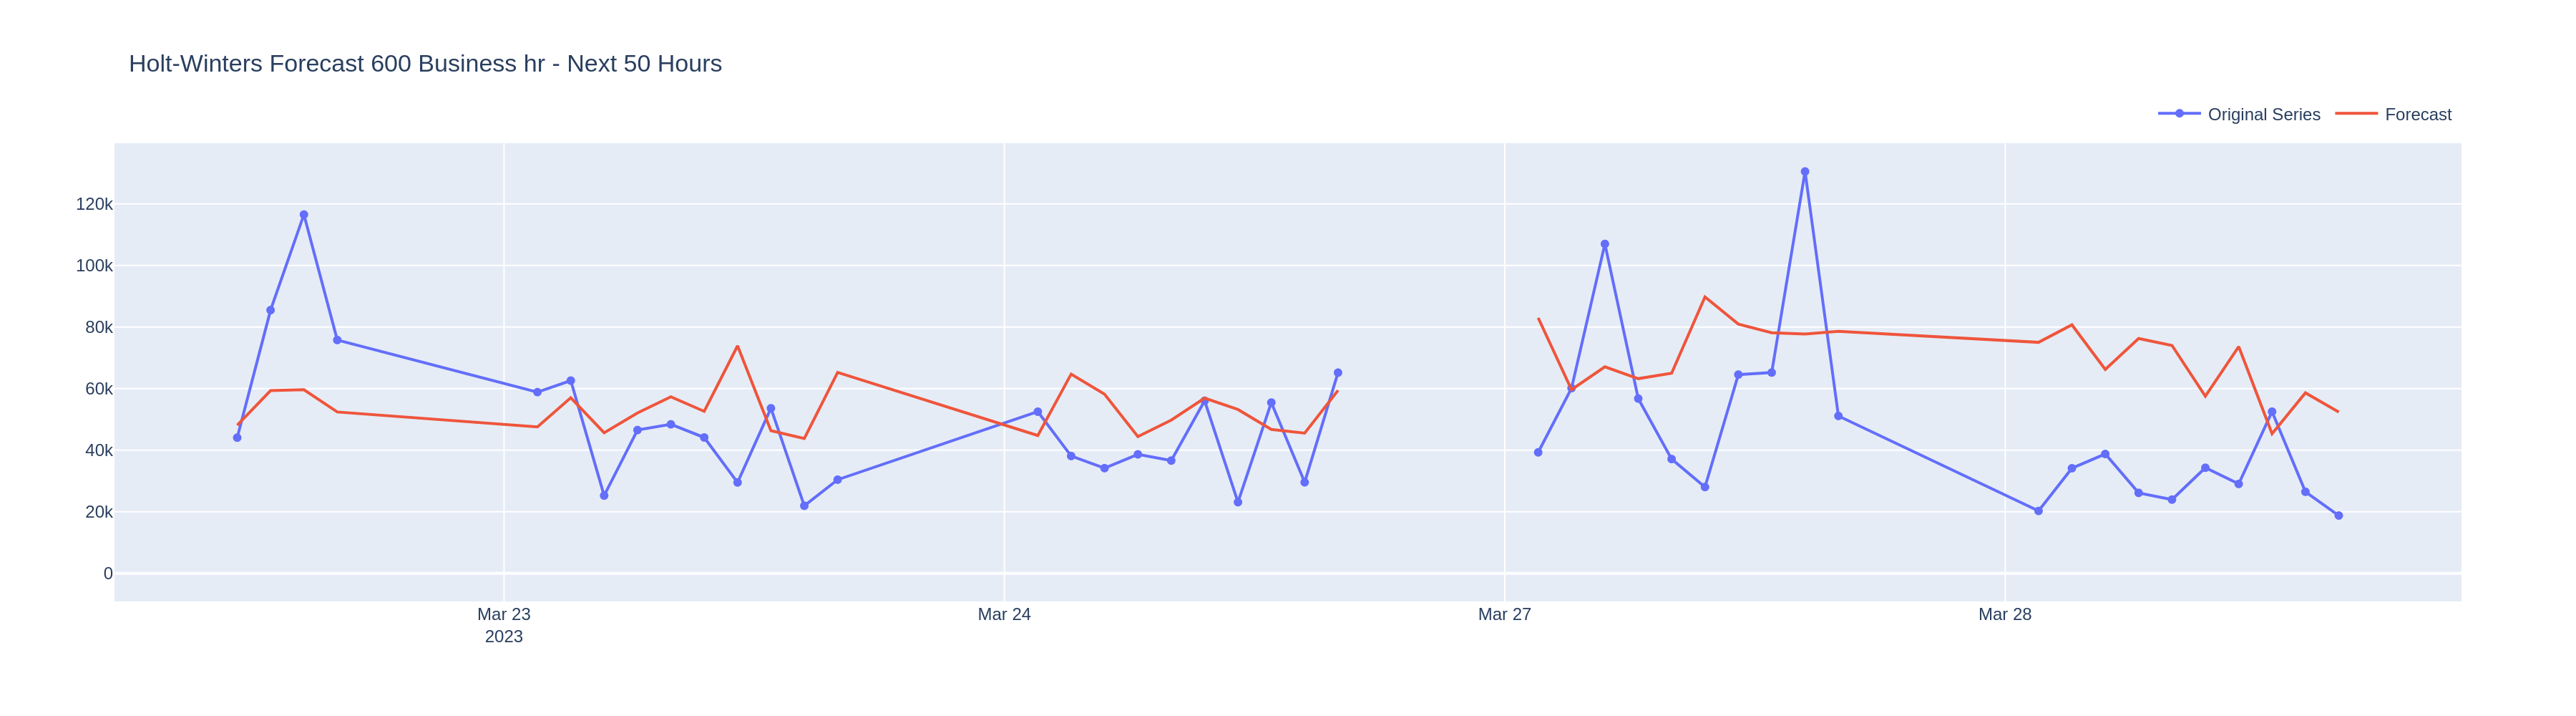

In [122]:
idxs = [0]
data_len = hw_fcasts_600[0].size
last_ts = x.loc[len(x)-1]
next_series = order_totals.loc[order_totals[date_col] > last_ts, "purchase_dollars"][0: data_len ]
next_x      = order_totals.loc[order_totals[date_col] > last_ts, "hr"][0: data_len ]

forecast_min_rmse(x, next_series, hw_fcasts_600, data_len, idxs)

plot_forecast_lines(x = next_x, y=next_series, forecast_objs = [hw_fcasts_600[0]], title = f"Holt-Winters Forecast {limit} Business {date_col} - Next {data_len} Hours")

This resulted in higher RMSE. The next implementation will try the same forecast period with less input data.

**300 hours**

In [124]:
y_new =order_totals.purchase_dollars.loc[0:599]
x_new =order_totals.hr.loc[0:599]

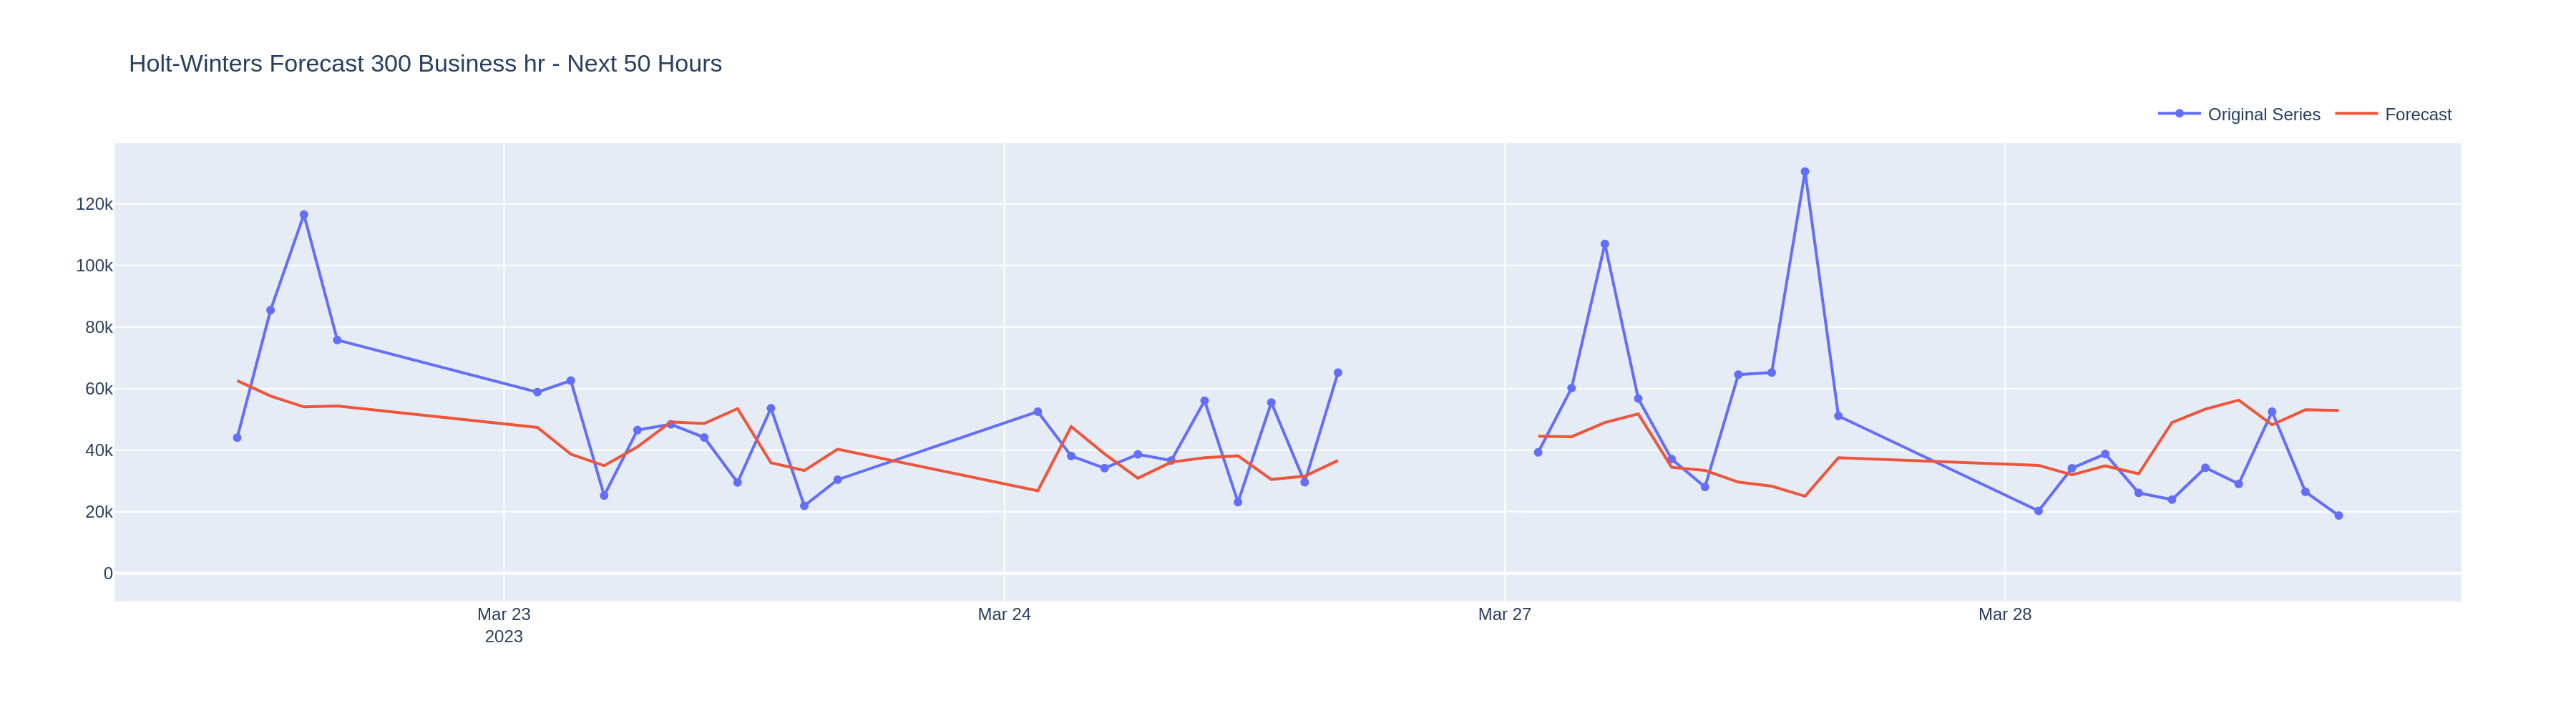

In [125]:
np.random.seed(seed)
limit = 300
y = list(y_new[-300:].reset_index(drop=True))
x = x_new[-300:].reset_index(drop=True)
hw_fits,hw_fcasts_300, hw_fit_rmse = get_holt_winters_sm( data = y,
                                                      smoothing_params = forecast_eval_smoothing_params ,
                                                      fcast_periods   =50,
                                                      seasonal_periods=50

                                                    )


idxs = [0]
data_len = hw_fcasts_300[0].size
last_ts = x.loc[len(x)-1]
next_series = order_totals.loc[order_totals[date_col] > last_ts, "purchase_dollars"][0: data_len ]
next_x      = order_totals.loc[order_totals[date_col] > last_ts, "hr"][0: data_len ]

plot_forecast_lines(x = next_x, y=next_series, forecast_objs = [hw_fcasts_300[0]], title = f"Holt-Winters Forecast {limit} Business {date_col} - Next {data_len} Hours")

This resulted is a better RMSE Value for the Forecast. Next is the forecast using the original 150 Hours.


**150 hours:**

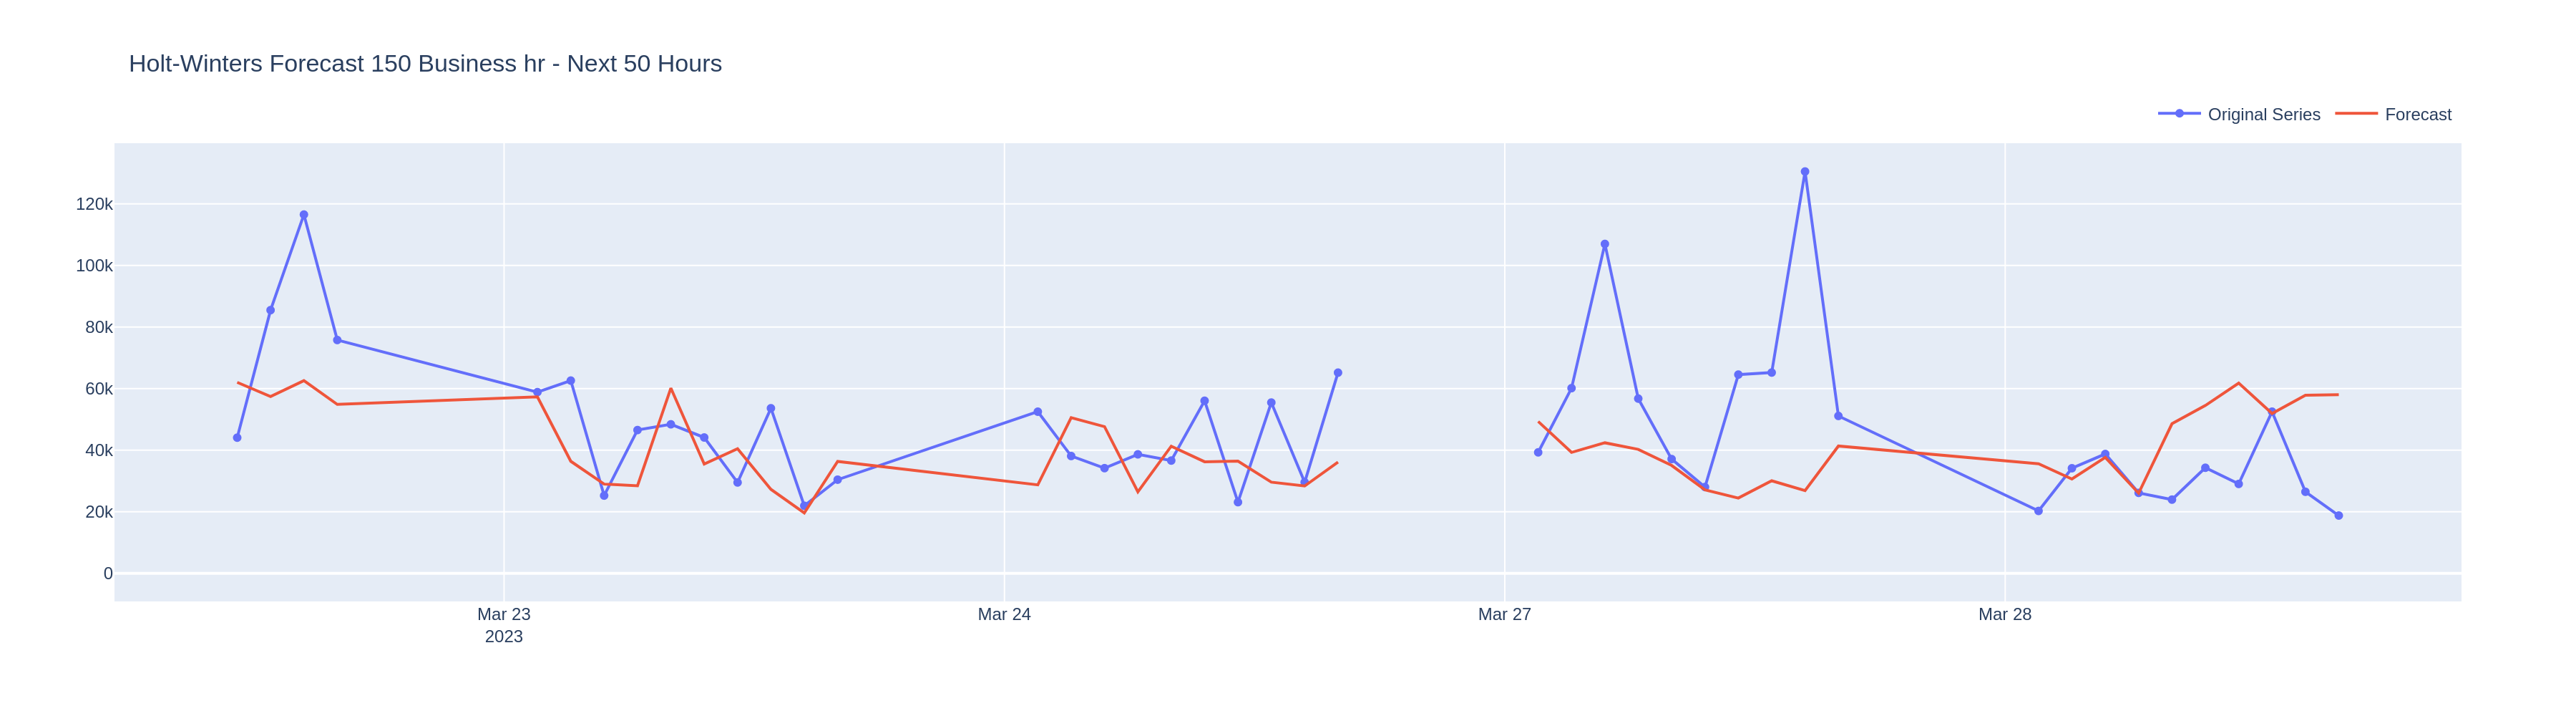

In [126]:
np.random.seed(seed)

limit = 150
y = list(y_new[-150:].reset_index(drop=True))
x = x_new[-150:].reset_index(drop=True)

hw_fits,hw_fcasts_150, hw_fit_rmse = get_holt_winters_sm( data = y,
                                                      smoothing_params = forecast_eval_smoothing_params ,
                                                      fcast_periods   =50,
                                                      seasonal_periods=50

                                                    )

idxs = [0]
data_len = hw_fcasts_150[0].size
last_ts = x.loc[len(x)-1]
next_series = order_totals.loc[order_totals[date_col] > last_ts, "purchase_dollars"][0: data_len ]
next_x      = order_totals.loc[order_totals[date_col] > last_ts, "hr"][0: data_len ]

plot_forecast_lines(x = next_x, y=next_series, forecast_objs = [hw_fcasts_150[0]], title = f"Holt-Winters Forecast {limit} Business {date_col} - Next {data_len} Hours")

**100 Hours:**

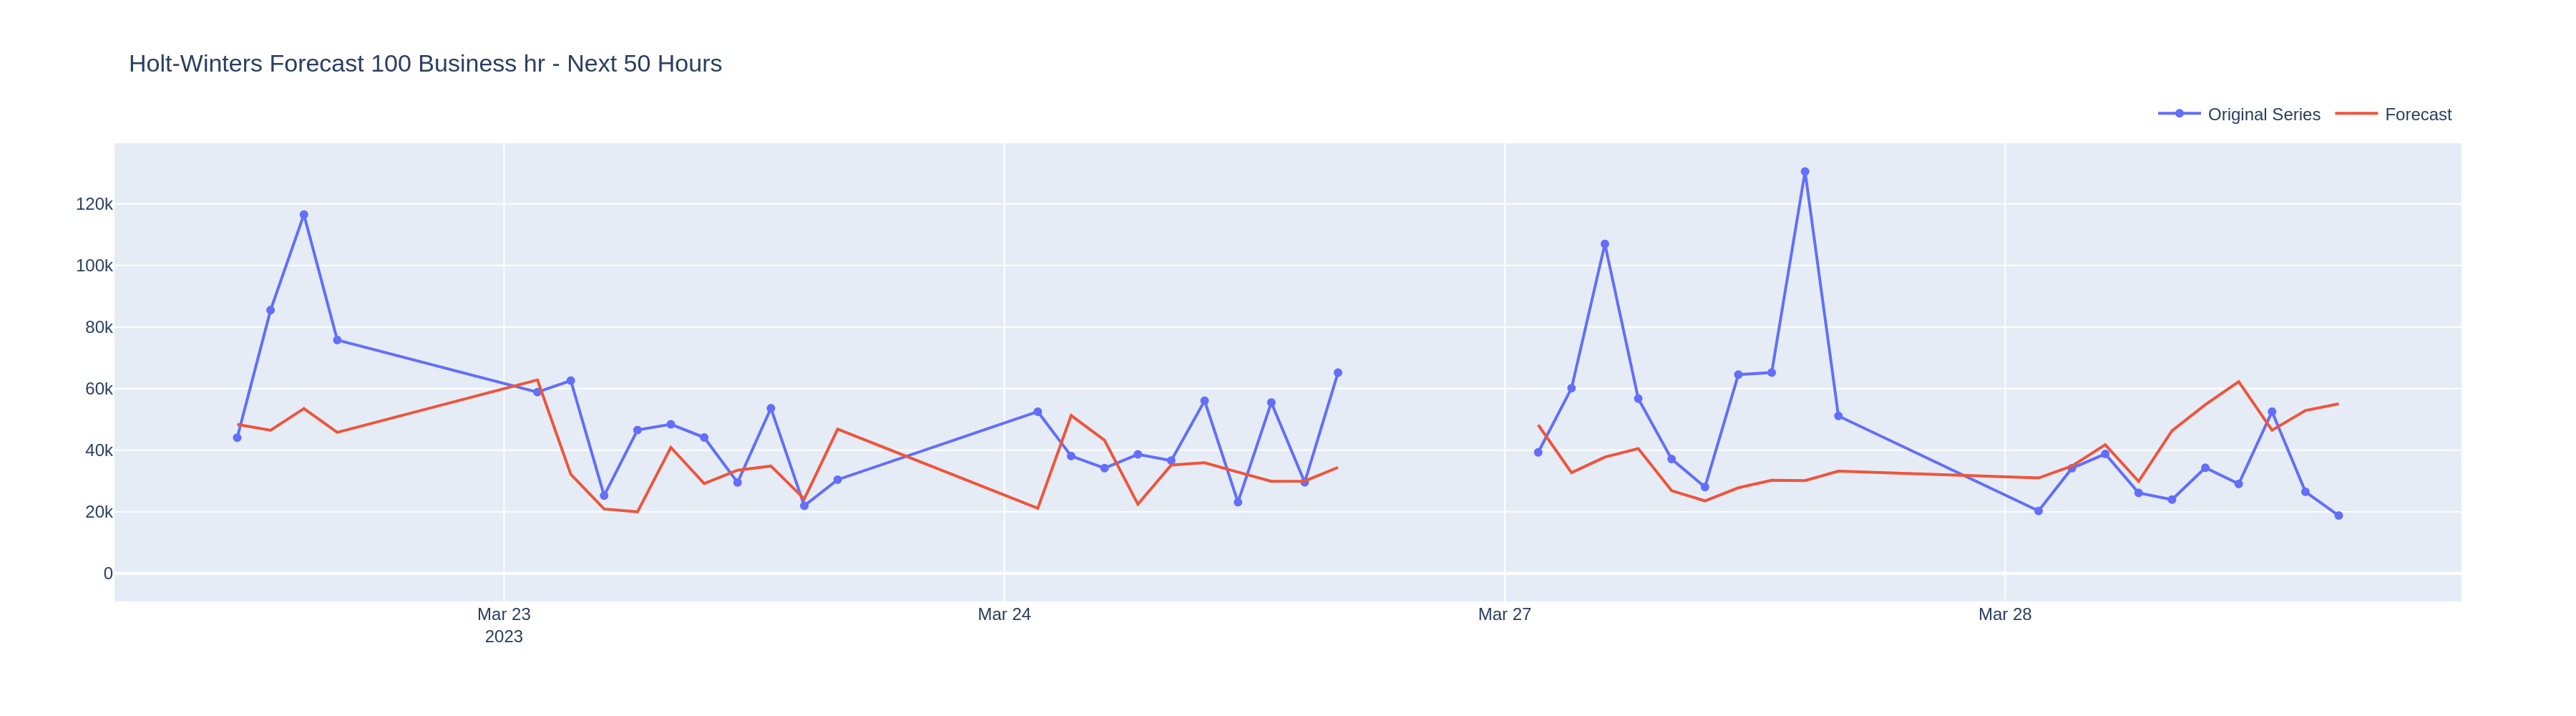

In [127]:
np.random.seed(seed)

limit = 100
y = list(y_new[-100:].reset_index(drop=True))
x = x_new[-100:].reset_index(drop=True)

hw_params = forecast_eval_smoothing_params


## Handle issue with Multiplicative Seasonal and Trend for shortest allowable period, when Box-cox == True

if ('mul', 'mul', True, 'estimated', True) == forecast_eval_smoothing_params[0]:
  ##simply ignore the box-cox transformation
  hw_params = [('mul', 'mul', True, 'estimated', False)]

hw_fits,hw_fcasts_100, hw_fit_rmse = get_holt_winters_sm( data = y,
                                                      smoothing_params = hw_params,
                                                      fcast_periods   =50,
                                                      seasonal_periods=50

                                                    )



idxs = [0]
data_len = hw_fcasts_100[0].size
last_ts = x.loc[len(x)-1]
next_series = order_totals.loc[order_totals[date_col] > last_ts, "purchase_dollars"][0: data_len ]
next_x      = order_totals.loc[order_totals[date_col] > last_ts, "hr"][0: data_len ]

plot_forecast_lines(x = next_x, y=next_series, forecast_objs = [hw_fcasts_100[0]], title = f"Holt-Winters Forecast {limit} Business {date_col} - Next {data_len} Hours")

**A full year and a Half +**

Finally, the next section does analysis on the full dataset, leaving 50 hours for forecast analysis in the last week of July 2024.

In [128]:
series_len = len(order_totals) - 51
y =order_totals.purchase_dollars.loc[0: series_len]
x =order_totals.hr.loc[0:series_len]

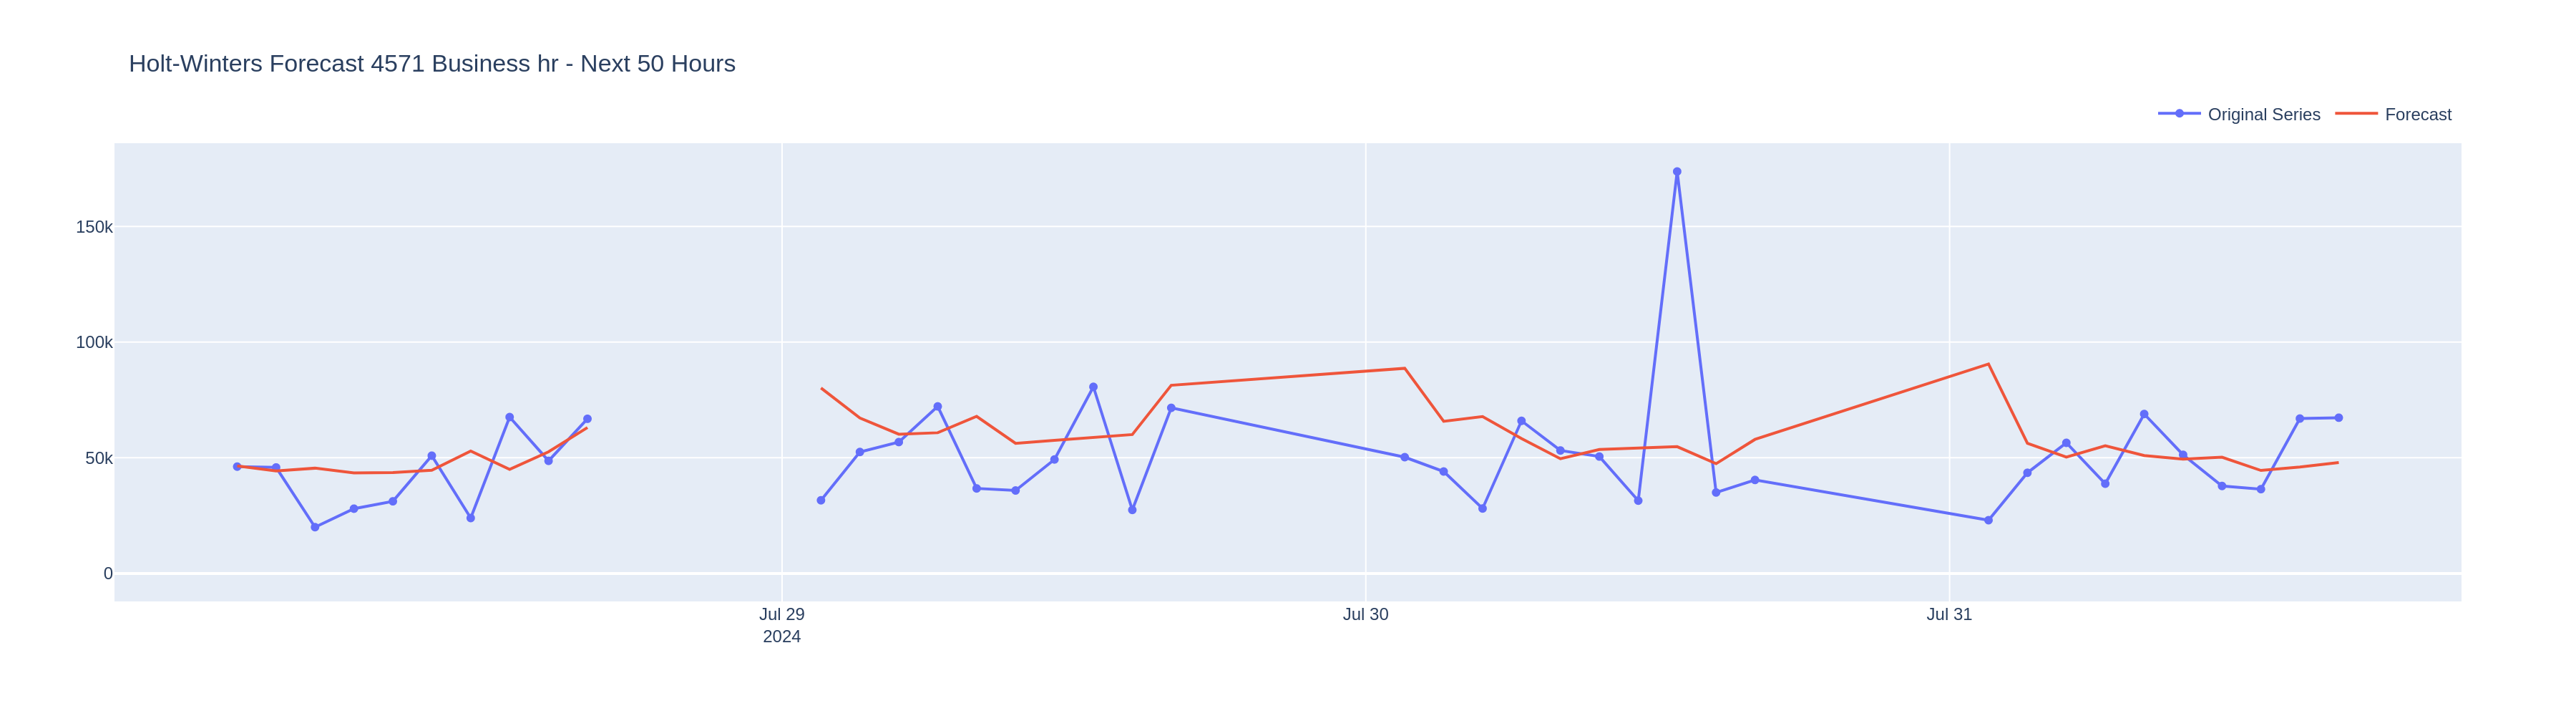

In [129]:
np.random.seed(seed)
limit = len(x)
y = list(y.reset_index(drop=True))
x = x.reset_index(drop=True)


hw_fits,hw_fcasts_all, hw_fit_rmse = get_holt_winters_sm( data = y,
                                                      smoothing_params = forecast_eval_smoothing_params ,
                                                      fcast_periods   =50,
                                                      seasonal_periods=50

                                                    )

idxs = [0]
data_len = hw_fcasts_all[0].size
last_ts = x.loc[len(x)-1]
next_series = order_totals.loc[order_totals[date_col] > last_ts, "purchase_dollars"][0: data_len ]
next_x      = order_totals.loc[order_totals[date_col] > last_ts, "hr"][0: data_len ]

plot_forecast_lines(x = next_x, y=next_series, forecast_objs = [hw_fcasts_all[0]], title = f"Holt-Winters Forecast {limit} Business {date_col} - Next {data_len} Hours")

**Exponential Smoothing Conclusions**

The general observation is that the lower the input data length, the closer the forecast is to the real data. There is a requirement that the input data must be at least twice the length of the seasonal parameter. On the other hand, lengthening the input data seems to create a more consistent, smoother curve that seems to generally be an average that can be used to indicate a crossing point to which the data is expected to return and cross after reaching a peak or trough. Combining forecasts generated using input data of different lengths on the same chart might also provide clearer insight. Keeping in mind that the hourly data was simulated using real data aggregated at daily intervals from the source, the hourly forecast could be cautiously used as an indicator of hourly peak and trough patterns for the forecast period, keeping the statistical error in consideration. Increasing the reporting units to 4, or 6 hours might be the next step in the analysis.



#Market Basket Analysis:

The next section attempts to gather insight on frequent items sets; these are items generally purchased together in orders from 2023 to 2024. This analysis is not in the context of streaming data. The full historical subset will be used.




In [130]:
!pip install mlxtend==0.23.1

In [131]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

warnings.simplefilter("ignore", category=DeprecationWarning)

To run all the analysis, the Hyvee Stores dataframe from earlier will be used.

In [132]:
df_hyvee.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name', 'city',
       'zip_code', 'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons', 'purchase_ts'],
      dtype='object')

**Assigning Porduct Names**

The Item Description, volume of bottle in ml and size of pack will be used to create unique product names.

In [133]:

product_names = df_hyvee[["item_number", "item_description", "pack", "bottle_volume_ml"]].groupby(["item_number", "item_description", "pack", "bottle_volume_ml"]).count()
product_names.reset_index( inplace =True)
product_names["product_name"] = product_names.item_description.astype(str) + ' ' +  product_names.bottle_volume_ml.astype(str) + 'ml (' + product_names.pack.astype(str) +  ' pack)'

product_names = product_names[product_names.item_number.isin(comparison_df.item_number)]
product_names.index = product_names.item_number
product_names.drop(columns = ["item_number", "item_description",	"pack",	"bottle_volume_ml"], inplace=True)

product_names.head()

product_name
item_number                                                 
100026       ABSOLUT W/FEVER TREE GINGER BEER 750ml (6 pack)
10006                   SCORESBY RARE SCOTCH 750ml (12 pack)
10008                   SCORESBY RARE SCOTCH 1750ml (6 pack)
10009                  SCORESBY RARE SCOTCH 1000ml (12 pack)
100104                  HERRADURA ULTRA ANEJO 750ml (6 pack)

Examination of the data showed that item_number and descriptions are not entirely unique. Duplicates are dropped so that every product/item_number combination is unique.

In [134]:
##filter to relevant products only
product_names.drop_duplicates(inplace=True)
product_names.product_name.value_counts().sort_values(ascending=False).head(5)

product_name
ABSOLUT W/FEVER TREE GINGER BEER 750ml (6 pack)                    1
DIPLOMATICO RESERVA EXCLUSIVA W/ 2 ROCKS GLASSES 750ml (6 pack)    1
SCORESBY RARE SCOTCH 1000ml (12 pack)                              1
HERRADURA ULTRA ANEJO 750ml (6 pack)                               1
JACK DANIELS SINGLE BARREL W/SNIFTER GLASS 750ml (6 pack)          1
Name: count, dtype: int64

In [135]:
print( "Number of Products :", len(product_names))


Number of Products : 4702


To efficiently process the data, the order data will need to be converted into a sparse dataframe. Because the original data did not have unique order numbers, this implementation uses the po_number columns added in the streaming data section.  The mlextend package Transcoder class will  be used to preprocess the data for tranformation into sparse dataframe.

In [136]:

basket_list = comparison_df.loc[:,['po_number', 'item_number']].groupby('po_number')['item_number'].apply(list).tolist()
te = TransactionEncoder()
oht_ary = te.fit(basket_list).transform(basket_list, sparse=True)
sparse_basket_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)

sparse_basket_df.columns = [str(i) for i in sparse_basket_df.columns]
sparse_basket_df.head(10)

100026  10006  10008  10009  100104  100148  100215  100220  100306  \
0       0      0      0      0       0       0       0       0       0   
1       0      0      0      0       0       0       0       0       0   
2       0      0      0      0       0       0       0       0       0   
3       0      0      0      0       0       0       0       0       0   
4       0      0      0      0       0       0       0       0       0   
5       0      0      0      0       0       0       0       0       0   
6       0      0      0      0       0       0       0       0       0   
7       0      0      0      0       0       0       0       0       0   
8       0      0      0      0       0       0       0       0       0   
9       0      0      0      0       0       0       0       0       0   

   100413  ...  995678  995783  995915  995932  997094  997874  999920  \
0       0  ...       0       0       0       0       0       0       0   
1       0  ...       0       0       0       0       0       0       0   
2       0  ...       0       0       0       0       0       0       0   
3       0  ...       0       0       0       0       0       0       0   
4       0  ...       0       0       0       0       0       0       0   
5       0  ...       0       0       0       0       0       0       0   
6       0  ...       0       0       0       0       0       0       0   
7       0  ...       0       0       0       0       0       0       0   
8       0  ...       0       0       0       0       0       0       0   
9       0  ...       0       0       0       0       0       0       0   

   999927  999939  999940  
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0  
5       0       0       0  
6       0       0       0  
7       0       0       0  
8       0       0       0  
9       0       0       0  

[10 rows x 4589 columns]

In [137]:
print('Average number of products/order = ' + str(round(comparison_df.shape[0]/len(comparison_df.po_number.unique()), 1)))

Average number of products/order = 3.8


Since most orders only have a small subset of the full database of products, most of the values in the data frame are zeros. On average, each order only has 3.8 products.

**Support**

Support is a probability measure of a product's frequency in the database. In general, products with low support can be excluded from market basket analysis because they rarely appear in combinations that would give any meaningful insights.  Setting a minimum support will eliminate unnecessary computation and memory consumption by excluding those products that are rarely seen.



In [138]:
num_baskets = sparse_basket_df.shape[0]
item_frequency = [sparse_basket_df.loc[:,i].sum(axis=0)/num_baskets for i in sparse_basket_df.columns]
item_frequency.sort(reverse=True)



On exploring the chart below, a minimum support is set at 0.002

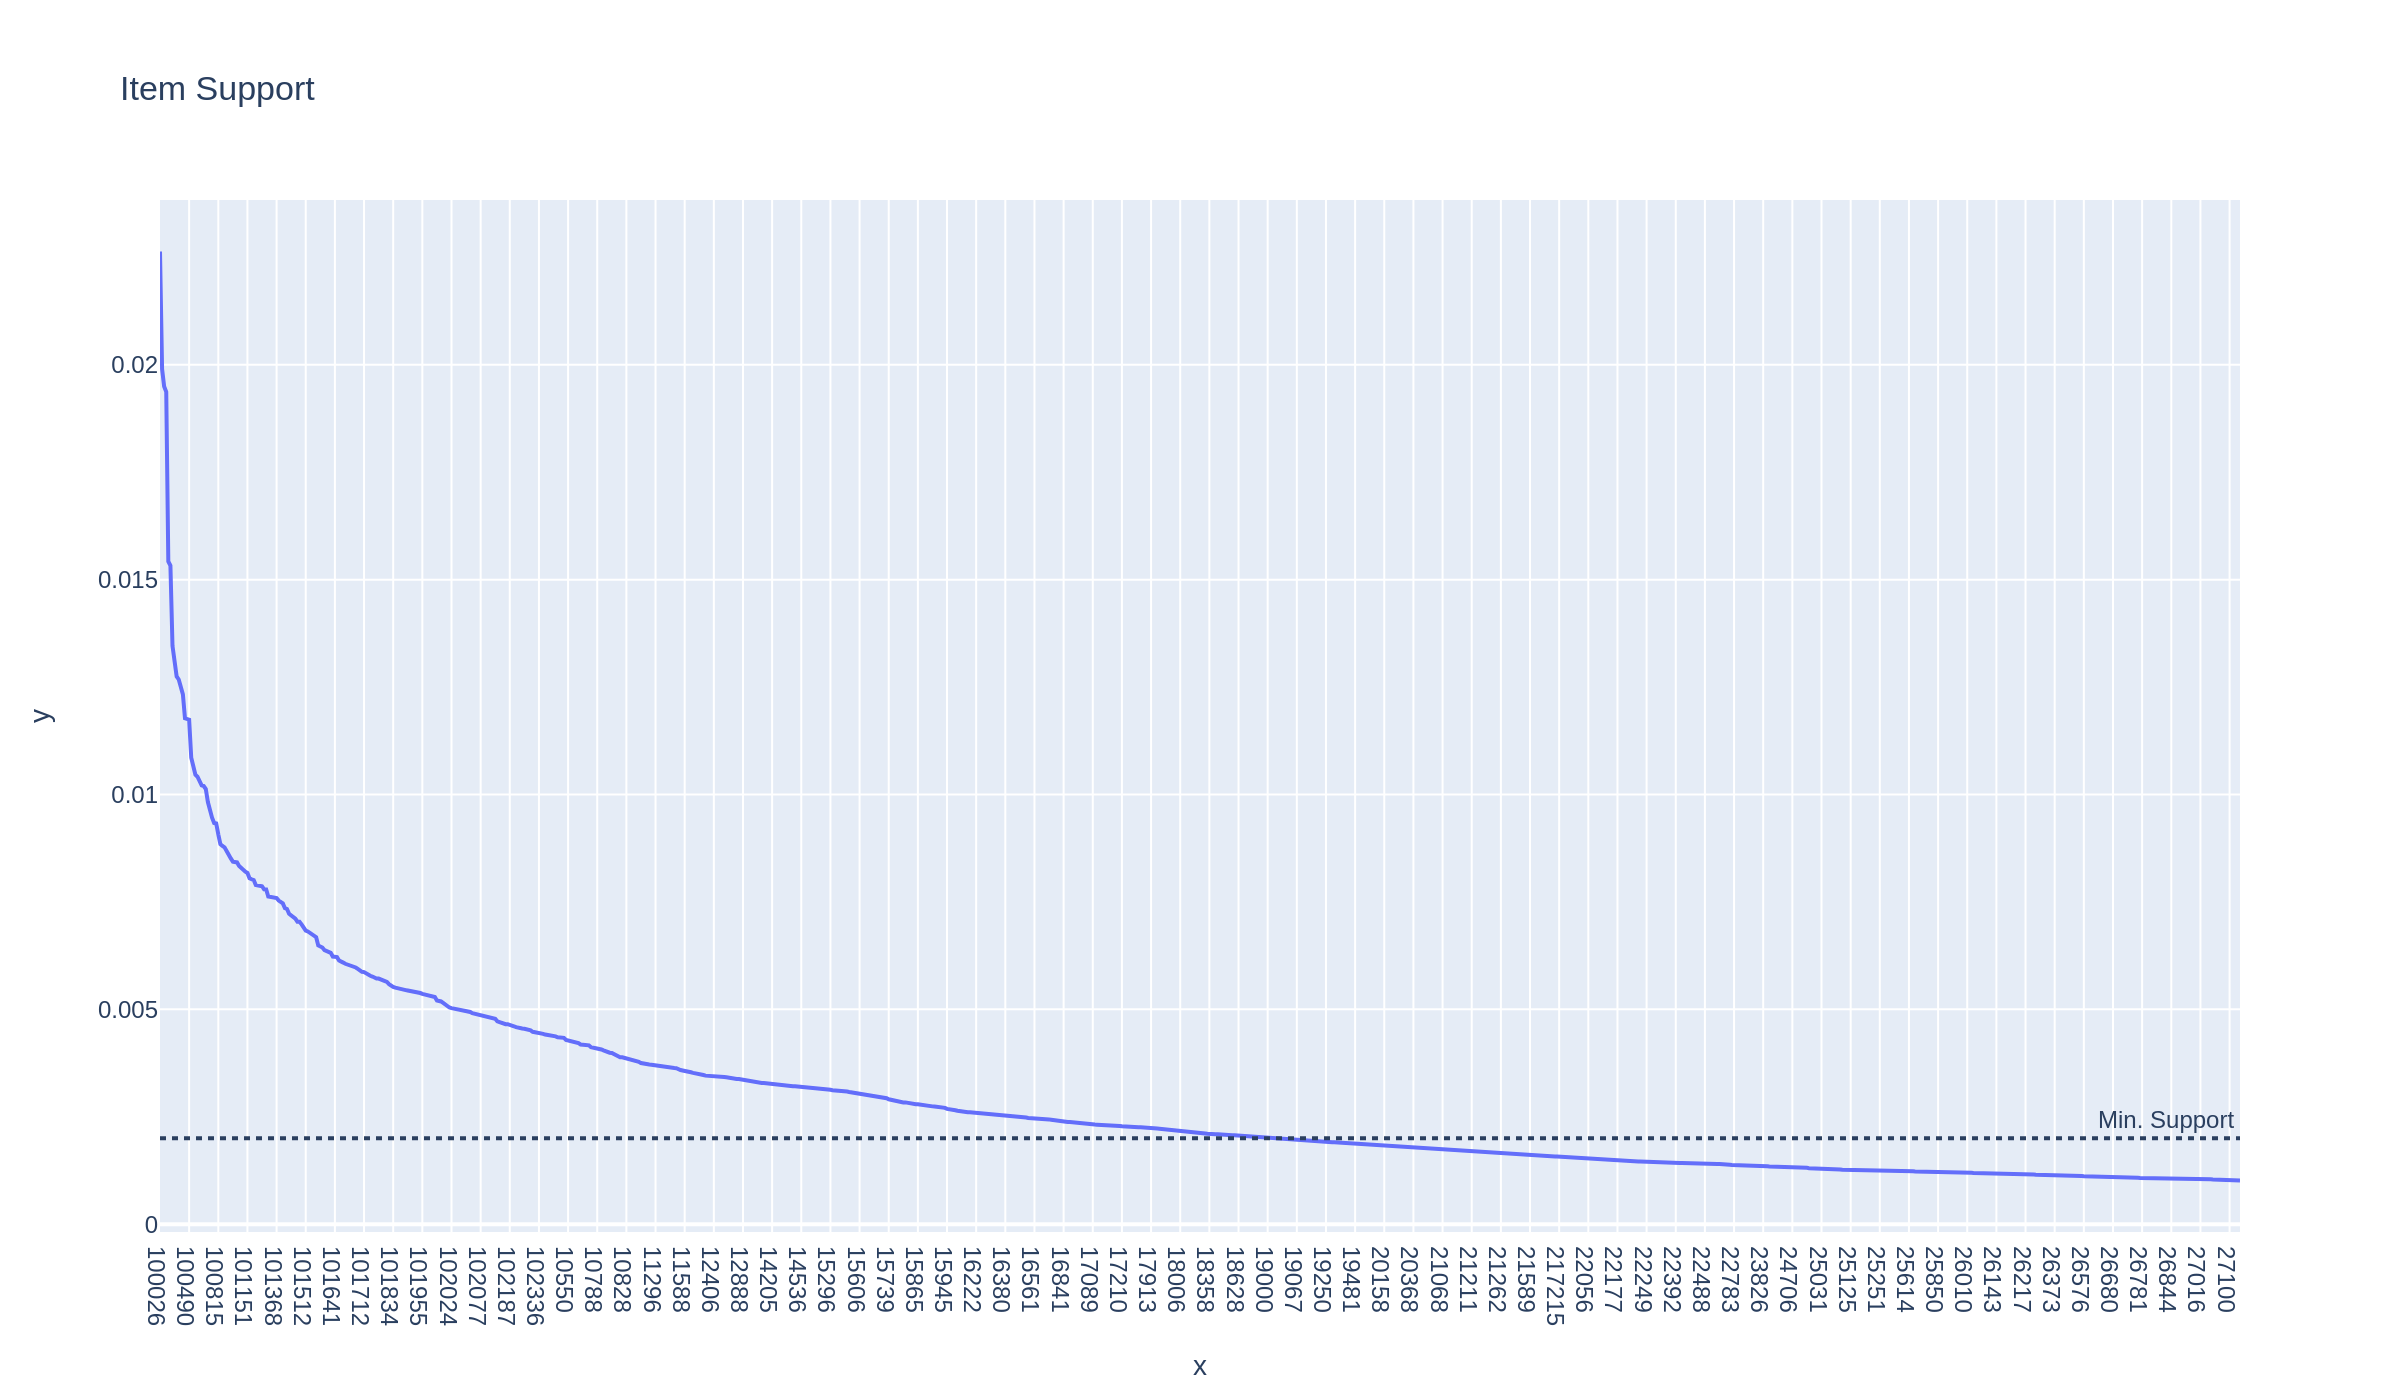

In [139]:
fig= px.line([item_frequency], x= sparse_basket_df.columns[0:1000],
                               y= item_frequency[0:1000],
                    title='Item Support')

min_support = 0.002
fig.add_hline(y= min_support, line_dash="dot",
              annotation_text=f"Min. Support",
              annotation_position="top right")

Image(fig.to_image(format="png", width= 1200, height= 700,scale=2))

**Apriori Algorithm**

This is computationally efficient algorithm that uses a hashing scheme to find frequent item sets. While there are more effient methods like the FP-Growth algorithm, the implementation in this report does not require extensive memory.

In [140]:
%time item_sets = apriori(sparse_basket_df, min_support=min_support, use_colnames=True, verbose=1, low_memory=True)

Processing 5 combinations | Sampling itemset size 4
CPU times: user 12.6 s, sys: 16.6 s, total: 29.2 s
Wall time: 29.4 s


In [141]:
item_sets

support                       itemsets
0    0.004446                        (10008)
1    0.011771                       (100413)
2    0.005447                       (100423)
3    0.010667                        (10548)
4    0.007624                        (10550)
..        ...                            ...
841  0.002184          (64863, 65013, 64870)
842  0.003095          (65013, 64864, 64870)
843  0.002816          (65013, 64865, 64870)
844  0.002397          (64904, 65013, 64870)
845  0.002679  (64858, 65013, 100413, 64870)

[846 rows x 2 columns]

The next function creates named item sets by assigning the product_name for better readability

In [142]:
def display_item_sets(set, product_names):
    prod_list = product_names.product_name
    named_sets =[]
    for item in set.itemsets:
        named_sets.append([prod_list[item_id] for item_id in list(item)])
    return pd.DataFrame({'support':set.support,
                          'itemsets':named_sets}).sort_values('support', ascending=False).reset_index()

pd.set_option('display.max_rows', None)
named_item_sets = display_item_sets(item_sets, product_names)
named_item_sets

index   support                                           itemsets
0       32  0.022635                     [BLACK VELVET 1750ml (6 pack)]
1      359  0.019901  [FIREBALL CINNAMON WHISKEY MINI SLEEVE 50ml (1...
2      356  0.019495        [FIREBALL CINNAMON WHISKEY 100ml (48 pack)]
3      197  0.019371                    [HAWKEYE VODKA 1750ml (6 pack)]
4      233  0.015423             [TITOS HANDMADE VODKA 750ml (12 pack)]
5      349  0.015327  [FIREBALL CINNAMON WHISKEY MINI DISPENSER 50ml...
6      235  0.013456             [TITOS HANDMADE VODKA 1750ml (6 pack)]
7      234  0.013143            [TITOS HANDMADE VODKA 1000ml (12 pack)]
8      106  0.012748                 [SEAGRAMS 7 CROWN 1750ml (6 pack)]
9       11  0.012676                [CROWN ROYAL PEACH 750ml (12 pack)]
10     263  0.012483            [ADMIRAL NELSON SPICED 1750ml (6 pack)]
11     329  0.012328  [JOSE CUERVO AUTHENTIC LIME MARGARITA 1750ml (...
12       1  0.011771  [FIREBALL CINNAMON WHISKEY PARTY BUCKET 50ml (...
13     200  0.011744                    [BLUE OX VODKA 1750ml (6 pack)]
14      15  0.011740          [CROWN ROYAL REGAL APPLE 750ml (12 pack)]
15     792  0.010929  [FIREBALL CINNAMON WHISKEY MINI SLEEVE 50ml (1...
16     194  0.010853                [HAWKEYE VODKA PET 750ml (12 pack)]
17       3  0.010667     [BLACK VELVET TOASTED CARAMEL 1750ml (6 pack)]
18      20  0.010458                      [CROWN ROYAL 750ml (12 pack)]
19     205  0.010413        [MCCORMICK 80PRF VODKA PET 375ml (24 pack)]
20     295  0.010272              [PARAMOUNT WHITE RUM 1750ml (6 pack)]
21     232  0.010210             [TITOS HANDMADE VODKA 375ml (12 pack)]
22     283  0.010196  [CAPTAIN MORGAN ORIGINAL SPICED 1000ml (12 pack)]
23     206  0.010128        [MCCORMICK 80PRF VODKA PET 1750ml (6 pack)]
24     256  0.009825                   [MALIBU COCONUT 750ml (12 pack)]
25     114  0.009605  [JACK DANIELS OLD #7 BLACK LABEL 750ml (12 pack)]
26      31  0.009460                 [BLACK VELVET PET 750ml (12 pack)]
27     770  0.009402  [FIREBALL CINNAMON WHISKEY MINI DISPENSER 50ml...
28     189  0.009337               [FIVE O'CLOCK VODKA 1750ml (6 pack)]
29     158  0.009326      [ABSOLUT SWEDISH VODKA 80PRF 750ml (12 pack)]
30     183  0.009072                     [BARTON VODKA 1750ml (6 pack)]
31     282  0.008845   [CAPTAIN MORGAN ORIGINAL SPICED 750ml (12 pack)]
32     279  0.008800  [CAPTAIN MORGAN ORIGINAL SPICED MINI 50ml (12 ...
33      22  0.008769                      [CROWN ROYAL 1750ml (6 pack)]
34      28  0.008683                     [BLACK VELVET 375ml (24 pack)]
35     180  0.008549                     [SVEDKA 80PRF 1750ml (6 pack)]
36     481  0.008511   [OLE SMOKY SALTY CARAMEL WHISKEY 750ml (6 pack)]
37     772  0.008494  [FIREBALL CINNAMON WHISKEY MINI DISPENSER 50ml...
38     352  0.008436    [FIREBALL CINNAMON WHISKEY PET 750ml (12 pack)]
39     229  0.008425               [SMIRNOFF 80PRF PET 1750ml (6 pack)]
40     169  0.008418                [FRIS DANISH VODKA 1750ml (6 pack)]
41      62  0.008336  [CAPTAIN MORGAN ORIGINAL SPICED BARREL 1750ml ...
42     231  0.008281                [PLATINUM 7X VODKA 1750ml (6 pack)]
43     116  0.008236  [JACK DANIELS OLD #7 BLACK LABEL 1750ml (6 pack)]
44     101  0.008202                        [FIVE STAR 1750ml (6 pack)]
45     333  0.008174  [JOSE CUERVO AUTHENTIC LIGHT LIME MARGARITA 17...
46     324  0.008050              [CHI-CHI'S MARGARITA 1750ml (6 pack)]
47      82  0.008026                      [MAKERS MARK 750ml (12 pack)]
48      61  0.008009              [EVAN WILLIAMS BLACK 1750ml (6 pack)]
49     351  0.007892        [FIREBALL CINNAMON WHISKEY 375ml (24 pack)]
50     237  0.007872          [TITOS HANDMADE VODKA MINI 50ml (5 pack)]
51      38  0.007868             [WINDSOR CANADIAN PET 1750ml (6 pack)]
52     112  0.007865  [JACK DANIELS OLD #7 BLACK LABEL MINI 50ml (12...
53     357  0.007793    [FIREBALL CINNAMON WHISKEY PET 1750ml (6 pack)]
54      74  0.007789                         

**Association Rules**

Association Rules will give an understanding of frequent item sets by assigning different scores based on different criteria. The min threshold parameter used above will be added so that the rarely purchased items are excluded.

In [143]:
apriori_assocs = association_rules(item_sets, min_threshold=min_support)

Confidence and Lift are two commonly used metrics for evaluating association rules. Confidence is the probability that the association rule will result in a transaction. Therefore, the higher the confidence, the higher the chance that the rule is a good prediction.

Lift is the ratio at which two item sets appear together than what would be expected if they were statistically independent. The higher the Lift, the higher the probability that the association rule is a good prediction.  
In the next section, these metrics will be used to evaluate the best outcomes.



**Distributions of Lift and Confidence**

In [144]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import power_transform

scaler = StandardScaler()


In [145]:
def get_assoc_score_distrs(data, columns, scaling_method="standard_scaler"):
    scaled_cols = [f"{col}_scaled" for col in columns]

    if scaling_method == "standard_scaler":
      data[scaled_cols] = scaler.fit_transform(data[columns])

    elif scaling_method == "box_cox":
      data[scaled_cols] = power_transform(data[columns], method='box-cox')

    else:
      data[scaled_cols] = (data[columns] - data[columns].mean(axis=0))/ data[columns].std(axis=0)
    return data

conf_lift_distr = get_assoc_score_distrs(apriori_assocs[["confidence", "lift"]],
                                          ["confidence", "lift"],
                                          scaling_method="custom")
conf_lift_distr.head(5)

confidence       lift  confidence_scaled  lift_scaled
0    0.484919  24.873879           0.990930    -0.526774
1    0.110602  24.873879          -1.352368    -0.526774
2    0.574633  28.874719           1.552556    -0.244466
3    0.128391  28.874719          -1.241001    -0.244466
4    0.426136  36.201174           0.622941     0.272506

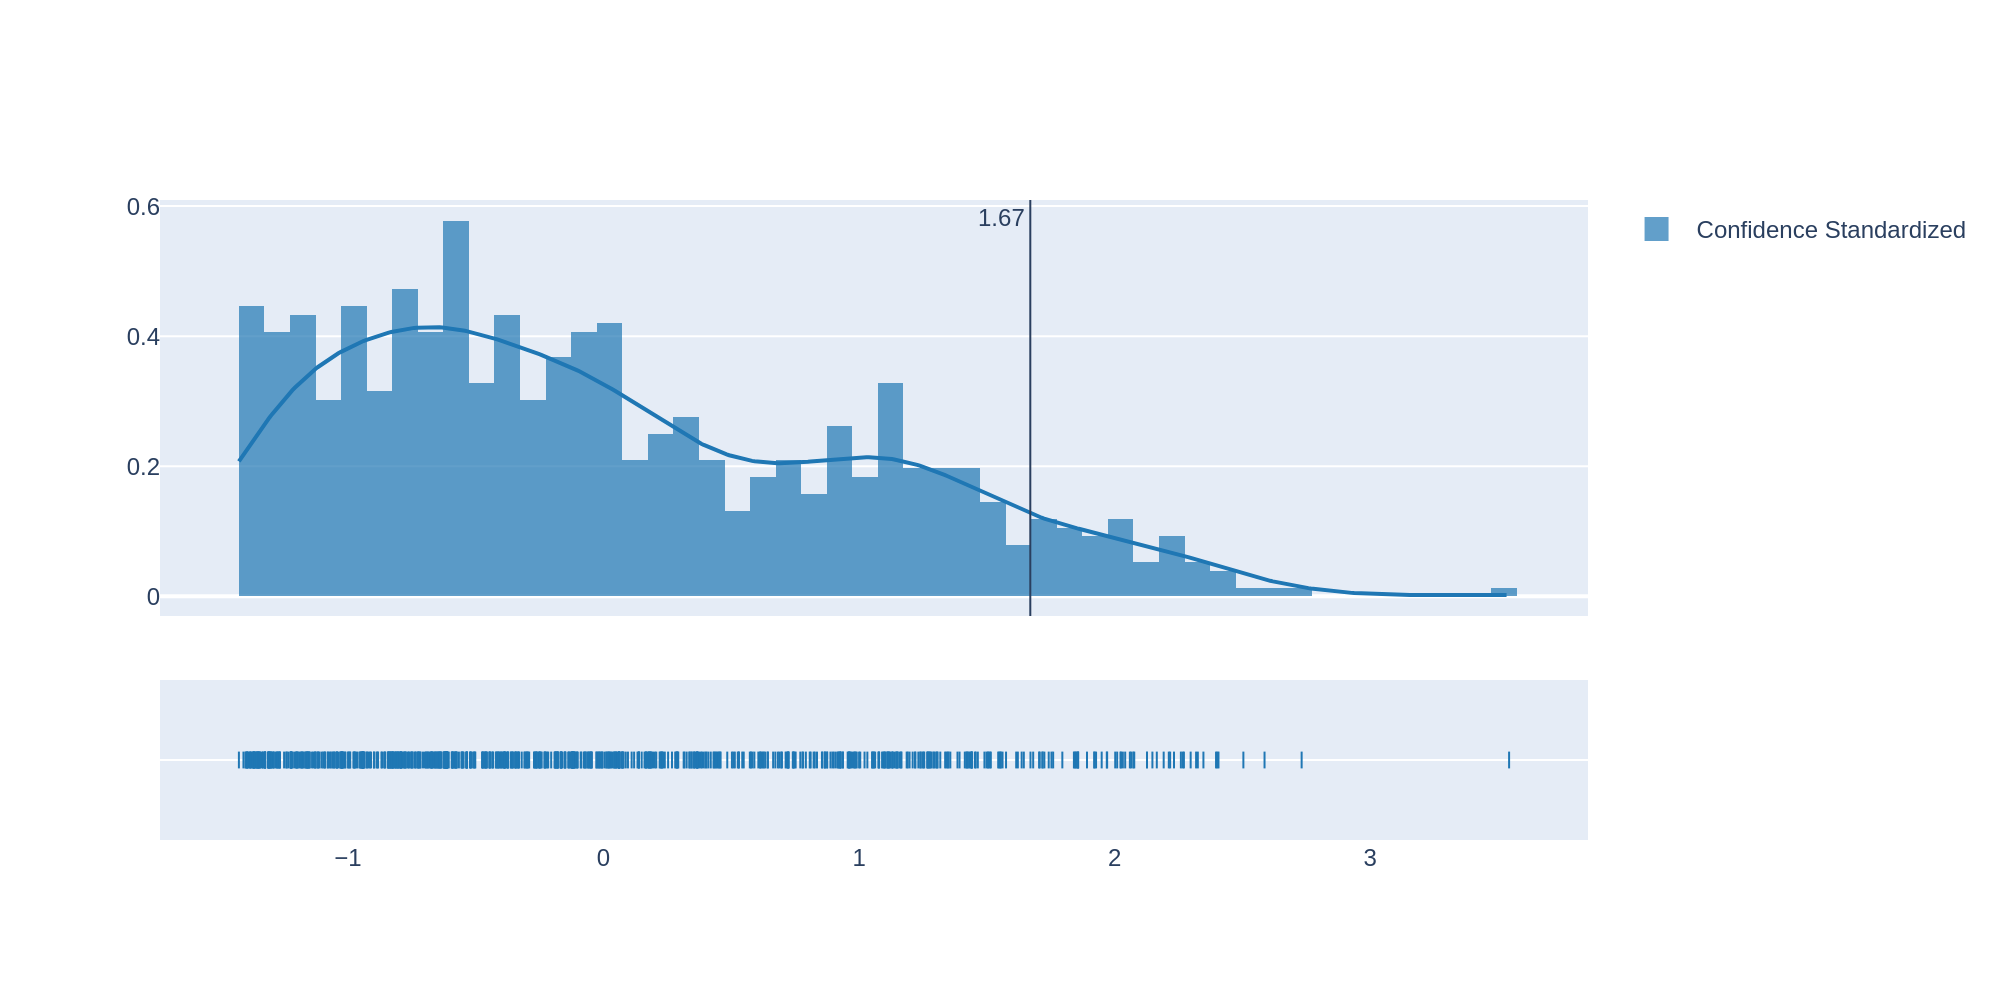

In [146]:
hist_data = [conf_lift_distr["confidence_scaled"]]
group_labels = ['Confidence Standardized'] # name of the dataset

v_lines=[1.67]
pyplot_distplot(hist_data, group_labels, v_lines, bin_size=0.1)

From the distribution chart above, the scaled value (z-score) of 1.67 appears to be a good cutoff point. In this case the outliers at the upper extremities of the distribution are desirable.

We will use this z-score to calculate the minimum value needed for the original data using some simple algebra.

In [147]:
## based on z = x-mu/sigma
apriori_confidence_thresh =  1.67 * (apriori_assocs.confidence.std()) + apriori_assocs.confidence.std()
apriori_confidence_thresh

0.4265044568499144

In [148]:
filter = (apriori_assocs.confidence> apriori_confidence_thresh)
top_by_lift_conf = apriori_assocs[filter].sort_values(by=["confidence", "lift"], ascending=False)
len(top_by_lift_conf)

210

  The next step will find a threshold for lift.

In [149]:
lift_distr = get_assoc_score_distrs(top_by_lift_conf[["lift"]],
                                          ["lift"],
                                          scaling_method="custom")
lift_distr.head(5)

lift  lift_scaled
251  214.523745     7.942461
748   39.136882     0.123828
750   37.173766     0.036314
587   36.509044     0.006681
568   36.471012     0.004985

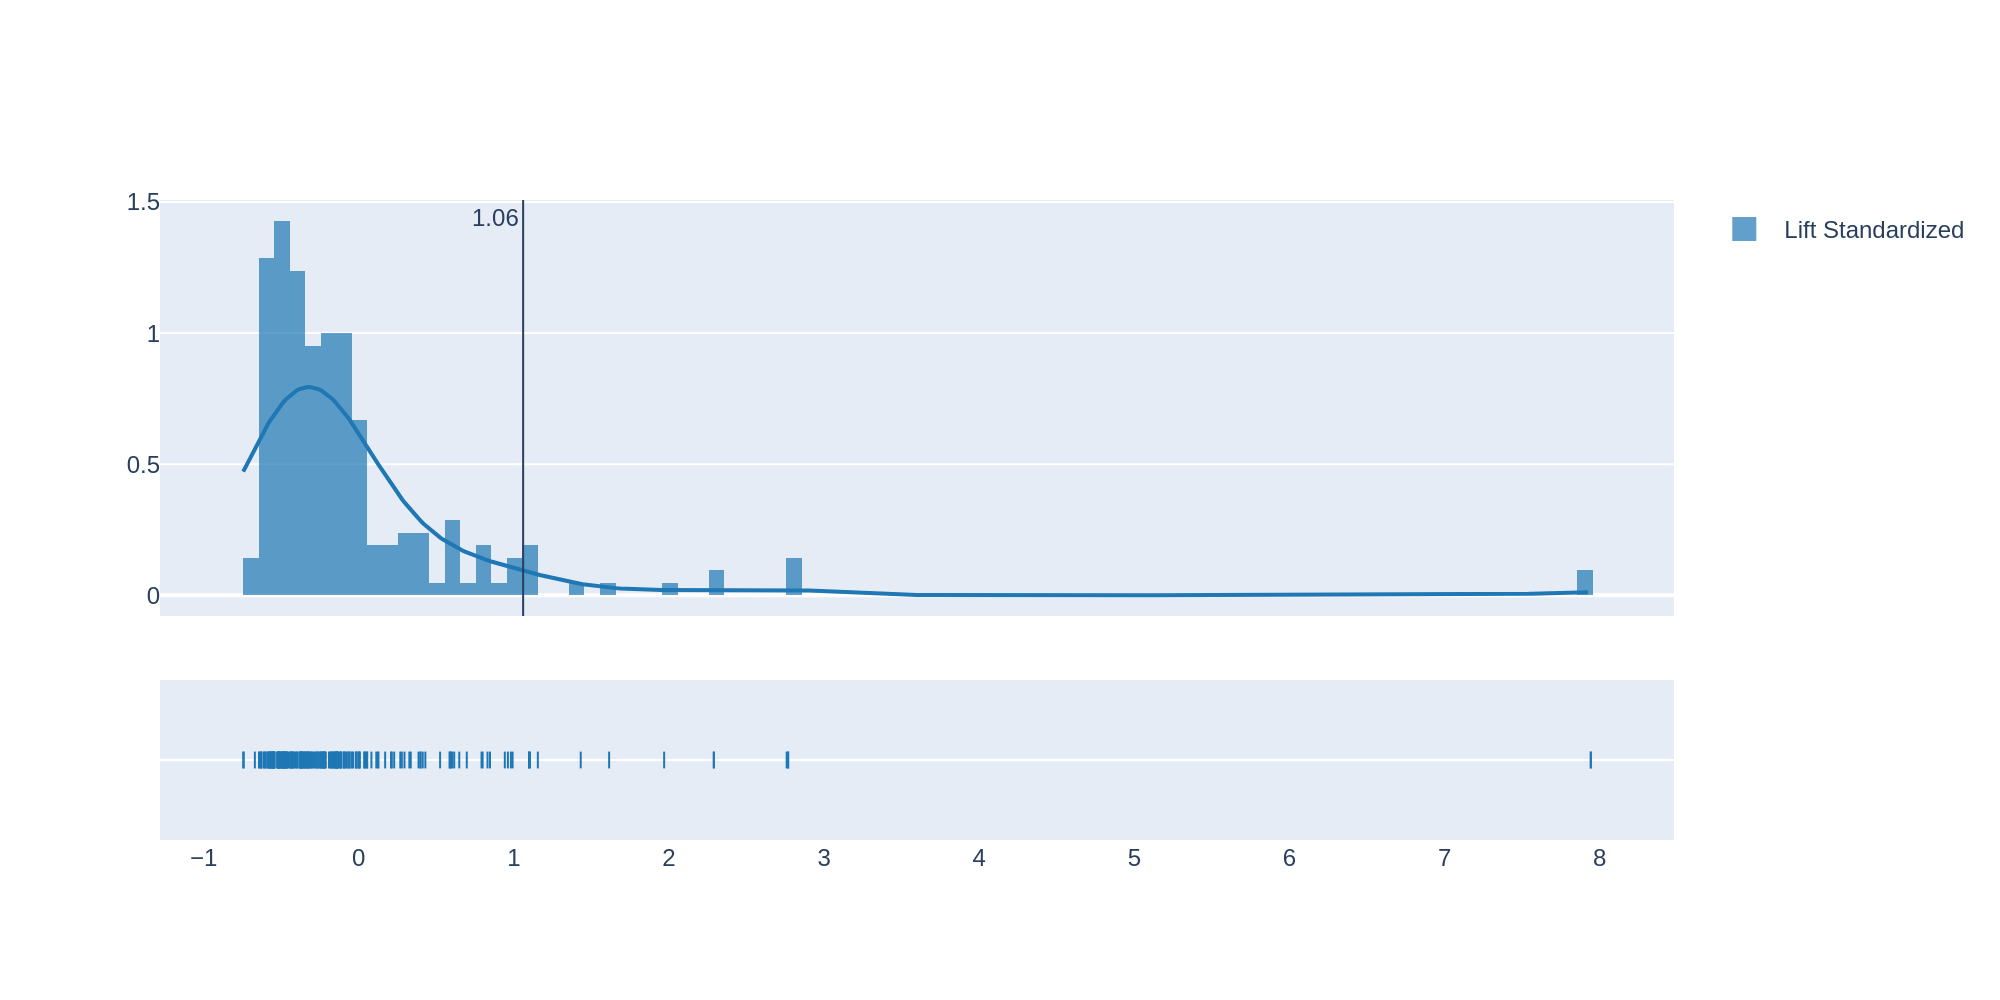

In [150]:
hist_data = [lift_distr["lift_scaled"]]
group_labels = ['Lift Standardized'] # name of the dataset
v_lines=[1.06]
pyplot_distplot(hist_data, group_labels, v_lines, bin_size=0.1)

The Distribution plot suggests that 1.06 is a good cutoff point.

In [151]:
## based on z = x-mu/sigma
apriori_lift_thresh =  1.06 * (apriori_assocs.lift.std()) + apriori_assocs.lift.std()
apriori_lift_thresh

29.194040215264227

In [152]:
filter = top_by_lift_conf.lift >= apriori_lift_thresh
top_by_lift_conf = top_by_lift_conf[filter].sort_values(by=["confidence", "lift"], ascending=False)

len(top_by_lift_conf)

117

This  reduced the association rules  where reduced significantly.

In [153]:
a_item_name_ids = [list(v) for v in top_by_lift_conf.antecedents.values]
c_item_name_ids = [list(v) for v in top_by_lift_conf.consequents.values]

top_by_lift_conf["antecedents_name"] = [list(product_names.product_name.loc[l]) for l in a_item_name_ids]
top_by_lift_conf["consequent_name"]  = [list(product_names.product_name.loc[l]) for l in c_item_name_ids]

This section will print the first 10 association rules based on Confidence and Lift.

In [154]:
for i,v in top_by_lift_conf[["antecedents_name","consequent_name", "confidence", "lift"]].head(10).iterrows():
  print("Antecedent:  " , v[0])
  print("Consequent:  " , v[1])
  print("Confidence:  ",  v[2])
  print("Lift:        ", v[3] , "\n ----------------------------------")

Antecedent:   ['BLANTONS BOURBON 750ml (6 pack)']
Consequent:   ['BUFFALO TRACE BOURBON 750ml (12 pack)']
Confidence:   0.8926470588235295
Lift:         214.5237445308702 
 ----------------------------------
Antecedent:   ['FIREBALL CINNAMON WHISKEY MINI DISPENSER 50ml (1 pack)', 'FIREBALL CINNAMON WHISKEY MINI SLEEVE 50ml (12 pack)', 'FIREBALL CINNAMON WHISKEY PARTY BUCKET 50ml (1 pack)']
Consequent:   ['FIREBALL CINNAMON WHISKEY 100ml (48 pack)']
Confidence:   0.762977473065622
Lift:         39.13688170227999 
 ----------------------------------
Antecedent:   ['FIREBALL CINNAMON WHISKEY MINI DISPENSER 50ml (1 pack)', 'FIREBALL CINNAMON WHISKEY PARTY BUCKET 50ml (1 pack)', 'FIREBALL CINNAMON WHISKEY 100ml (48 pack)']
Consequent:   ['FIREBALL CINNAMON WHISKEY MINI SLEEVE 50ml (12 pack)']
Confidence:   0.7397910731244065
Lift:         37.173766363386775 
 ----------------------------------
Antecedent:   ['FIREBALL CINNAMON WHISKEY 100ML CARRIER 100ml (8 pack)', 'FIREBALL CINNAMON WHISKE

**Market Basket Analysis Conclusion**

Output above shows that when an antecedent is purchased there is a high probability that a consequent will be purchased with it.  for example, the output:

***Antecedent:***   ['FIREBALL CINNAMON WHISKEY MINI DISPENSER 50ml (1 pack )', 'FIREBALL CINNAMON WHISKEY 100ml (48 pack )', 'FIREBALL CINNAMON WHISKEY PARTY BUCKET 50ml (1 pack )']

***Consequent:***   ['FIREBALL CINNAMON WHISKEY MINI SLEEVE 50ml (12 pack )']

, indicates that when the three products  in the Antecedent are purchased together,  the product in the consequent is likely to be purchased with them.  

For wholesale buying, this could be a way to find suppliers or distributors with the best offers for this combination of products, if the products can be supplied by different vendors.



 &nbsp;

#References


[1] Pandas - https://pandas.pydata.org/docs/index.html

[2] Google Big Frames: https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.dataframe.DataFrame#bigframes_dataframe_DataFrame_to_pandas

[3] Null Mask: https://saturncloud.io/blog/python-pandas-selecting-rows-whose-column-value-is-null-none-nan/#:~:text=The%20simplest%20way%20to%20select,rows%20that%20have%20null%20values.

[4] Numpy - https://numpy.org

[5] Plotly -https://plotly.com/

[6] Random Shuffle Numpy - https://stackoverflow.com/questions/49000093/np-random-shuffle-not-workingpython

[7] Pandas Time difference - https://www.statology.org/pandas-time-difference/

[8] Exponential Smoothing - https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

[9] StatsModel Convergence Warning - https://stackoverflow.com/questions/61925579/convergencewarning-when-trying-to-use-exponentialsmoothing-to-forecast

[10] Holt-Winters - https://otexts.com/fpp2/holt-winters.html

[11] Exponential Smoothing With Trend and Seasonality - https://www.stat.berkeley.edu/~ryantibs/timeseries-f23/lectures/ets.pdf

[12] Pandas  Epoch to DataTime - https://www.statology.org/pandas-convert-epoch-to-datetime/